In [1]:
import cv2
import os
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
SEED=42
imgs = io.imread('C://lumic_grandchell_dataset//train//020_train_pre_contrast_6mm.mhd', plugin='simpleitk')
masks = io.imread('C://lumic_grandchell_dataset//train//train_mask.mhd', plugin='simpleitk')
test_imgs = io.imread('C://lumic_grandchell_dataset//test//test_post_contrast.mhd', plugin='simpleitk')
mmasks = io.imread('C://lumic_grandchell_dataset//test//test_mask.mhd', plugin='simpleitk')

In [2]:
x_train=[]
y_train=[]
x_test = []
y_test =[]
x_val=[]
y_val=[]

x_train = [cv2.resize(img, dsize=(128,128),interpolation=cv2.INTER_LANCZOS4) for img in imgs]
y_train = [cv2.resize(mask, dsize=(128,128),interpolation=cv2.INTER_LANCZOS4) for mask in masks]
x_test = [cv2.resize(test_img, dsize=(128,128),interpolation=cv2.INTER_LANCZOS4) for test_img in test_imgs]
y_test =[cv2.resize(mmask, dsize=(128,128),interpolation=cv2.INTER_LANCZOS4) for mmask in mmasks]


x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test=np.array(x_test,dtype=np.float32)
y_test=np.array(y_test,dtype=np.float32)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)


x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size =0.2)

x_val = np.array(x_val)
y_val = np.array(y_val)


print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(286, 128, 128) (286, 128, 128) (286, 128, 128) (286, 128, 128)
(228, 128, 128) (228, 128, 128)
(58, 128, 128) (58, 128, 128)


In [3]:
x_train = x_train.astype('float32')
x_test =x_test.astype('float32')
x_val=x_val.astype('float32')


center = -400
width = 1500

low = center - width / 2
high = center + width / 2


x_train = (x_train-low) / (high-low)
x_train[x_train < 0.] = 0.
x_train[x_train > 1.] = 1.

x_val = (x_val-low) / (high-low)
x_val[x_val < 0.] = 0.
x_val[x_val > 1.] = 1.

x_test = (x_test-low) / (high-low)
x_test[x_test < 0.] = 0.
x_test[x_test > 1.] = 1.


train_std = np.std(x_train)
train_mean = np.mean(x_train)
test_std = np.std(x_test)
test_mean = np.mean(x_test)
val_std = np.std(x_val)
val_mean = np.mean(x_val)
print(train_mean,train_std,test_mean,test_std,val_std,val_mean)

x_train -= train_mean
x_train /= train_std
x_test -= test_mean
x_test /= test_std
x_val -= val_mean
x_val /= val_std




y_train[y_train < 0.] = 0.
y_train[y_train > 1.] = 1.

y_val[y_val < 0.] = 0.
y_val[y_val > 1.] = 1.

y_test[y_test < 0.] = 0.
y_test[y_test > 1.] = 1.

0.46948013 0.3263599 0.4810989 0.33395085 0.32426953 0.4870175


In [4]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [5]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

input_layer = Input((128,128, 1))
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 16)   1168        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [6]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [7]:
x_train = x_train.reshape(-1,128,128,1)
y_train = y_train.reshape(-1,128,128,1)

x_test = x_test.reshape(-1,128,128,1)
y_test = y_test.reshape(-1,128,128,1)
x_val = x_val.reshape(-1,128,128,1)
y_val  = y_val.reshape(-1,128,128,1)

In [8]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 3))

In [9]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [10]:
weight_saver = ModelCheckpoint('lung11.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)


In [11]:
hist = model.fit_generator(my_generator(x_train, y_train, 1),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
 - 26s - loss: 0.1524 - dice_coef: 0.3834 - val_loss: 0.0287 - val_dice_coef: 0.6792
Epoch 2/10
 - 24s - loss: 0.0390 - dice_coef: 0.6296 - val_loss: 0.0276 - val_dice_coef: 0.6822
Epoch 3/10
 - 23s - loss: 0.0306 - dice_coef: 0.6510 - val_loss: 0.0260 - val_dice_coef: 0.6874
Epoch 4/10
 - 23s - loss: 0.0295 - dice_coef: 0.6313 - val_loss: 0.0244 - val_dice_coef: 0.6824
Epoch 5/10
 - 23s - loss: 0.0265 - dice_coef: 0.6158 - val_loss: 0.0283 - val_dice_coef: 0.6909
Epoch 6/10
 - 23s - loss: 0.0282 - dice_coef: 0.6761 - val_loss: 0.0290 - val_dice_coef: 0.6842
Epoch 7/10
 - 23s - loss: 0.0253 - dice_coef: 0.6724 - val_loss: 0.0302 - val_dice_coef: 0.6858
Epoch 8/10
 - 23s - loss: 0.0246 - dice_coef: 0.6439 - val_loss: 0.0218 - val_dice_coef: 0.6898
Epoch 9/10
 - 23s - loss: 0.0245 - dice_coef: 0.6631 - val_loss: 0.0220 - val_dice_coef: 0.6946
Epoch 10/10
 - 23s - loss: 0.0246 - dice_coef: 0.6291 - val_loss: 0.0231 - val_dice_coef: 0.6942


In [12]:
result = model.predict(x_test)

result[result < 0.5] = 0.
result[result >= 0.5] = 1.

In [13]:
for i in range(y_test.shape[0]):   
    cv2.imwrite("C:/lumic_grandchell_dataset/npy/y_test[{}].png".format(i), y_test[i])
q = []
for i in range(286):   
    mask = cv2.imread("C:/lumic_grandchell_dataset/npy/y_test[{}].png".format(i))
    q.append(mask)
print(q[0].shape)

(128, 128, 3)


In [14]:
for i in range(286):   
    cv2.imwrite("C:/lumic_grandchell_dataset/resultnpy/result[{}].png".format(i), result[i])
    
a = []
for i in range(286):   
    result_mask = cv2.imread("C:/lumic_grandchell_dataset/resultnpy/result[{}].png".format(i))
    a.append(result_mask)


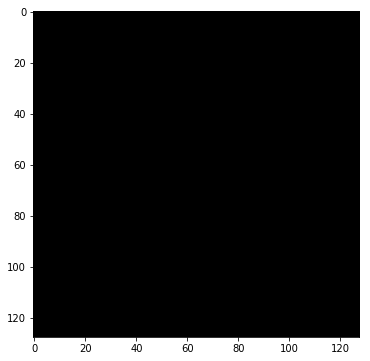

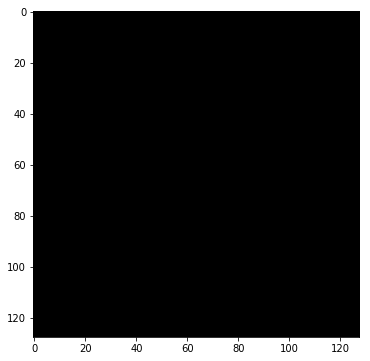

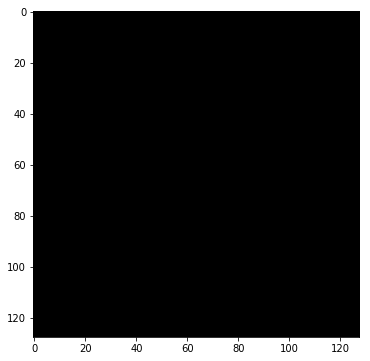

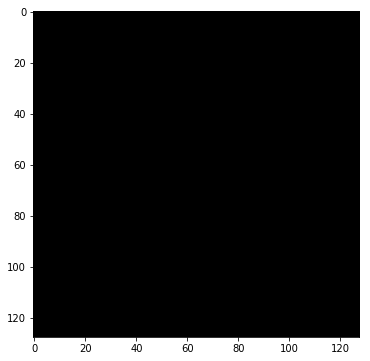

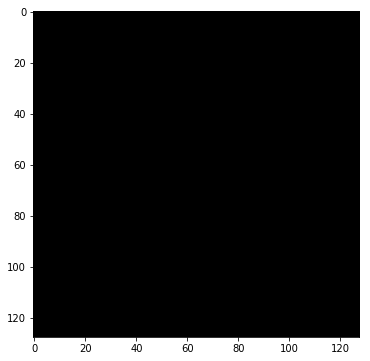

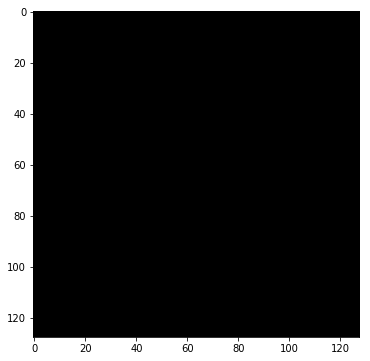

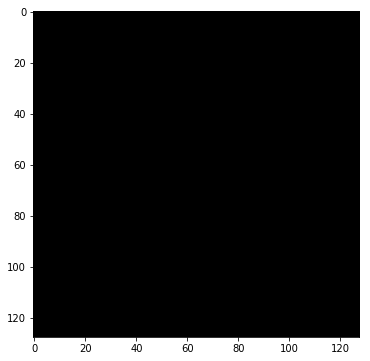

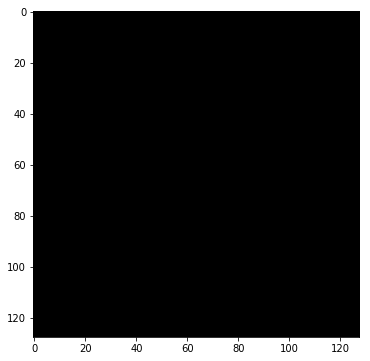

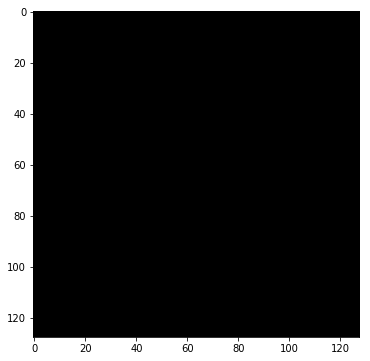

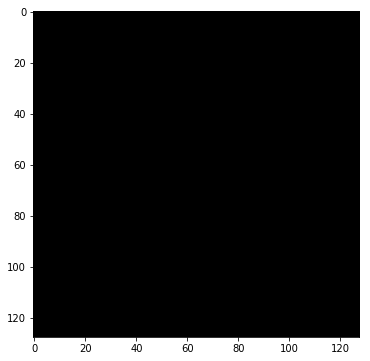

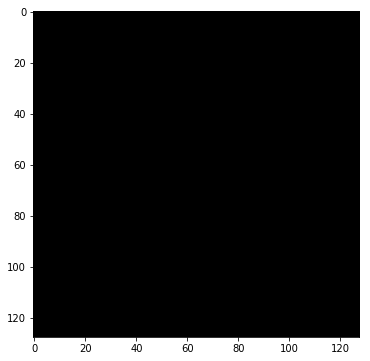

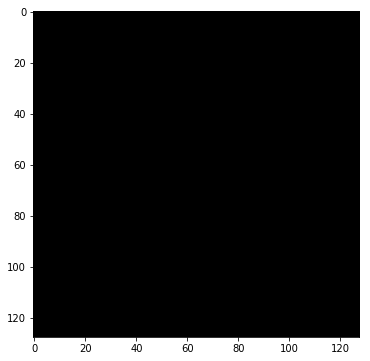

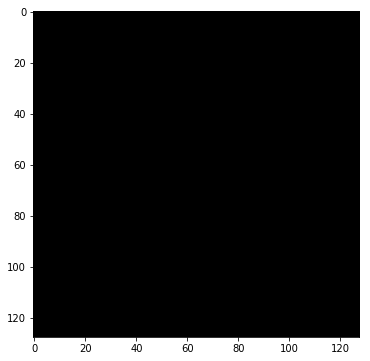

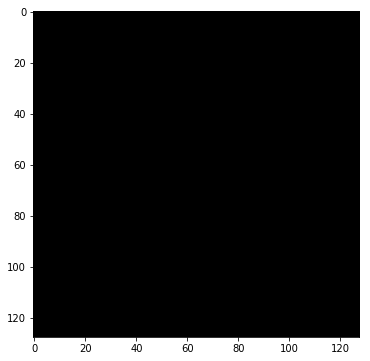

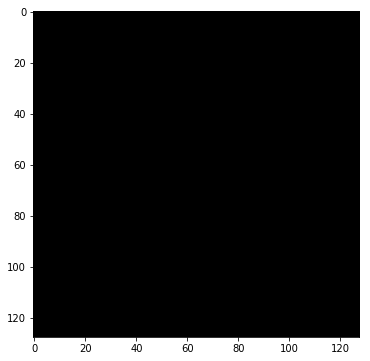

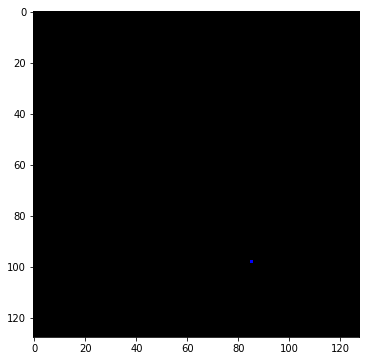

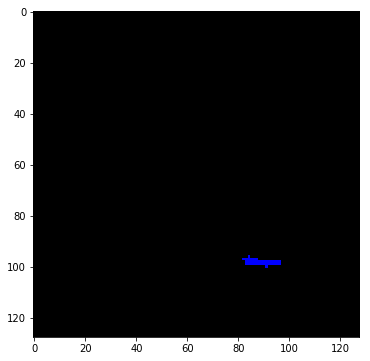

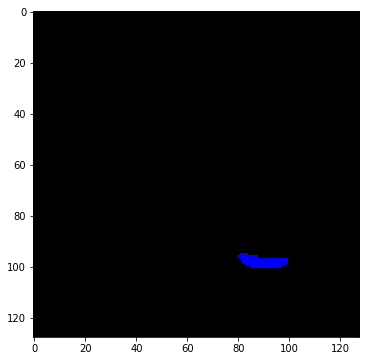

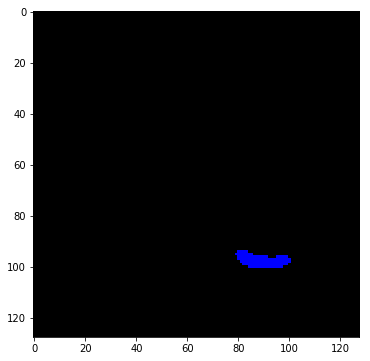

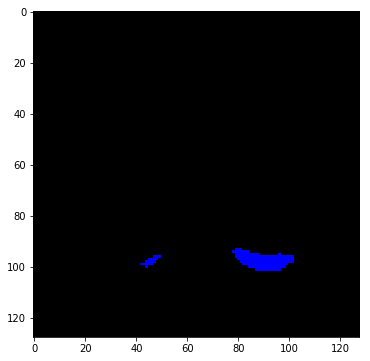

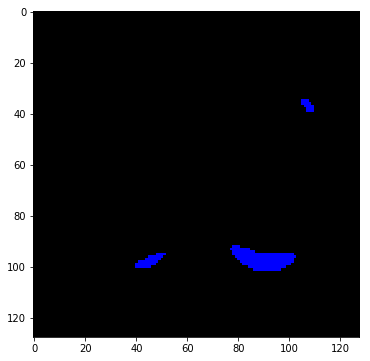

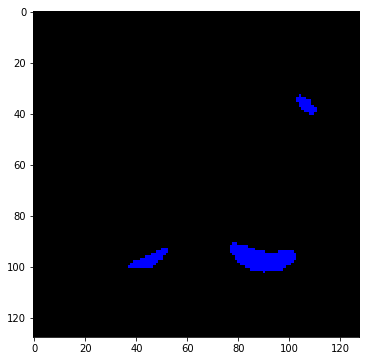

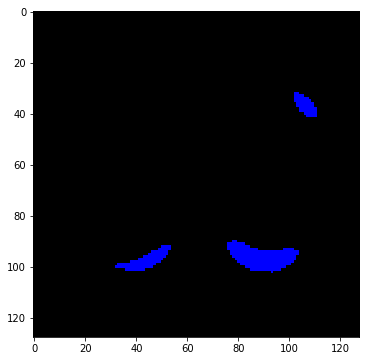

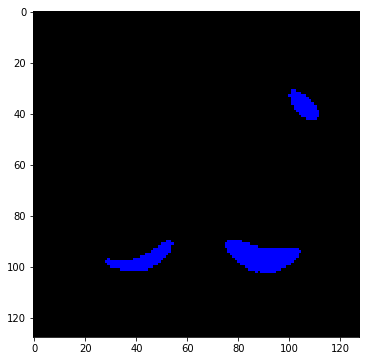

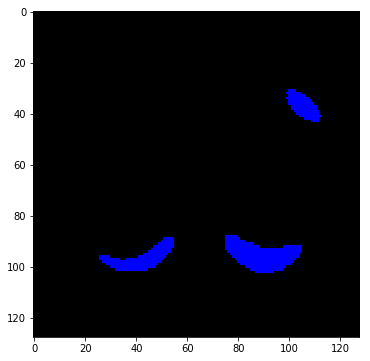

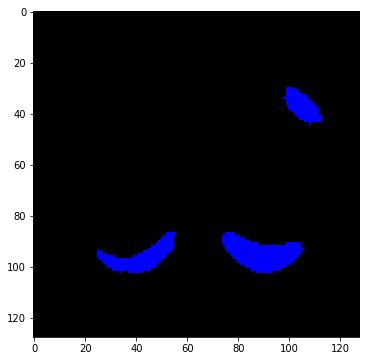

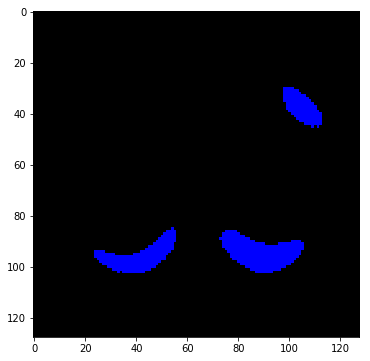

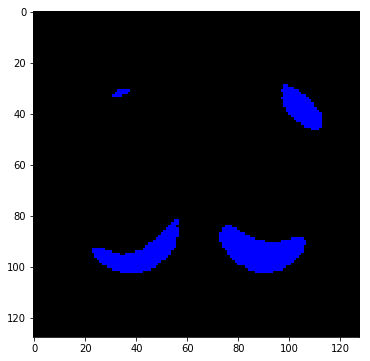

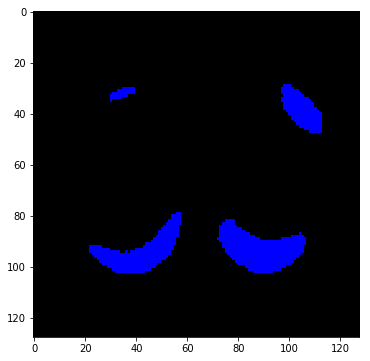

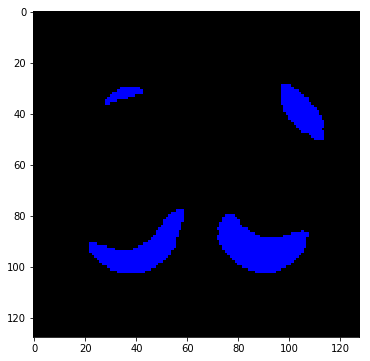

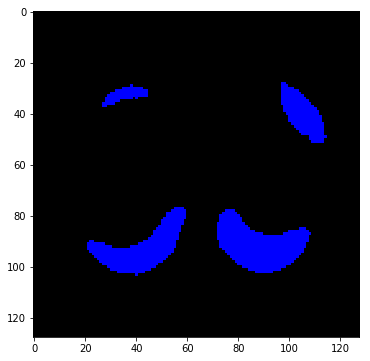

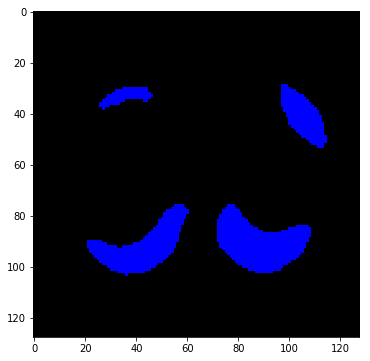

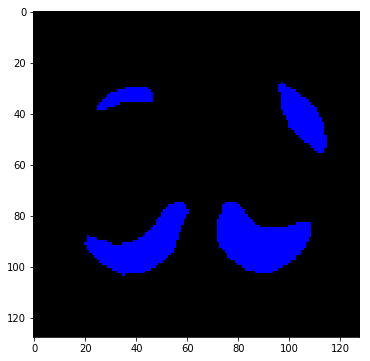

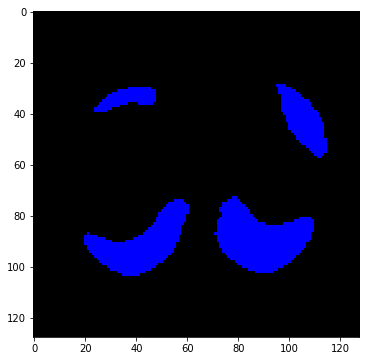

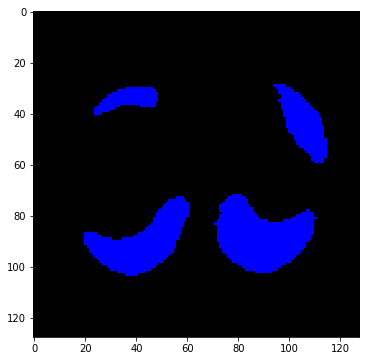

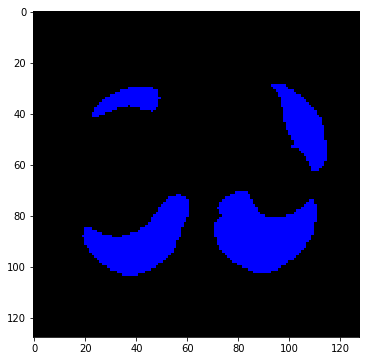

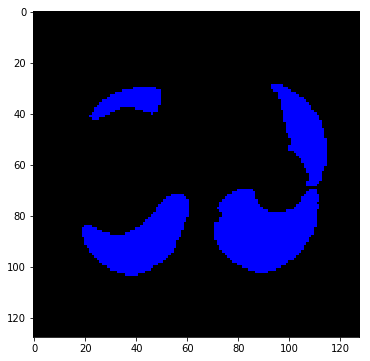

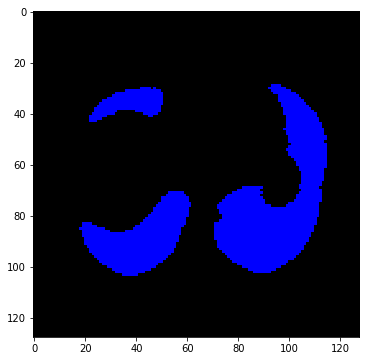

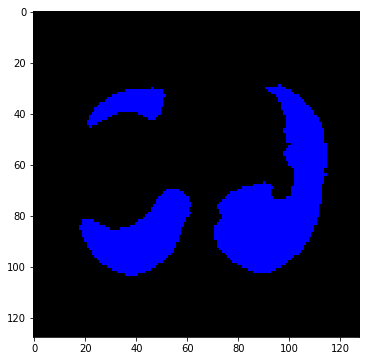

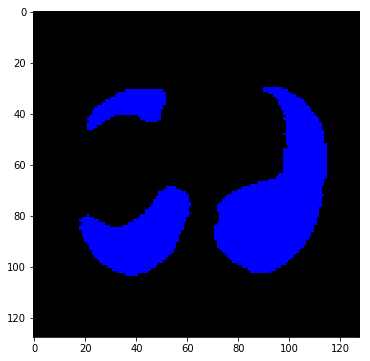

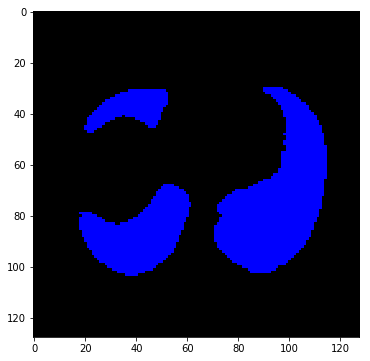

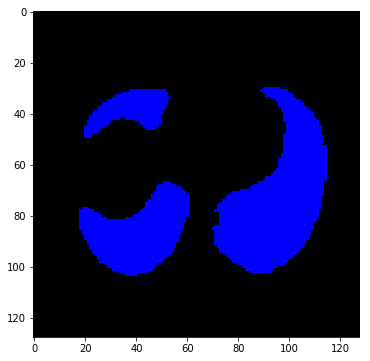

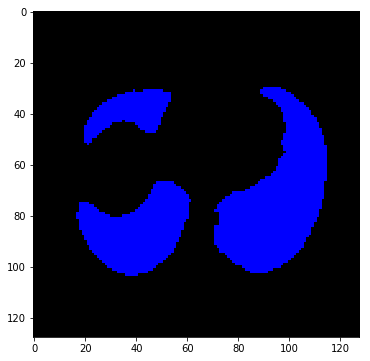

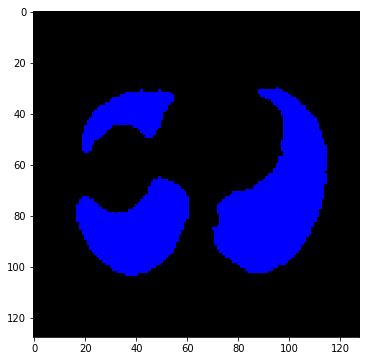

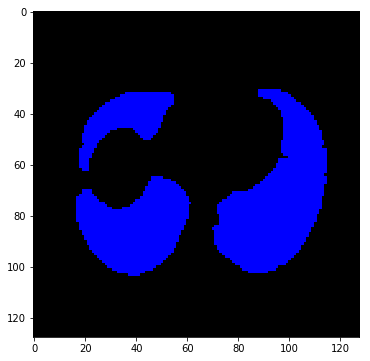

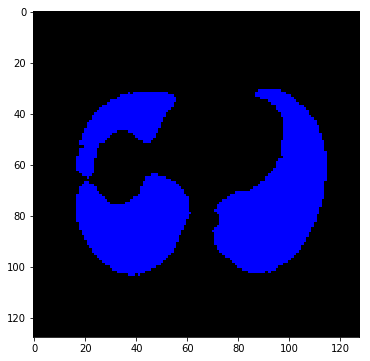

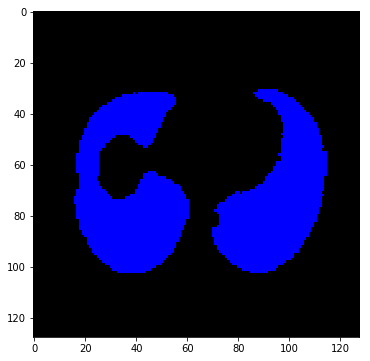

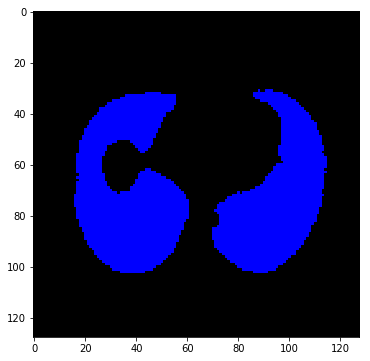

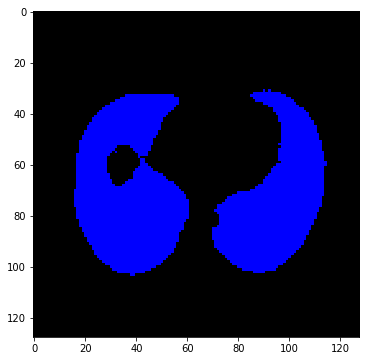

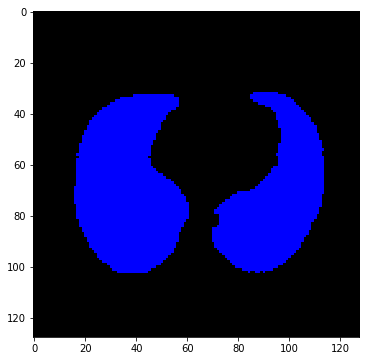

In [15]:
for k in range(286):
    for i in range(128):
        for j in range(128):
            pixel = q[k][i][j]
            if(pixel[0] == 1 and pixel[1] == 1 and pixel[2] == 1):#흰색이면
                pixel[0] = 0    #R
                pixel[1] = 0    #G
                pixel[2] = 255 #B

                
import matplotlib.pyplot as plt
for i in range(0, 100, 2): # 0에서 160까지의 숫자를 10칸 간격으로 추출하겠다는 의미
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(q[i])
 
    plt.show()

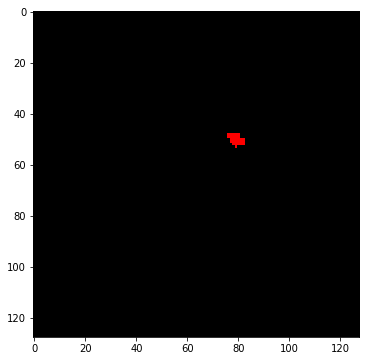

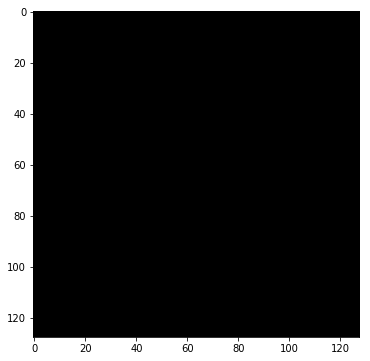

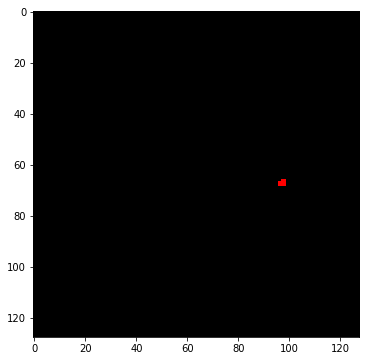

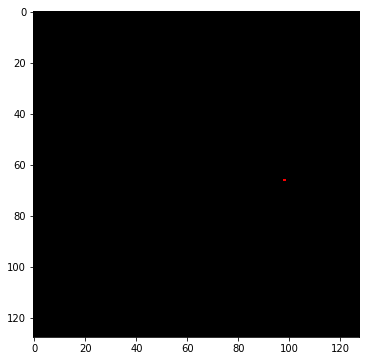

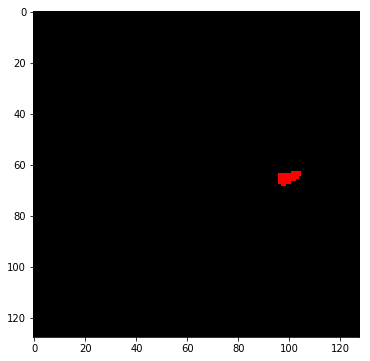

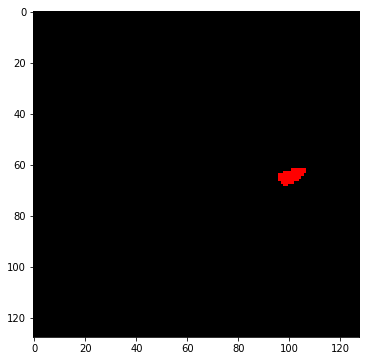

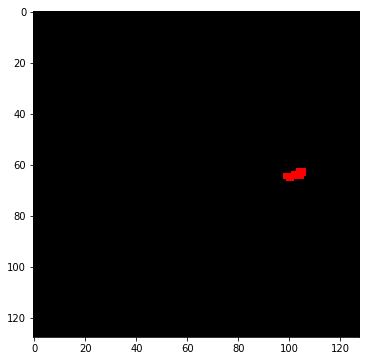

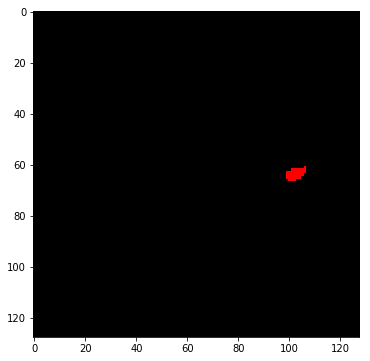

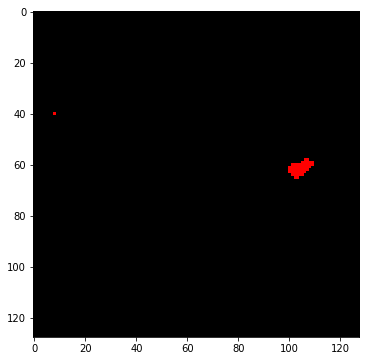

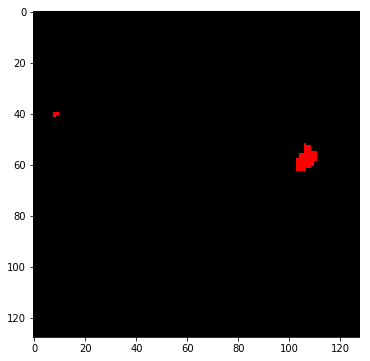

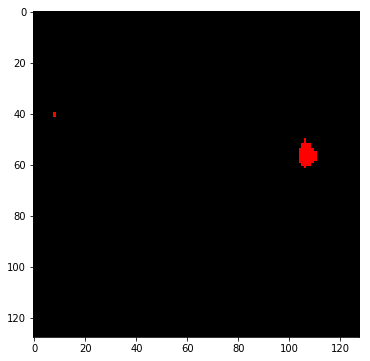

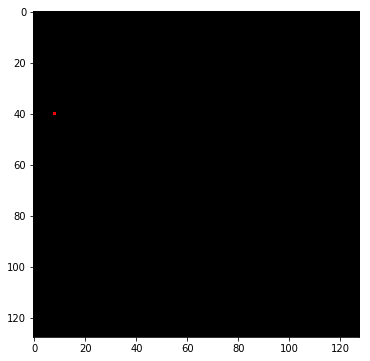

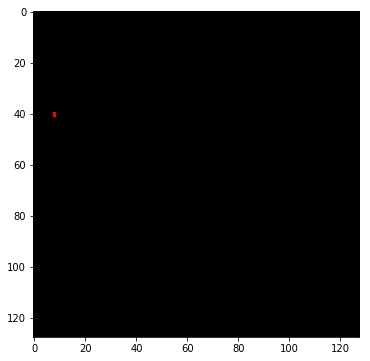

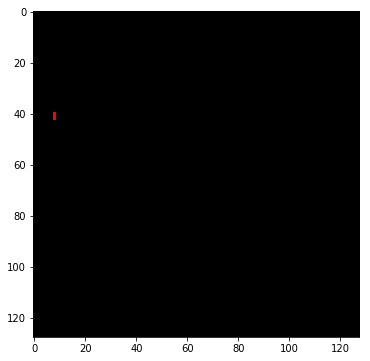

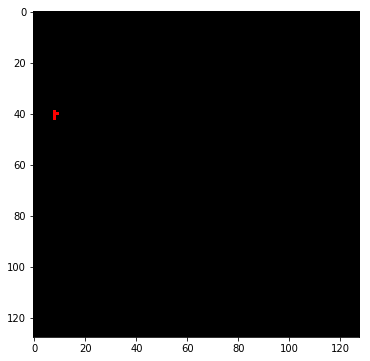

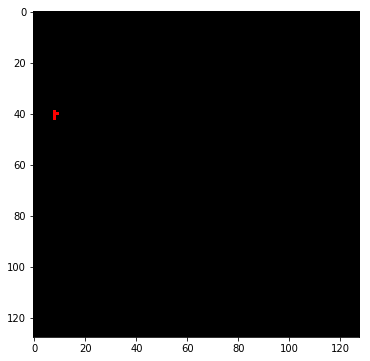

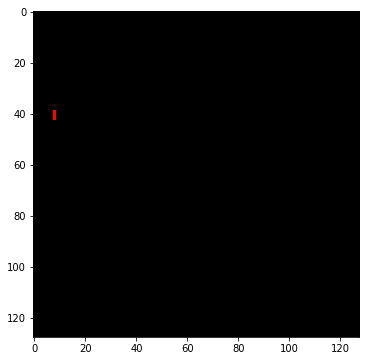

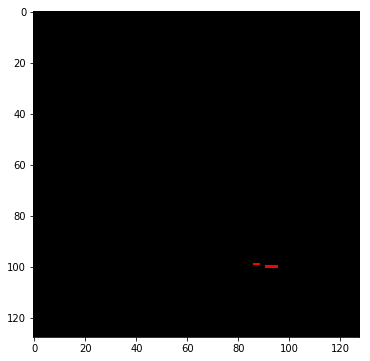

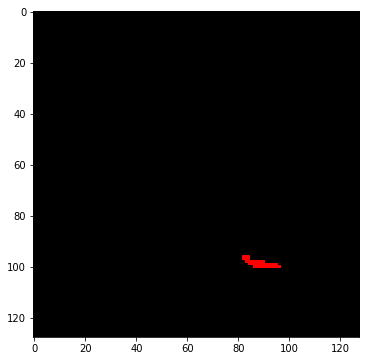

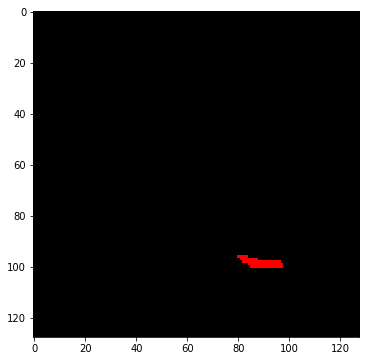

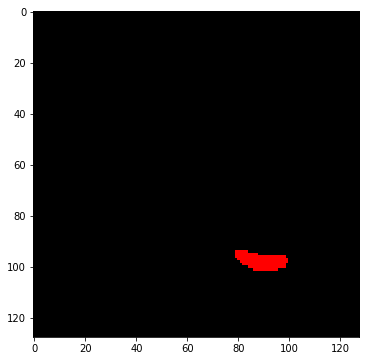

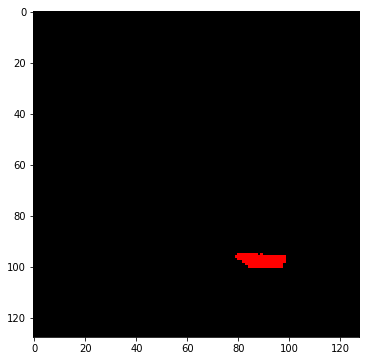

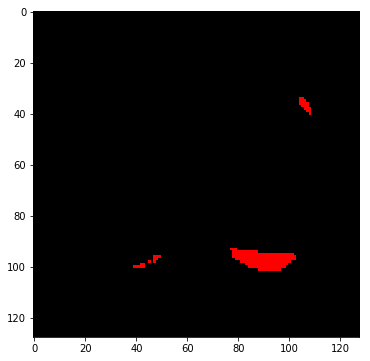

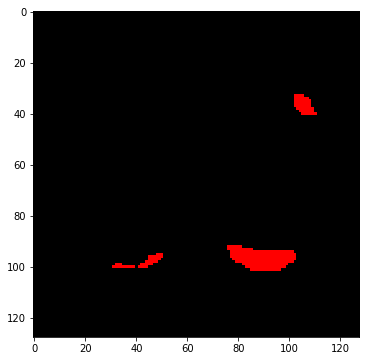

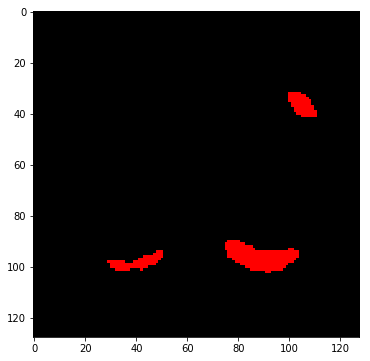

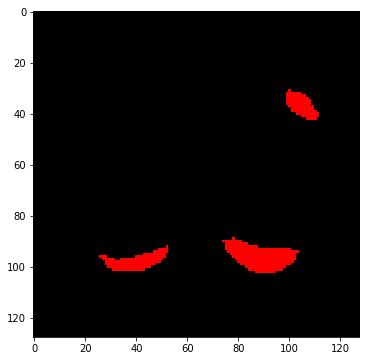

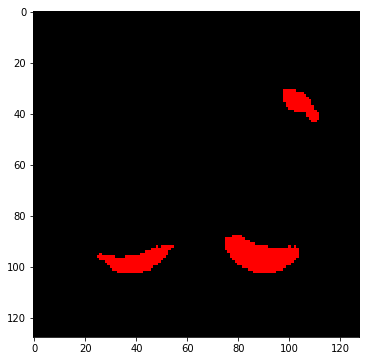

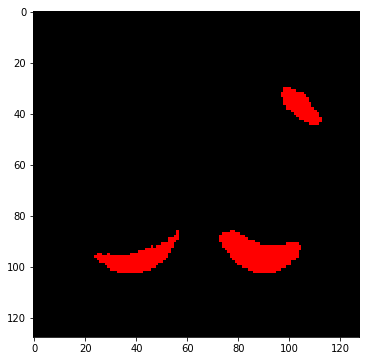

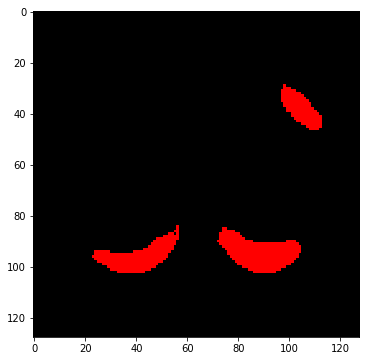

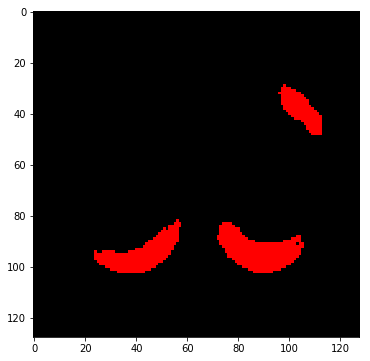

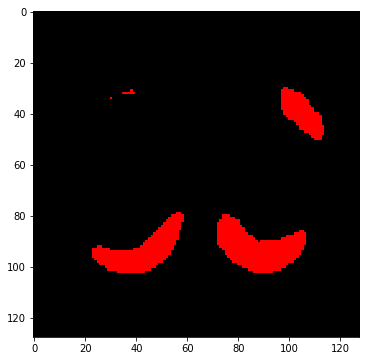

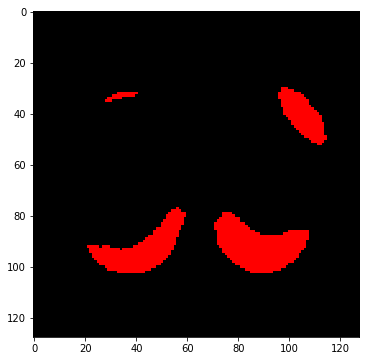

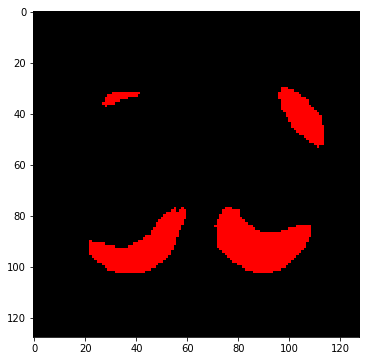

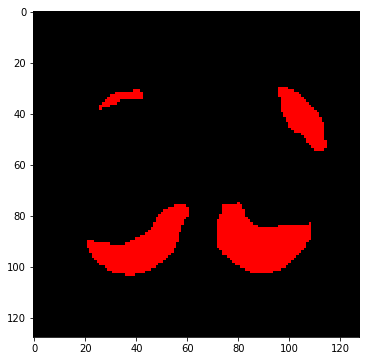

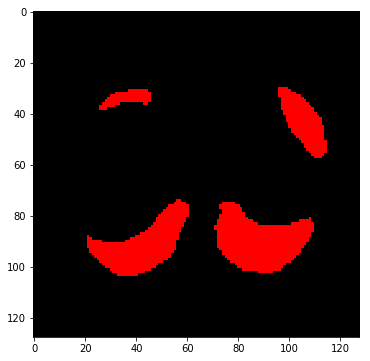

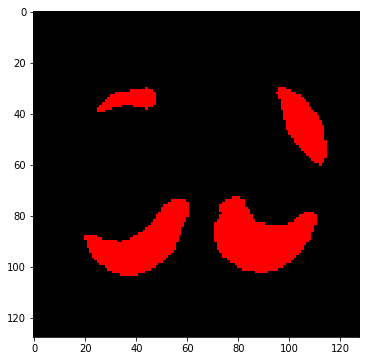

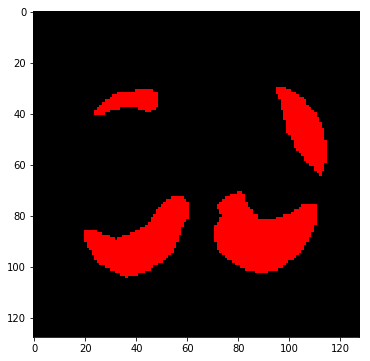

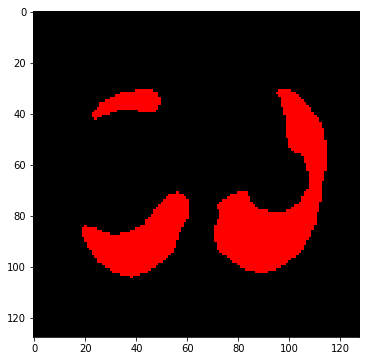

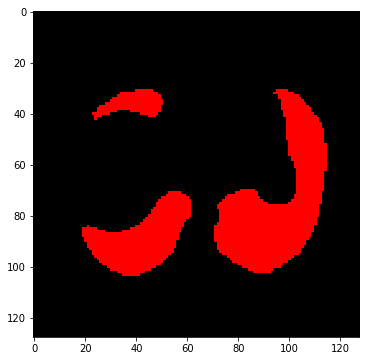

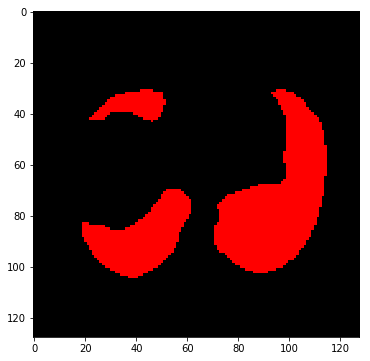

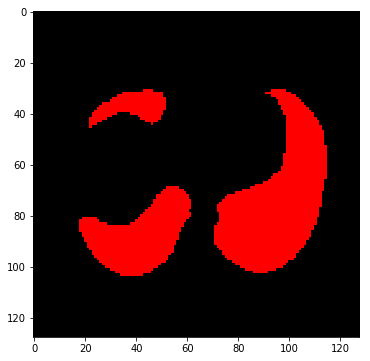

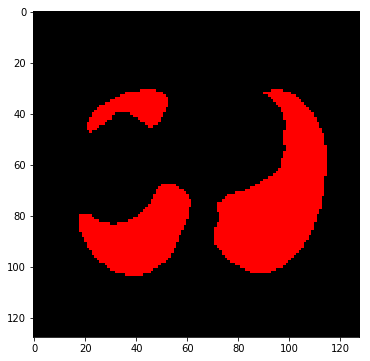

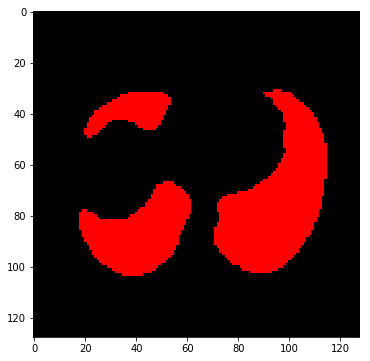

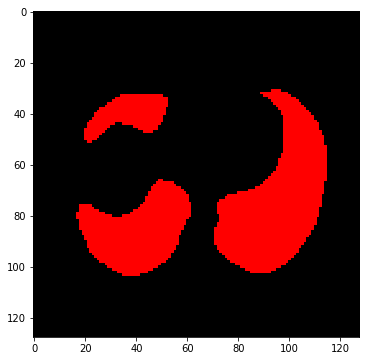

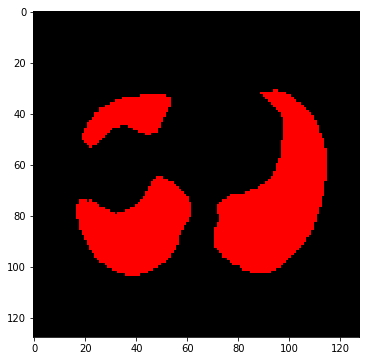

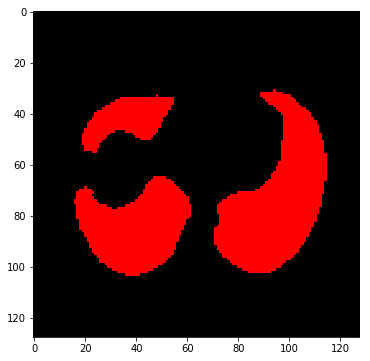

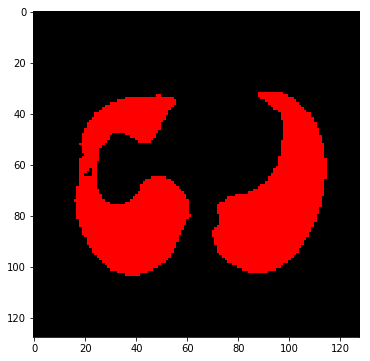

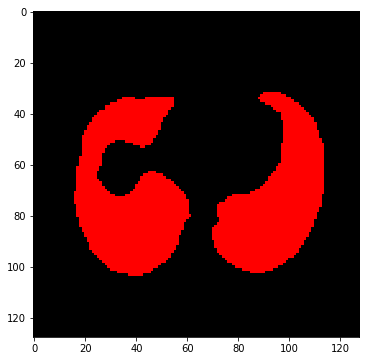

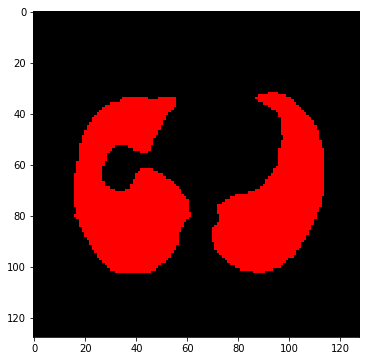

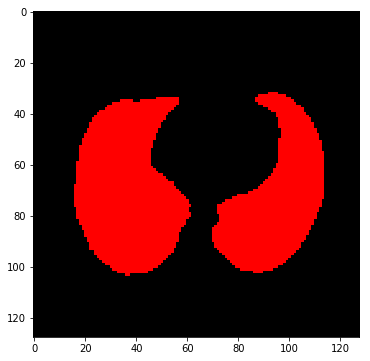

In [16]:
for k in range(286):
    for i in range(128):
        for j in range(128):
            pixel = a[k][i][j]
            if(pixel[0] == 1 and pixel[1] == 1 and pixel[2] == 1):#흰색이면
                pixel[0] = 255    #R
                pixel[1] = 0#G
                pixel[2] = 0 #B

                
import matplotlib.pyplot as plt
for i in range(0, 100, 2): # 0에서 160까지의 숫자를 10칸 간격으로 추출하겠다는 의미
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(a[i])
 
    plt.show()

C:\Users\juhee\AppData\Local\conda\conda\envs\venv\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


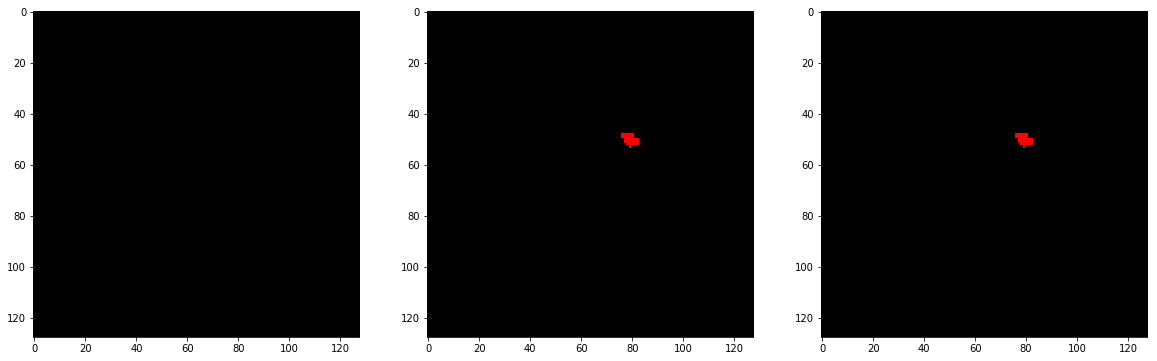

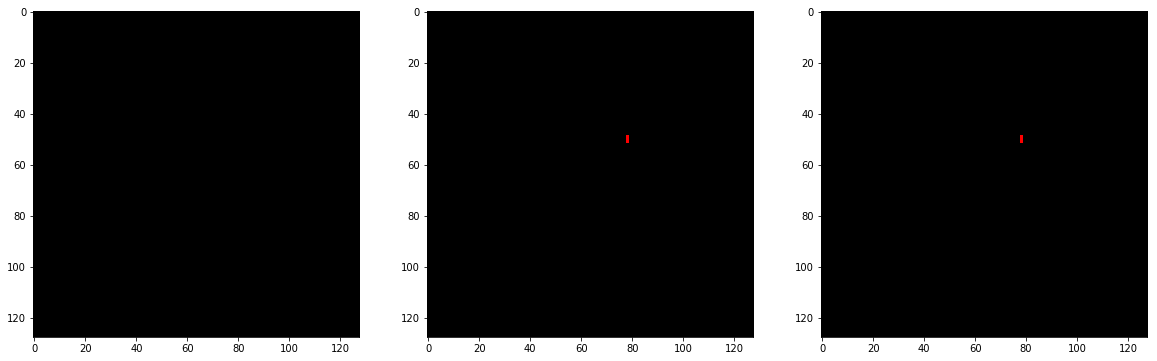

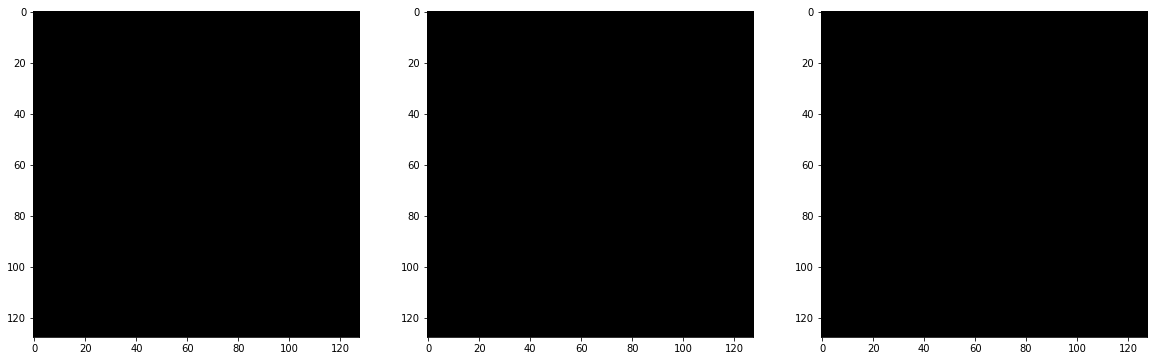

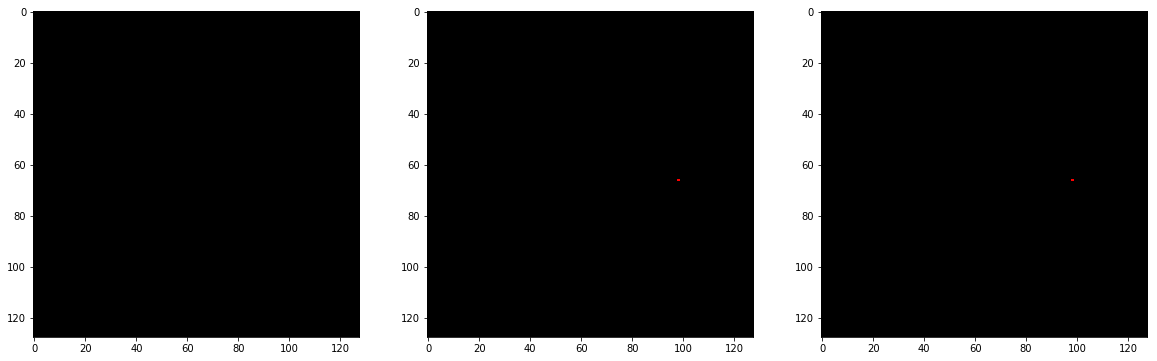

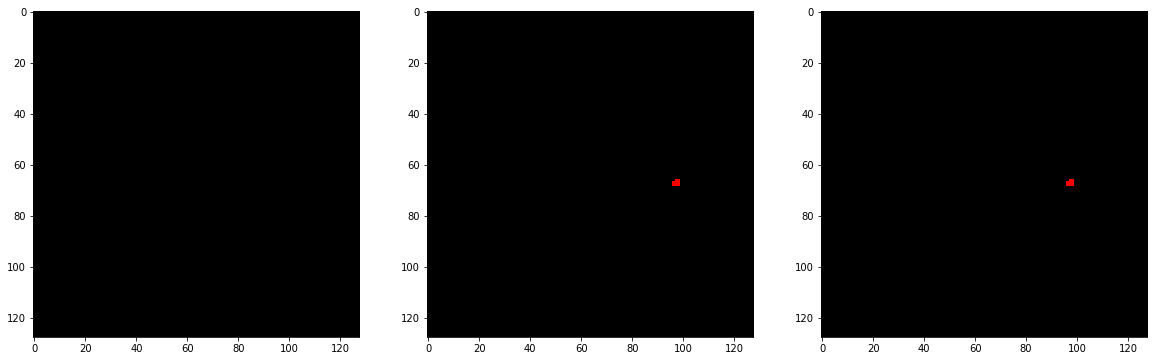

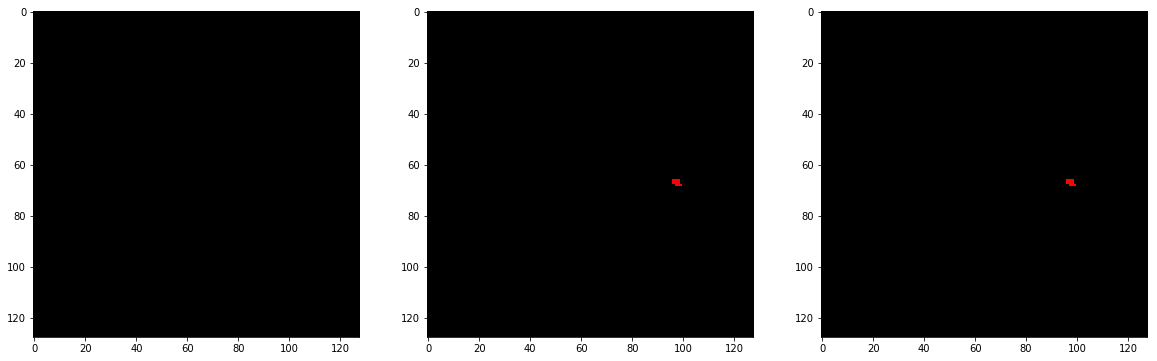

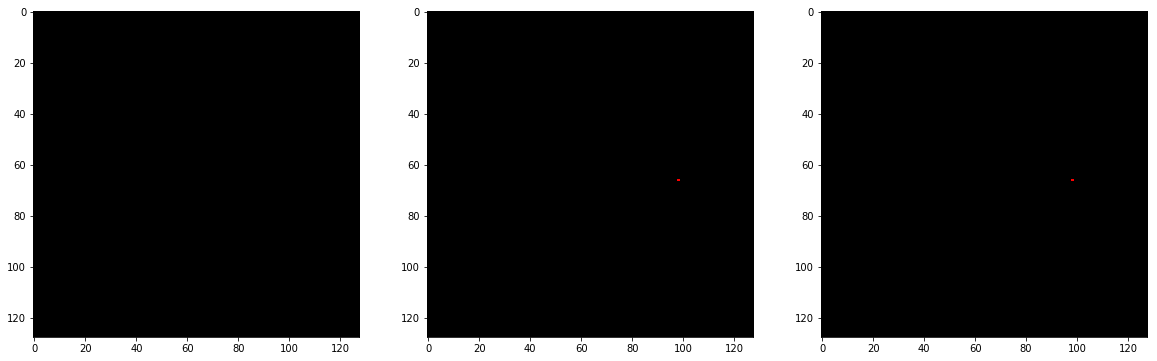

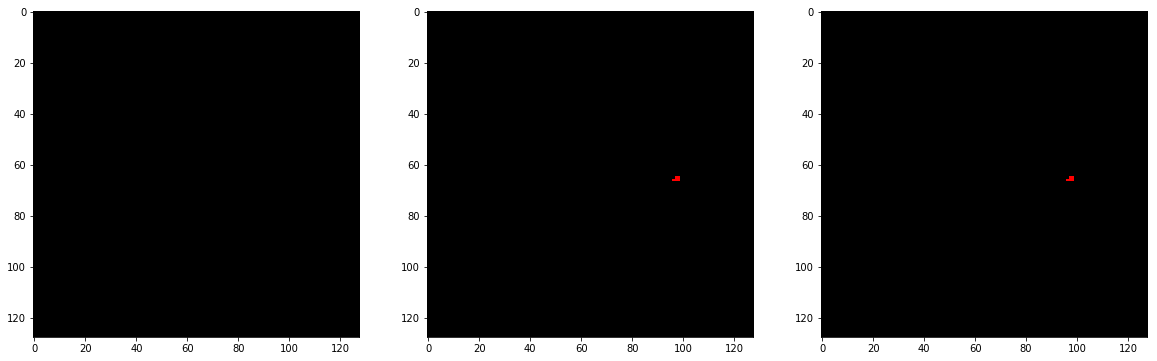

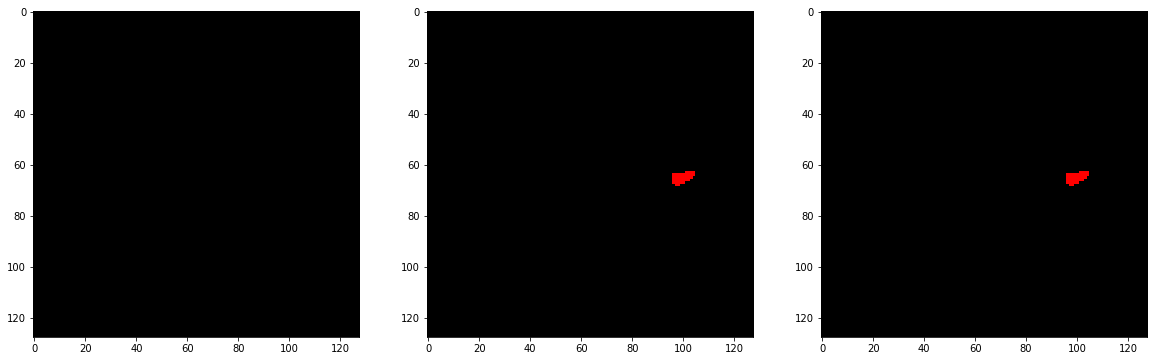

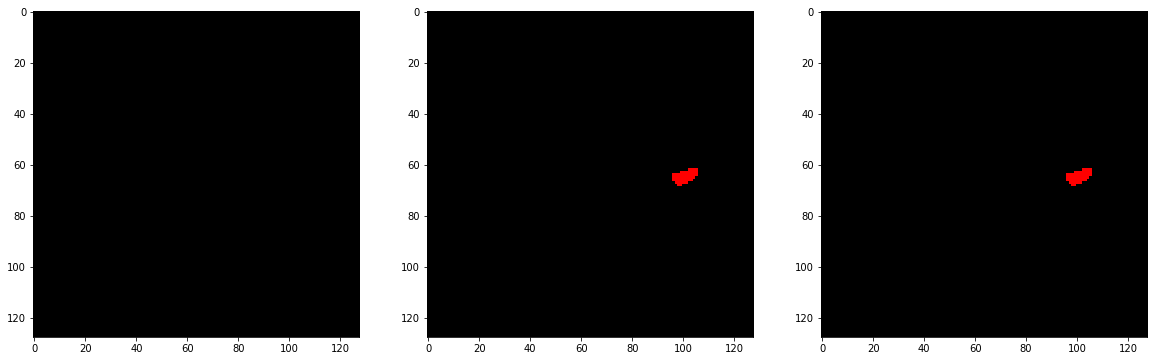

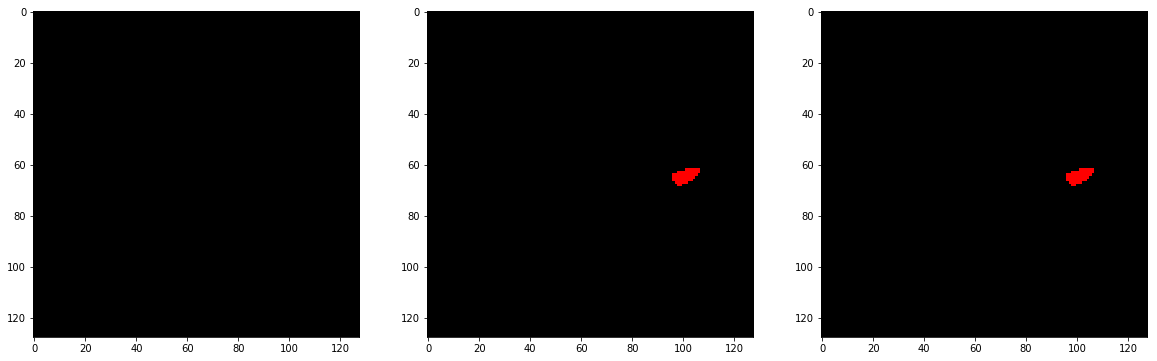

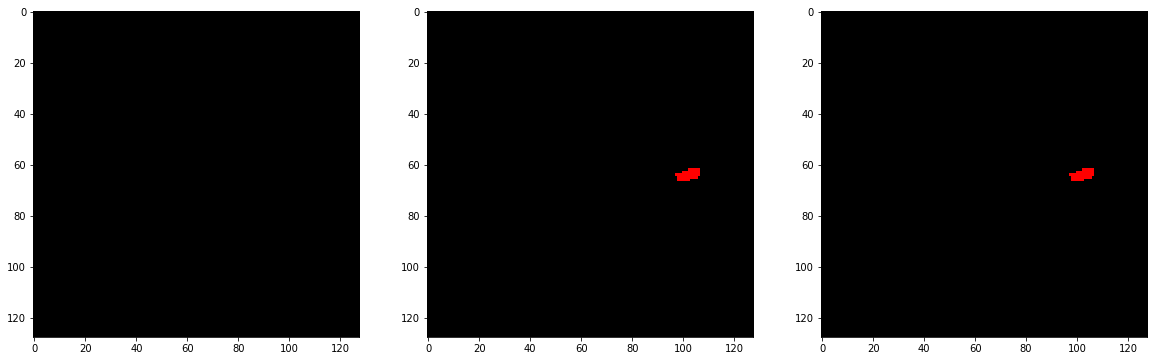

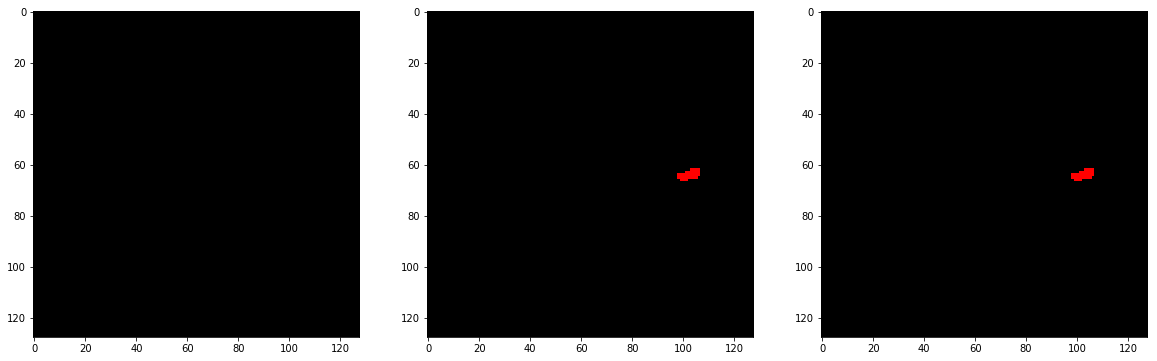

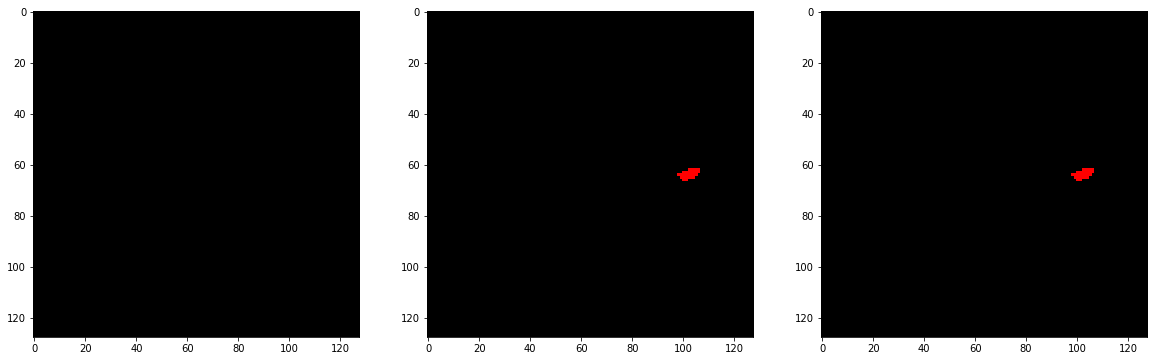

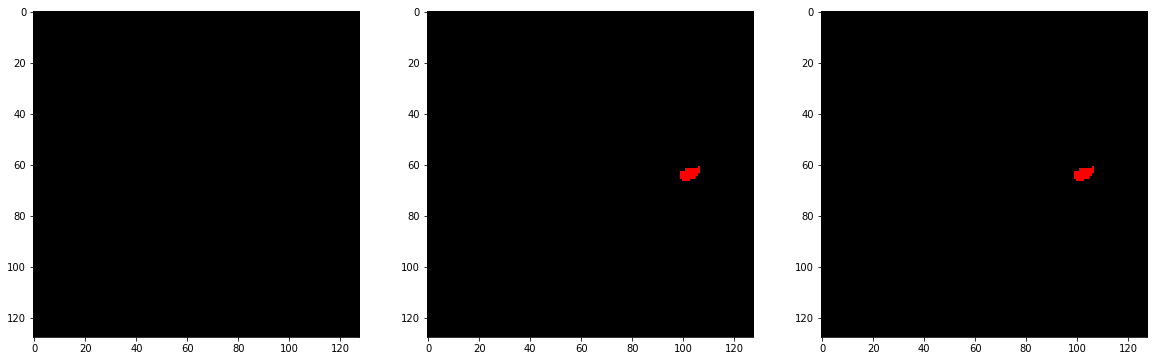

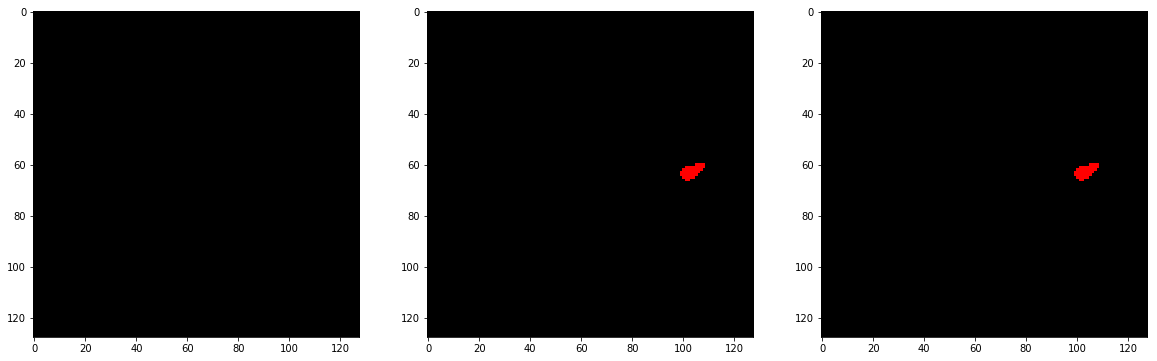

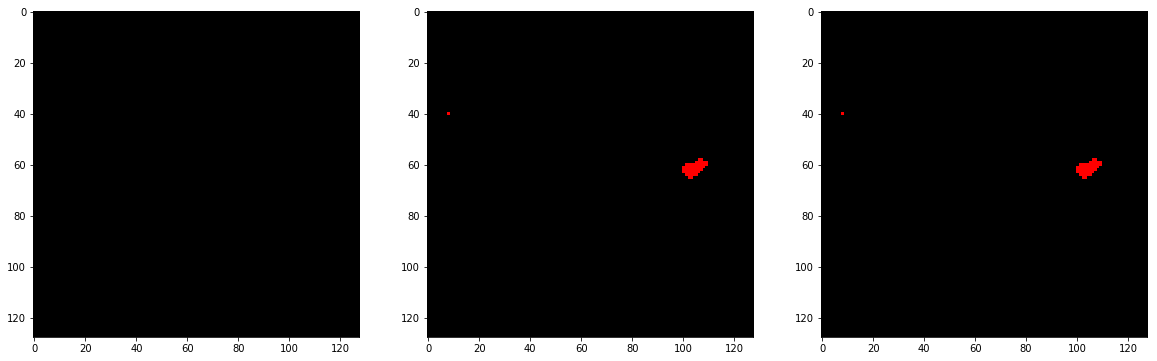

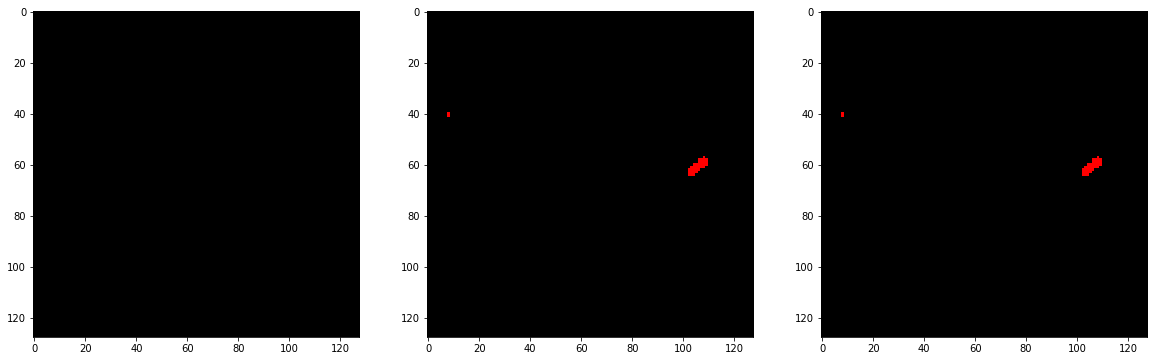

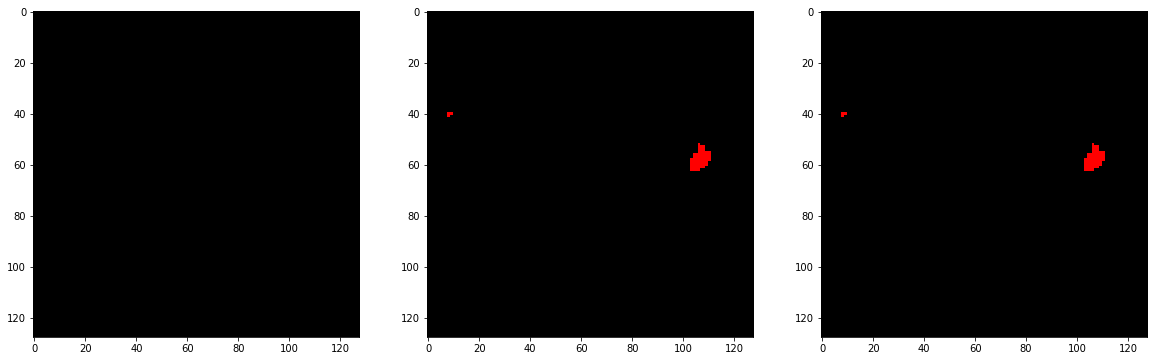

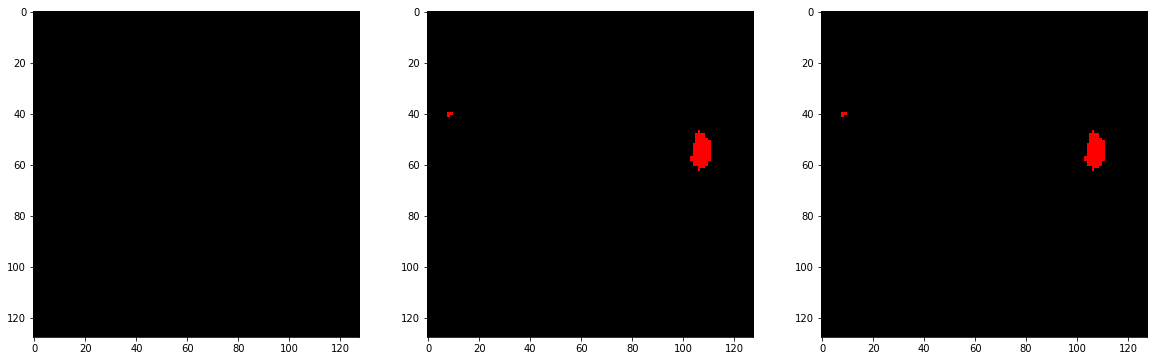

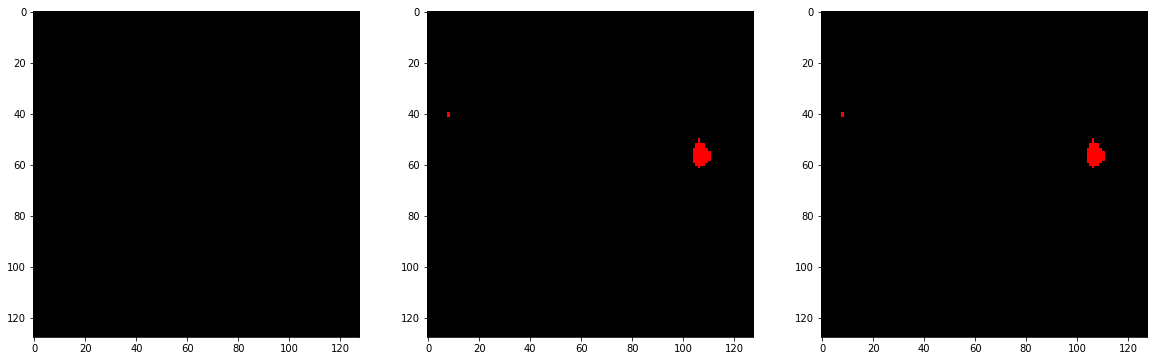

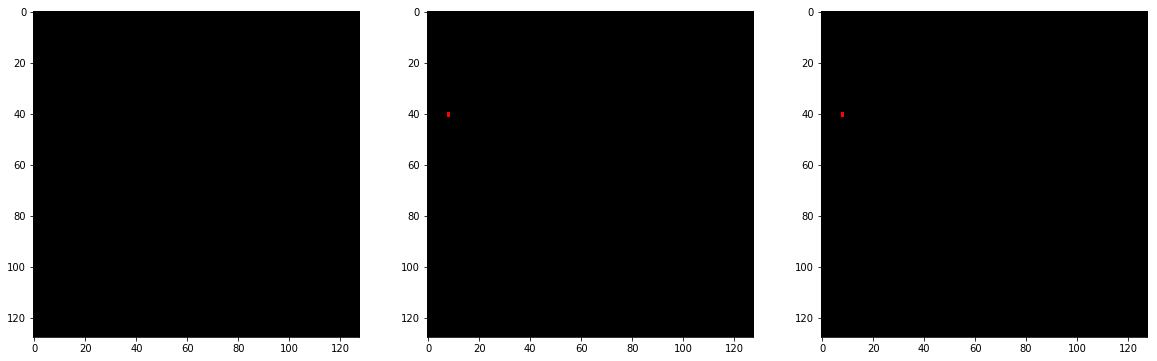

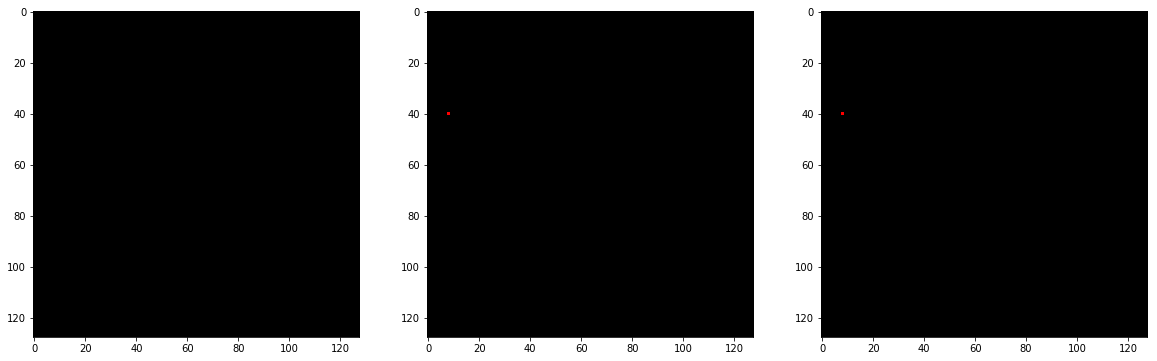

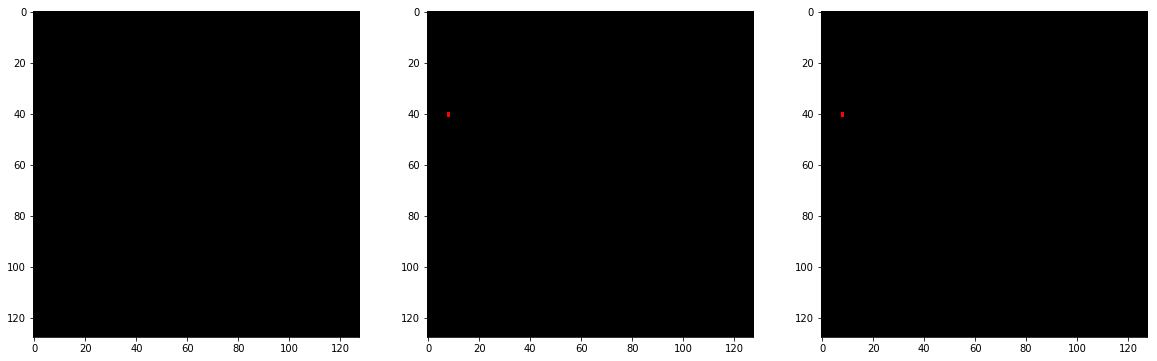

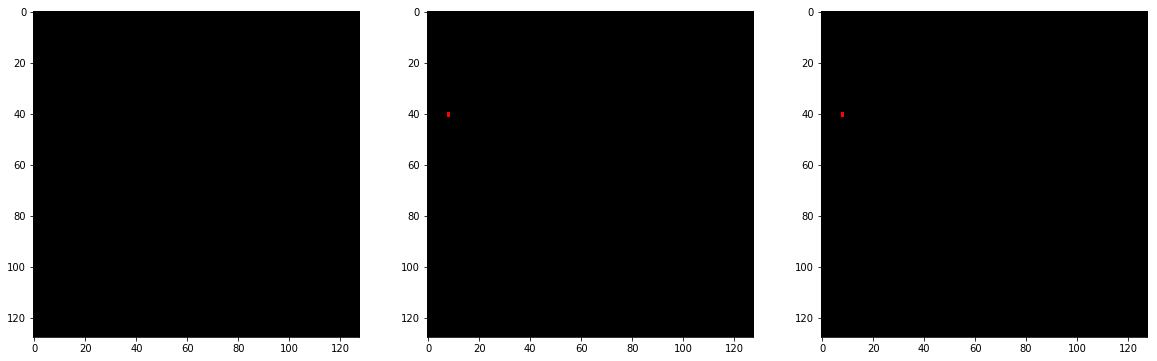

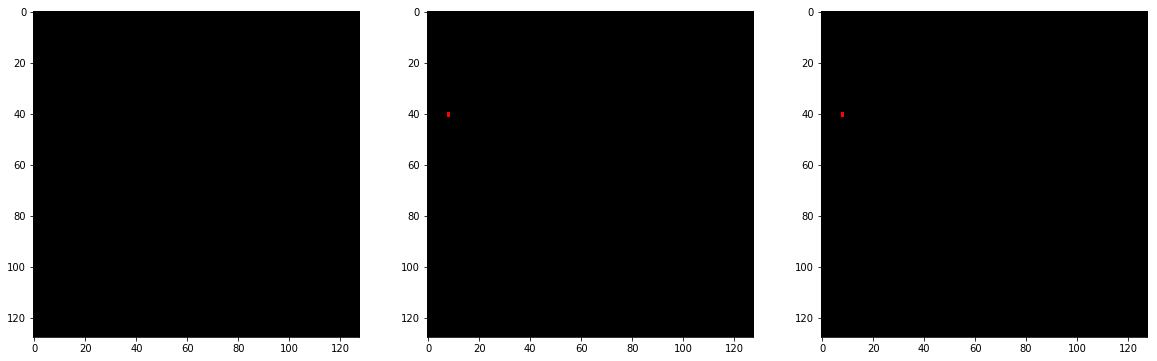

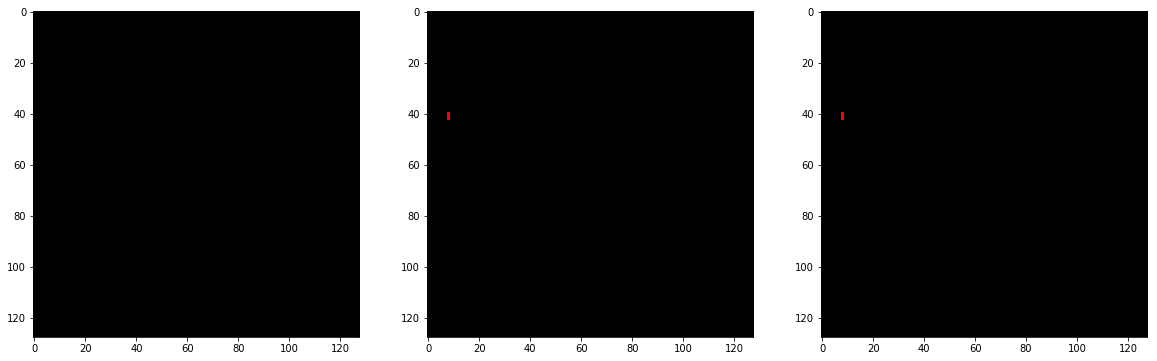

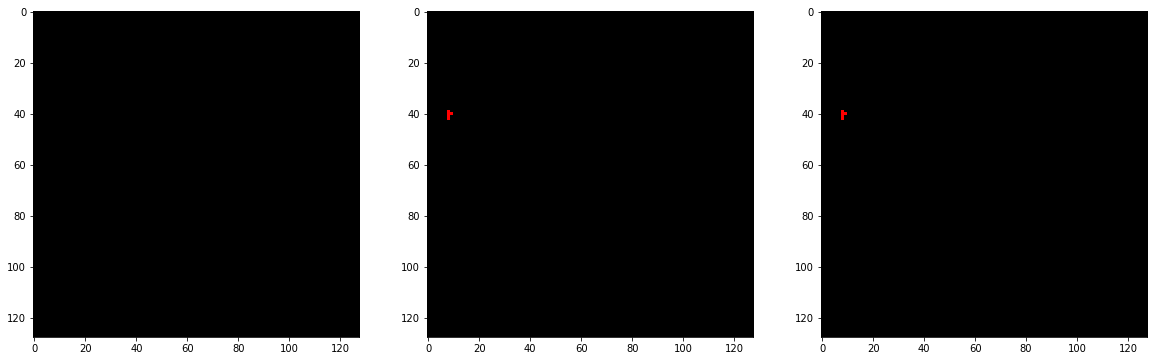

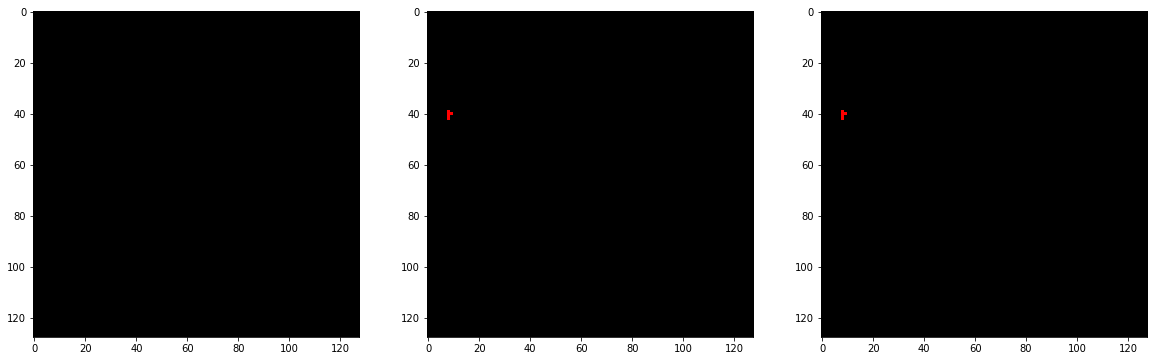

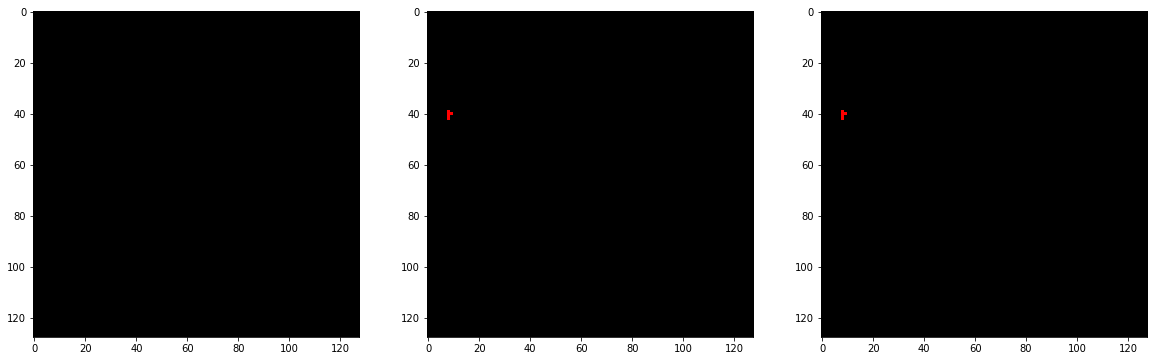

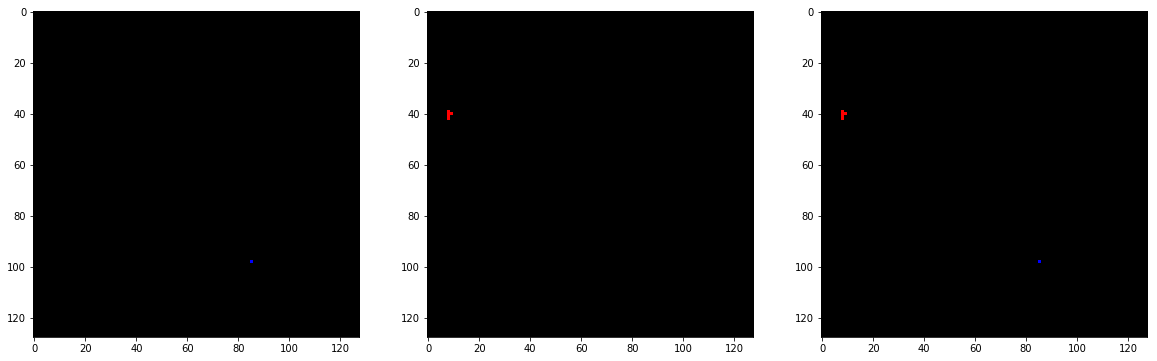

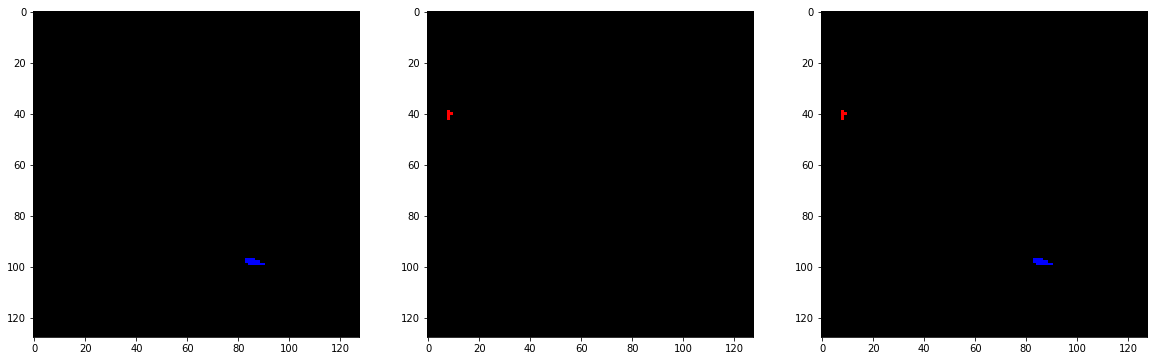

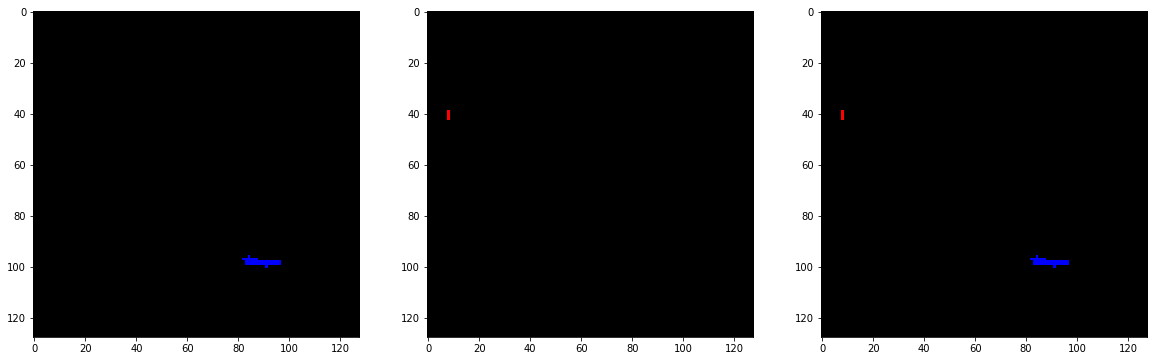

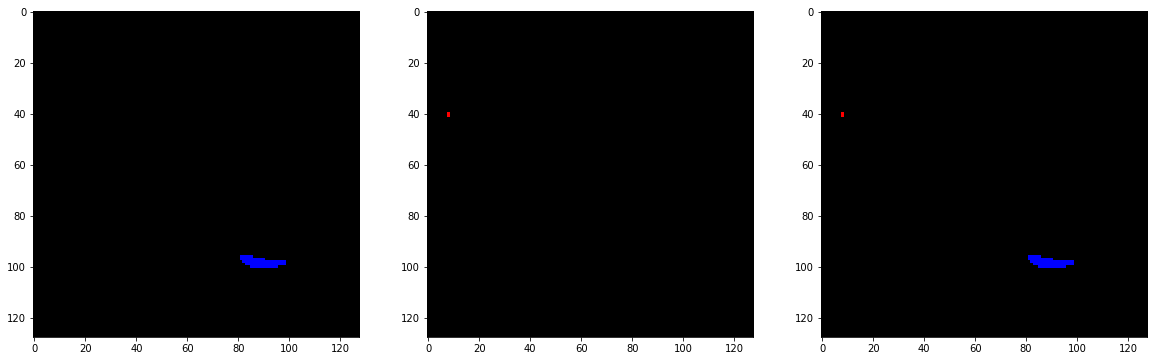

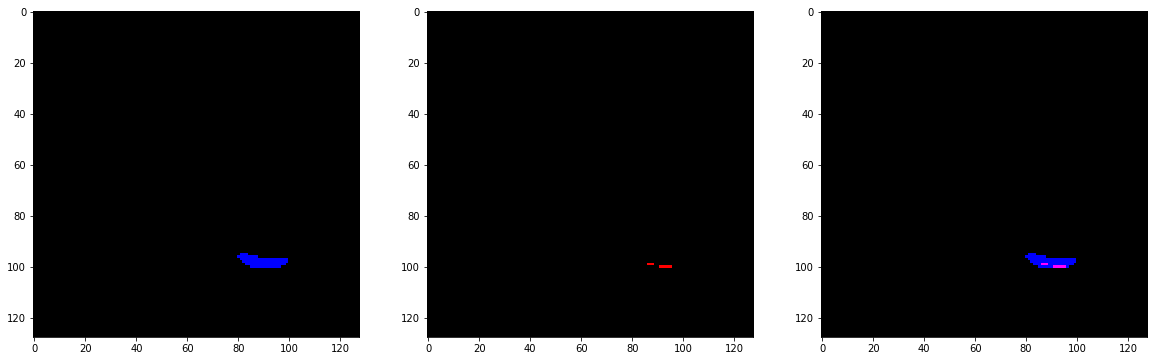

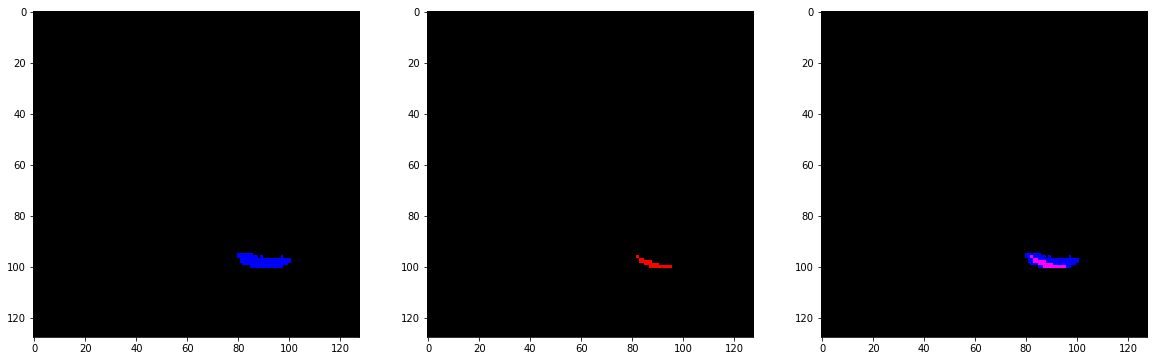

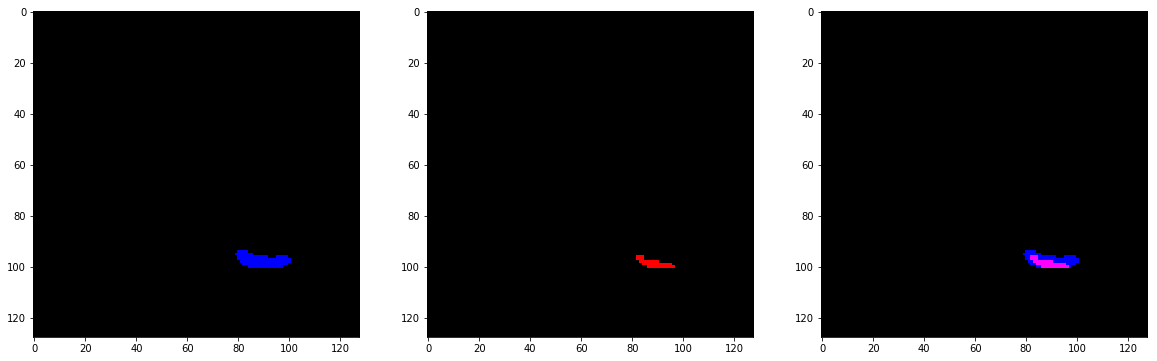

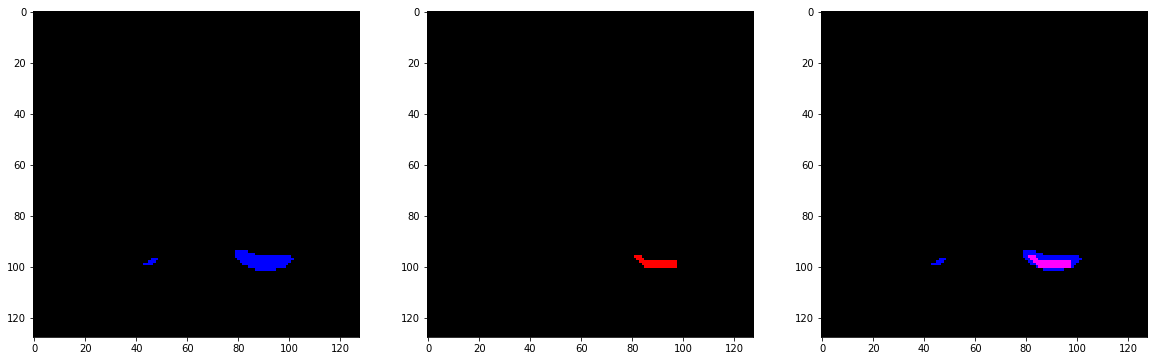

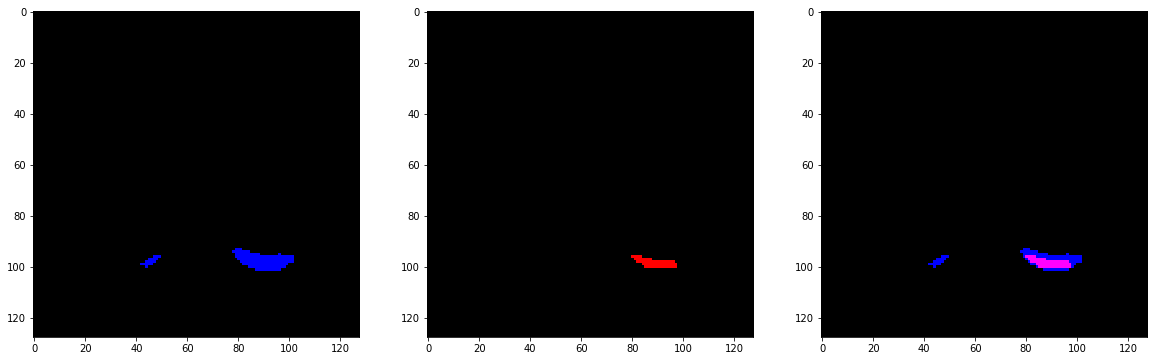

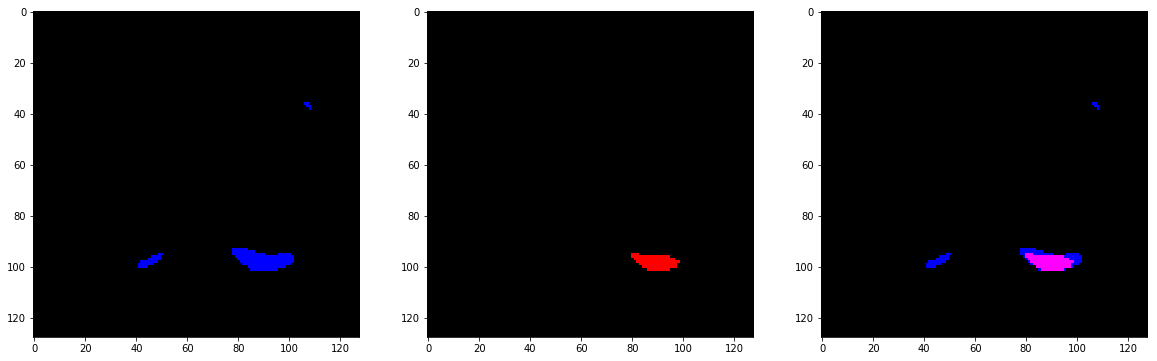

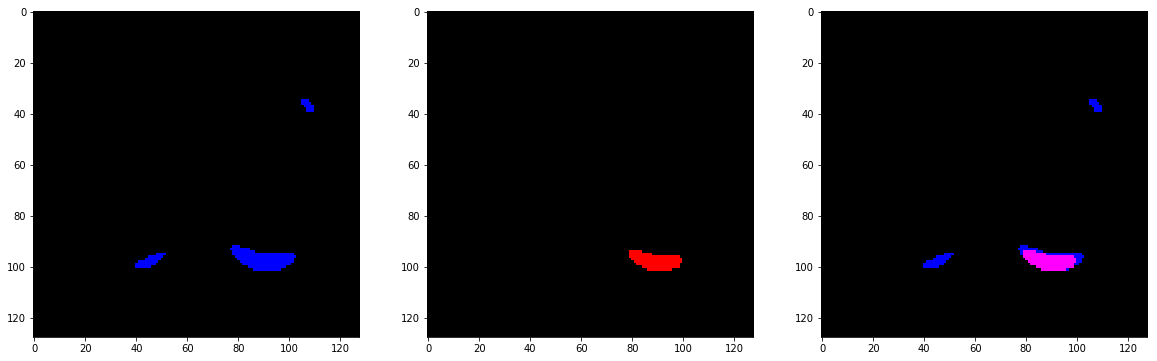

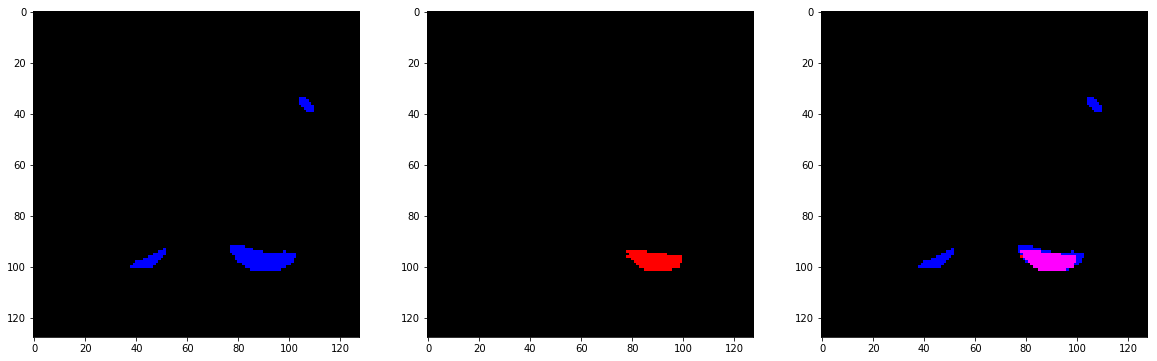

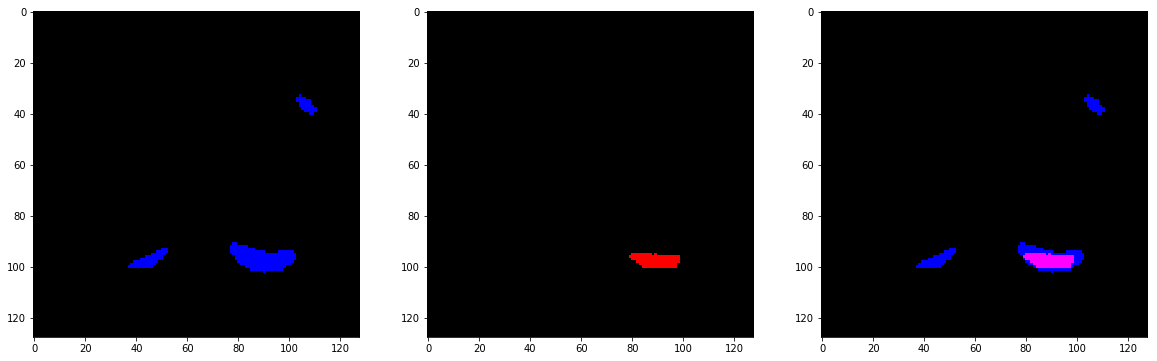

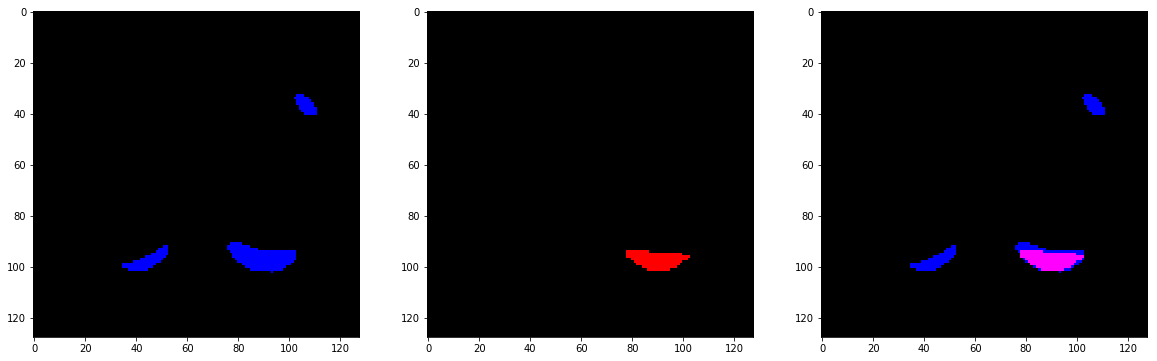

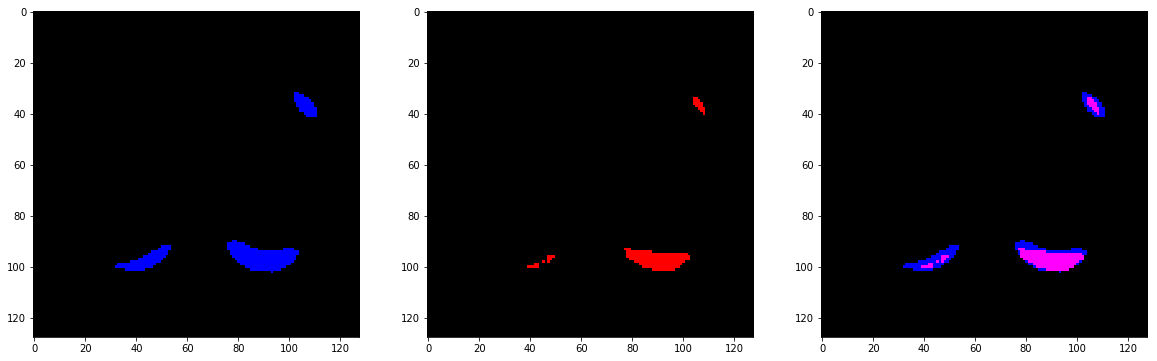

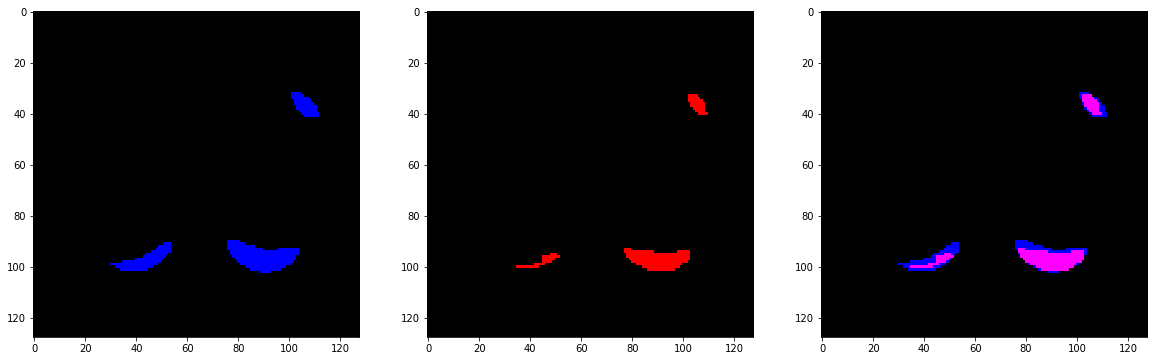

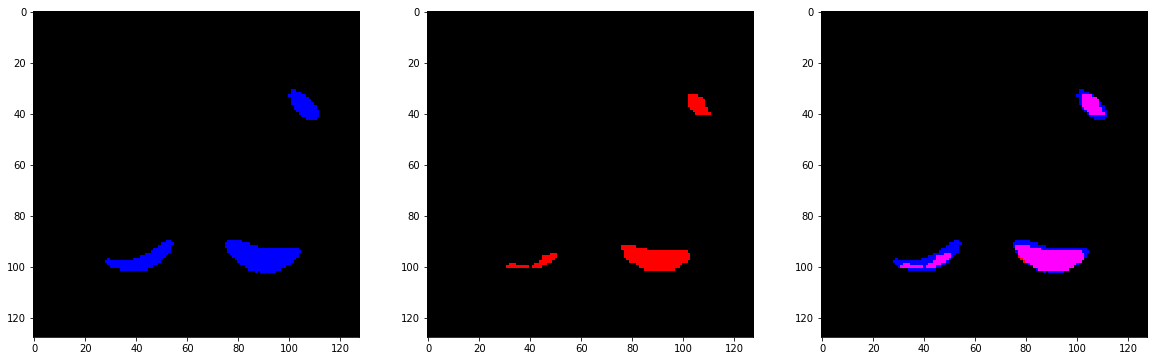

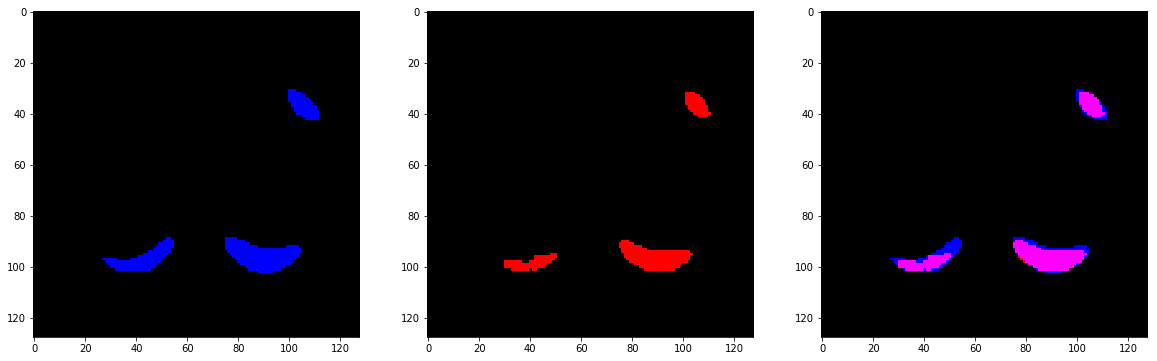

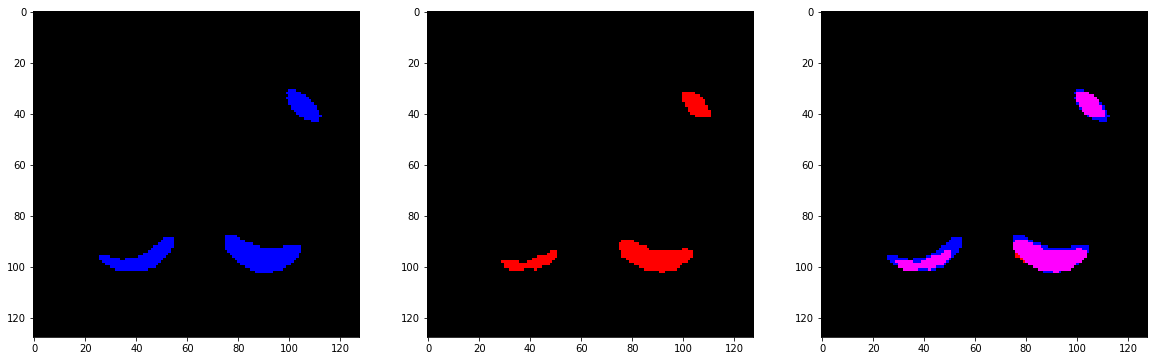

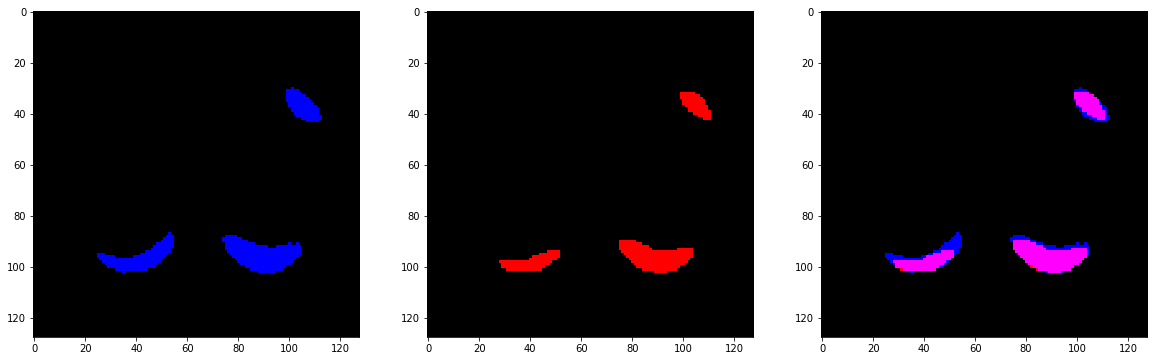

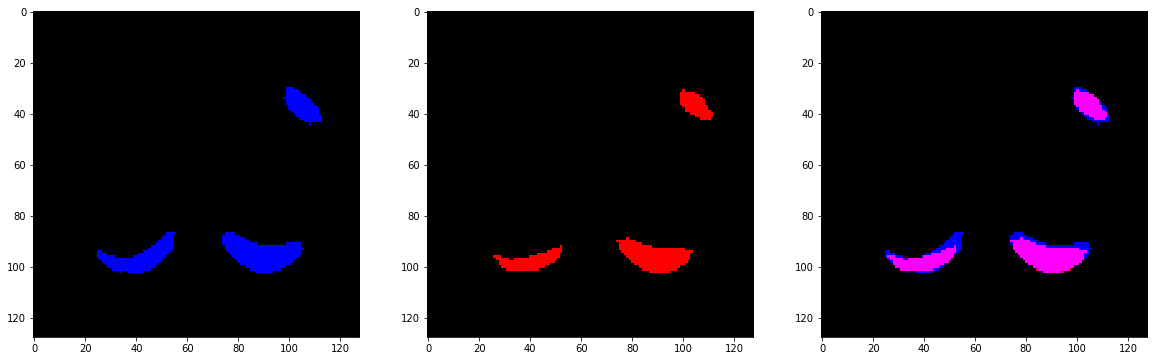

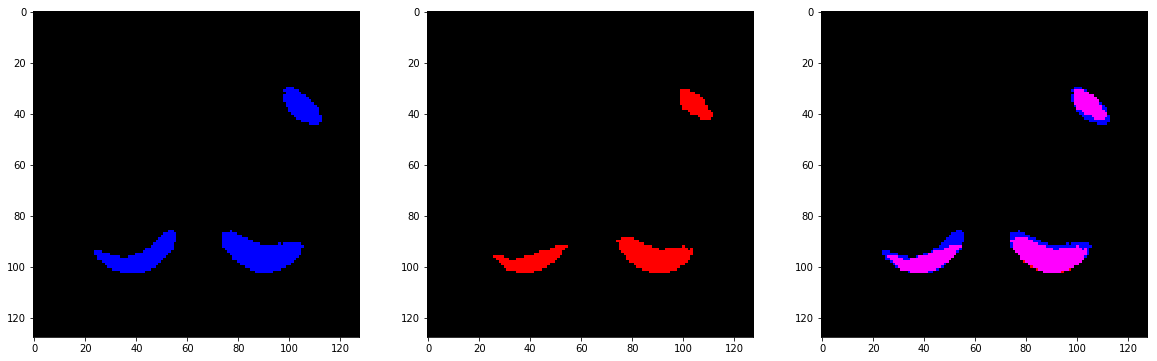

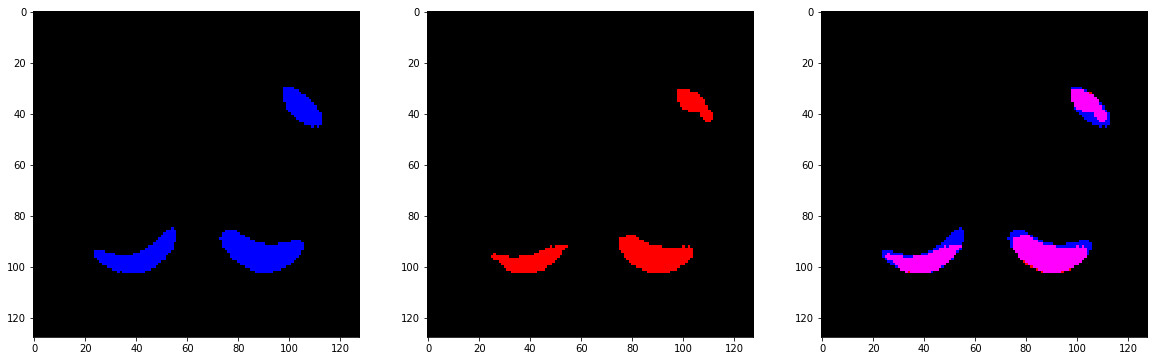

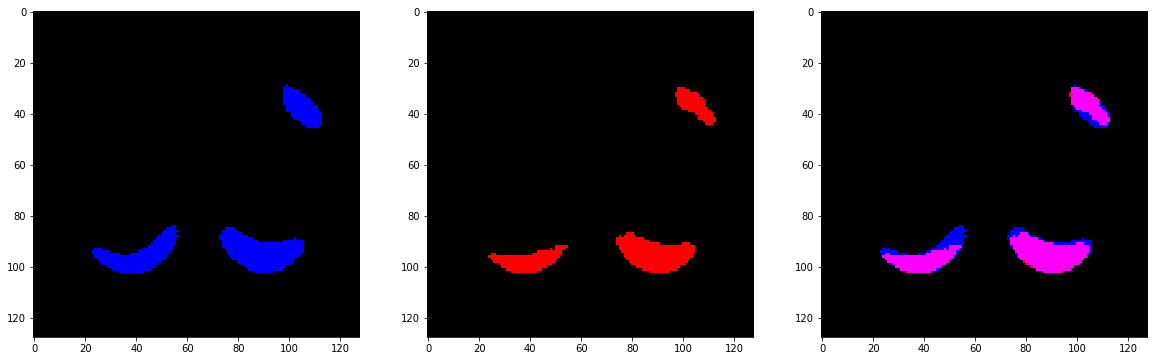

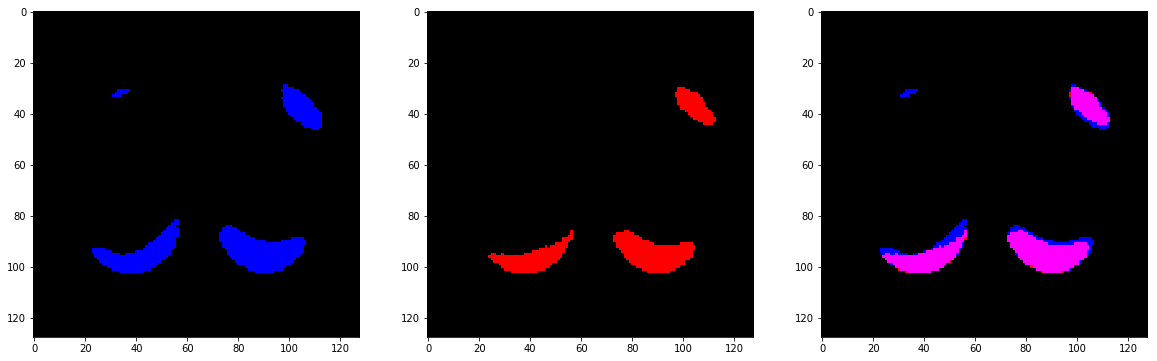

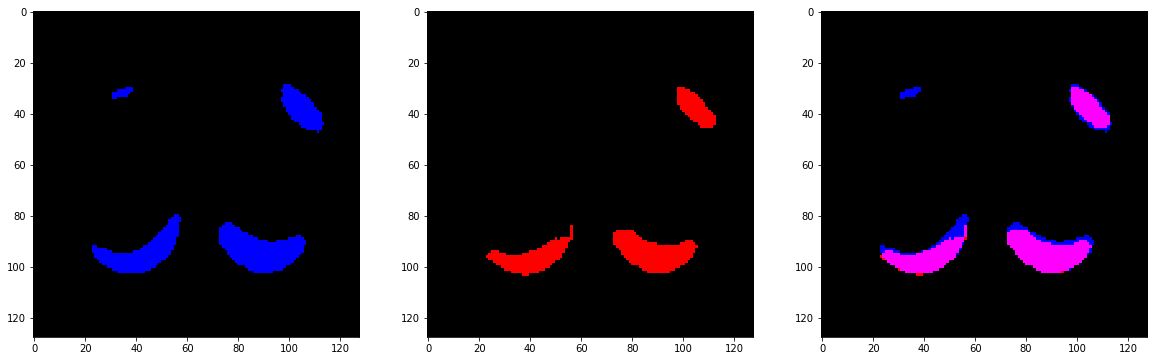

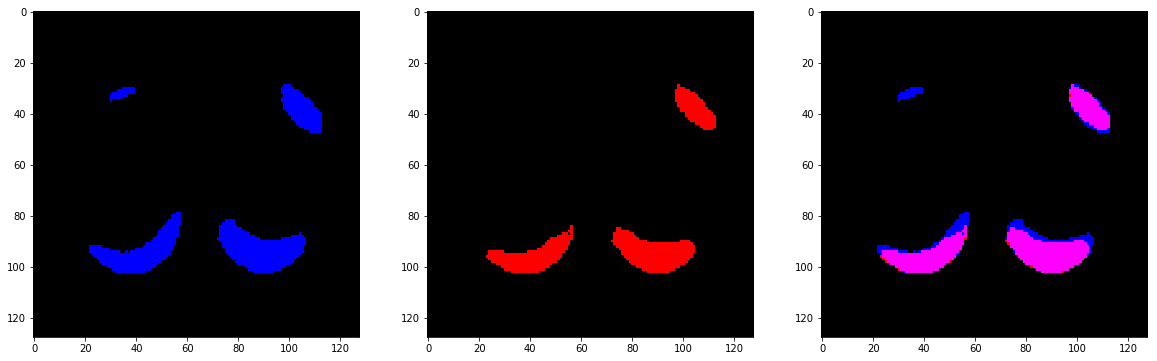

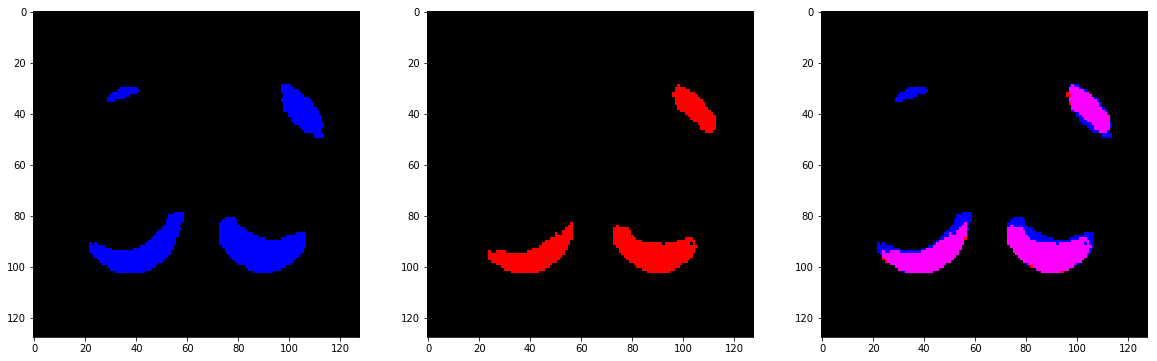

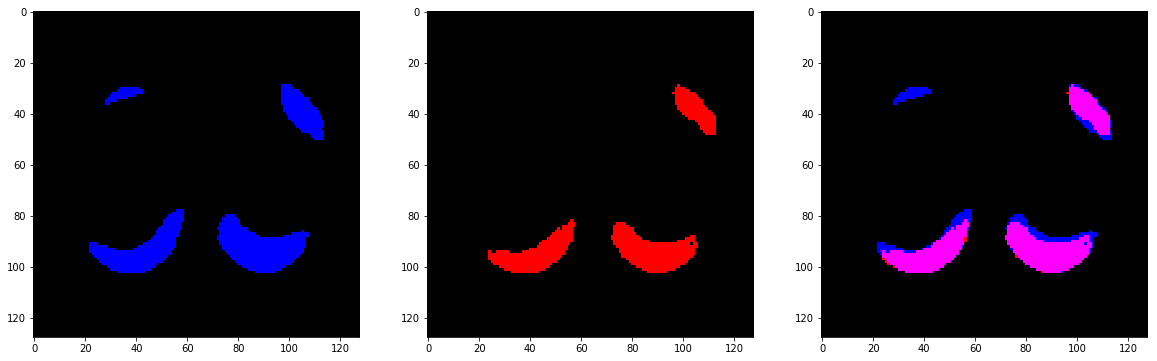

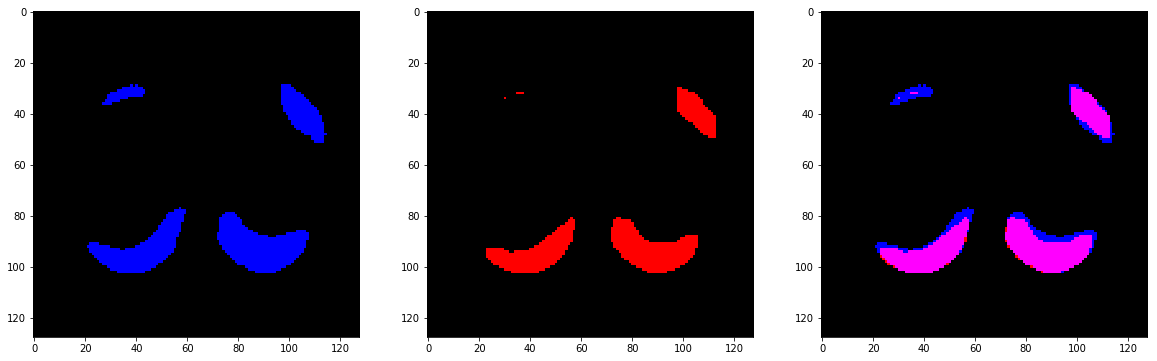

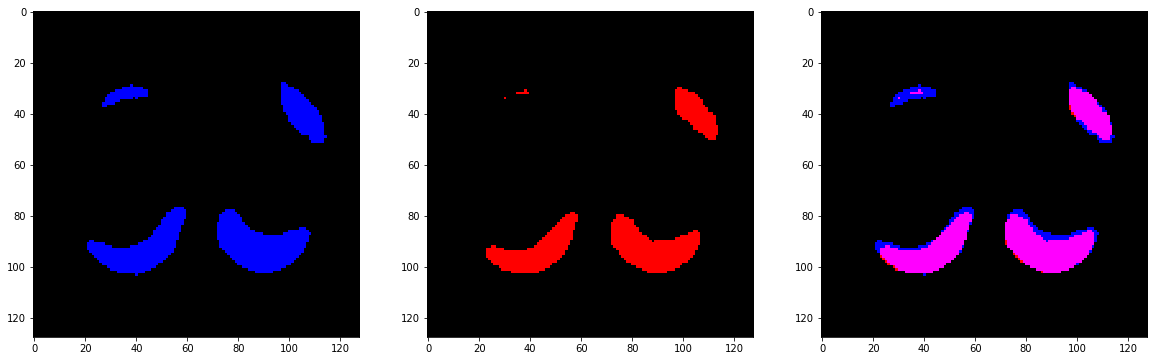

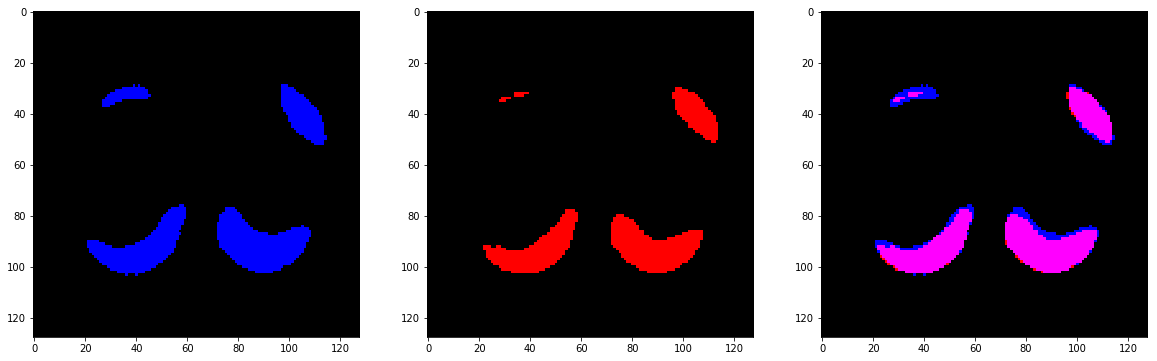

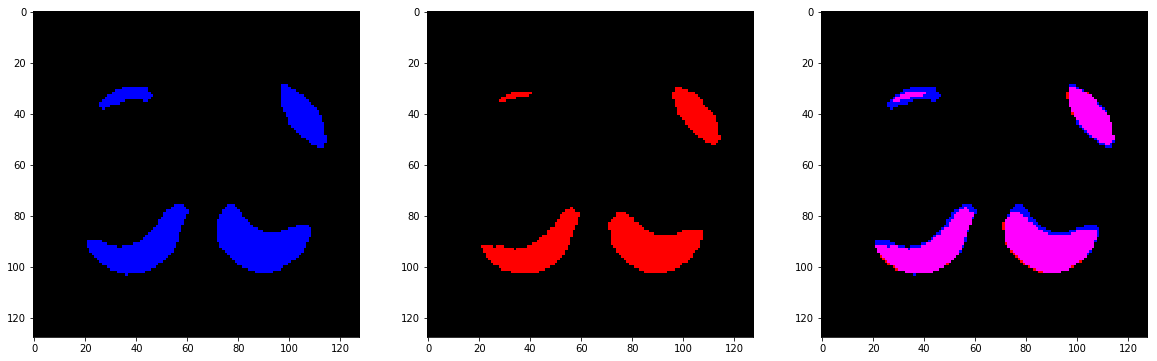

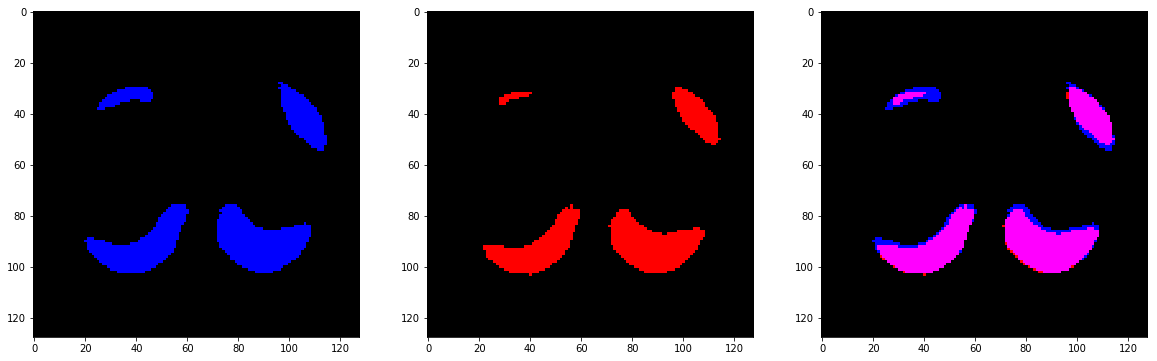

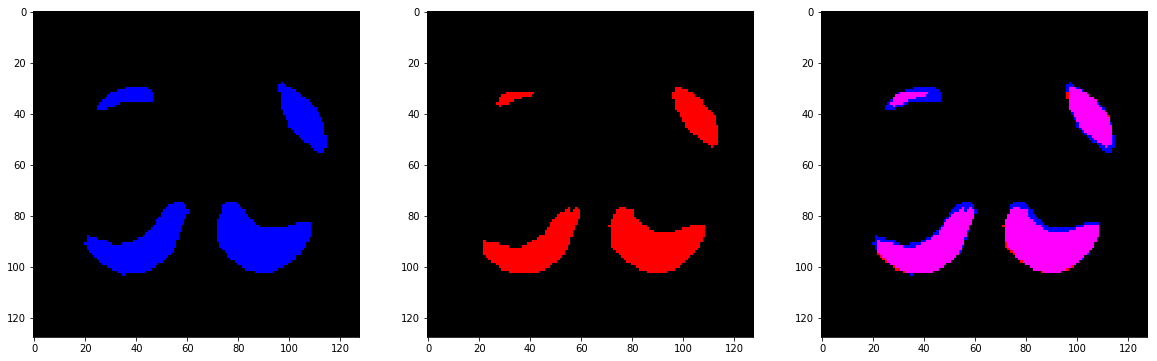

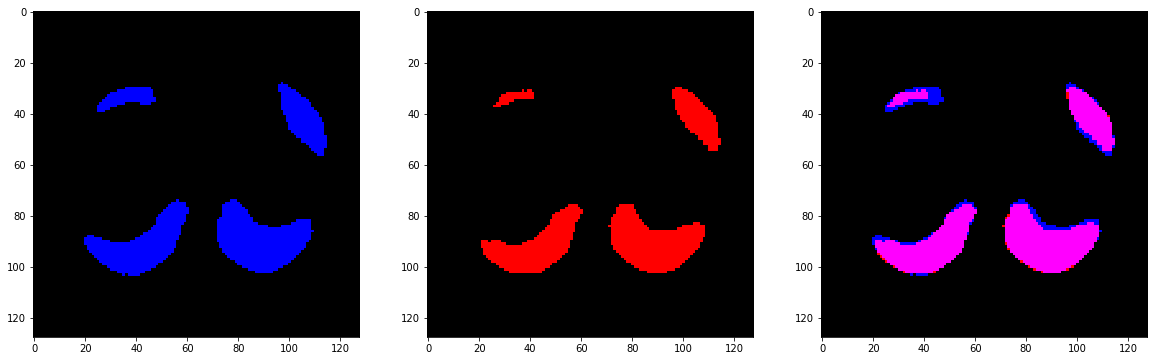

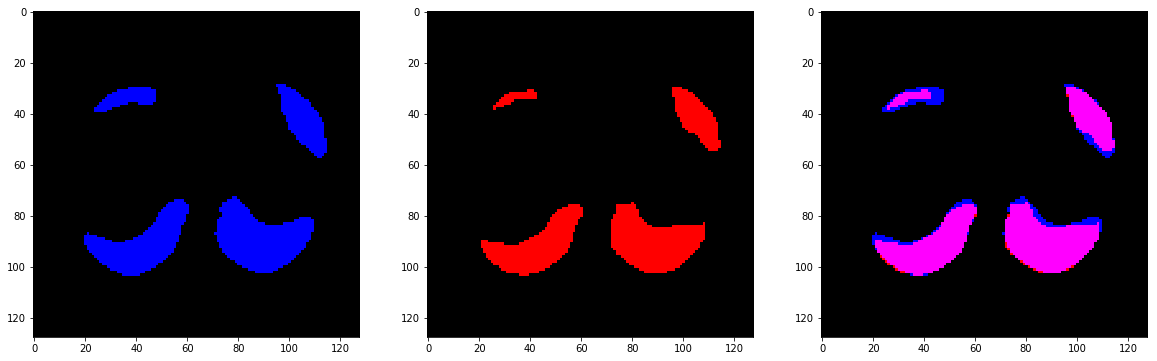

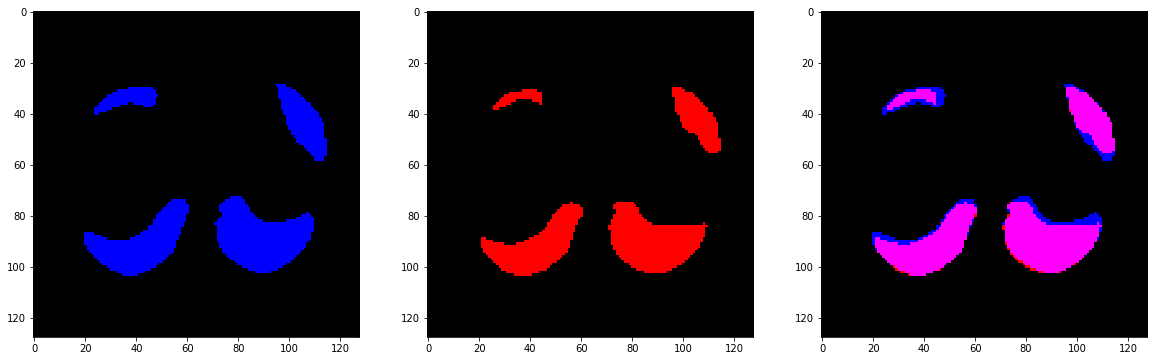

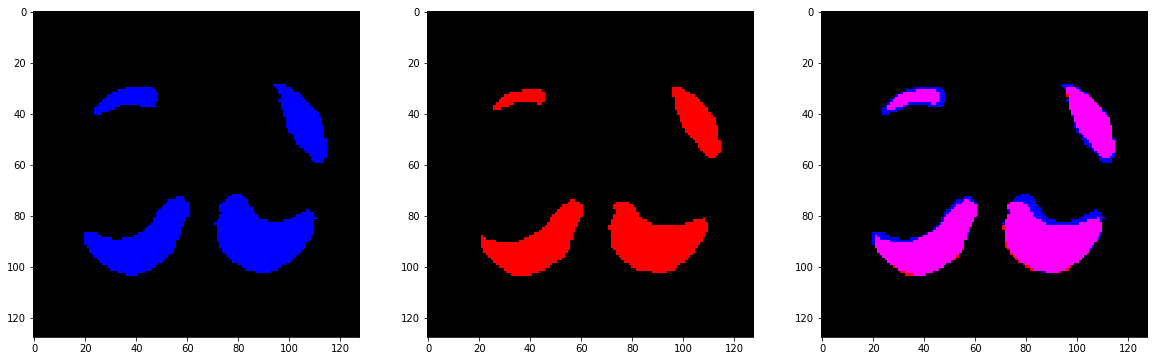

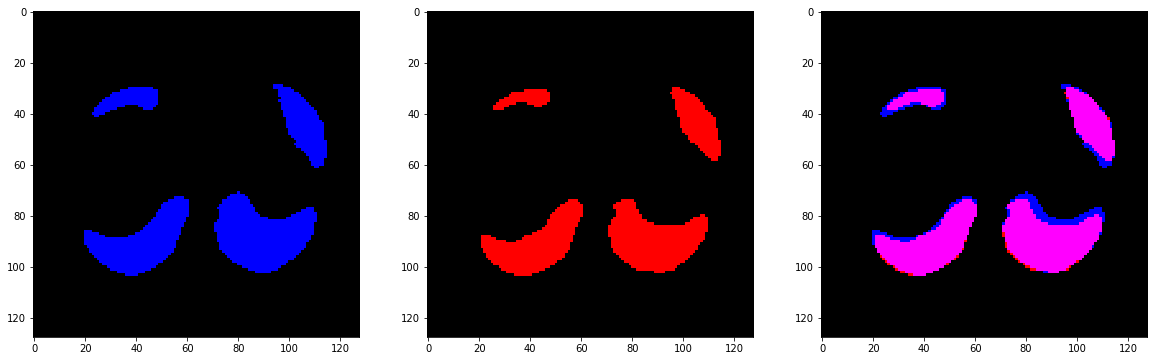

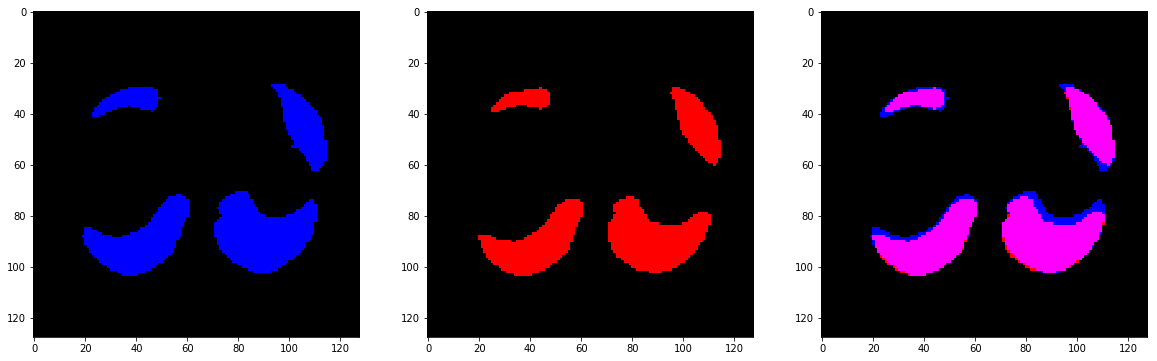

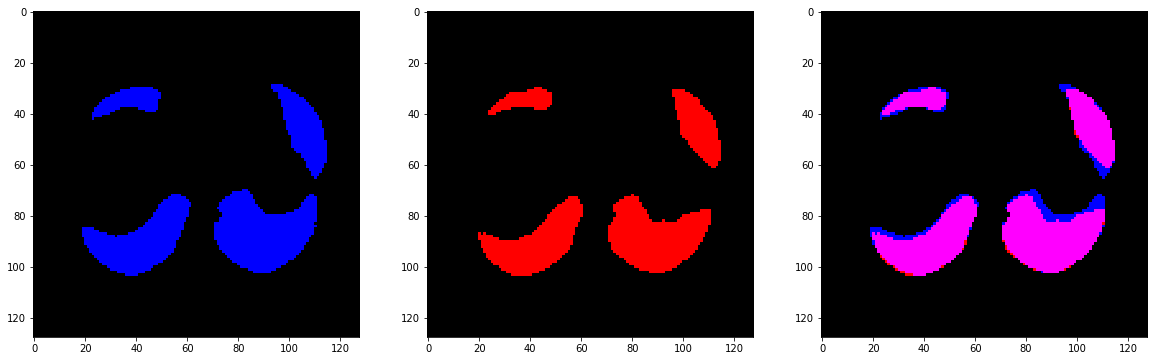

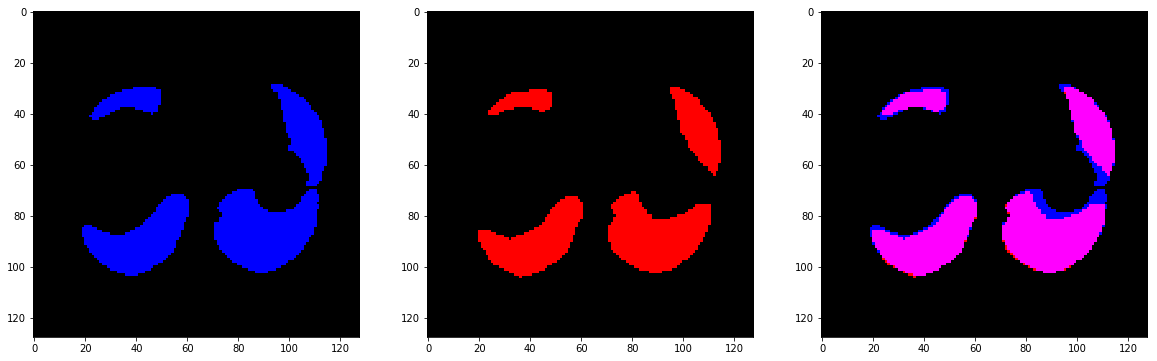

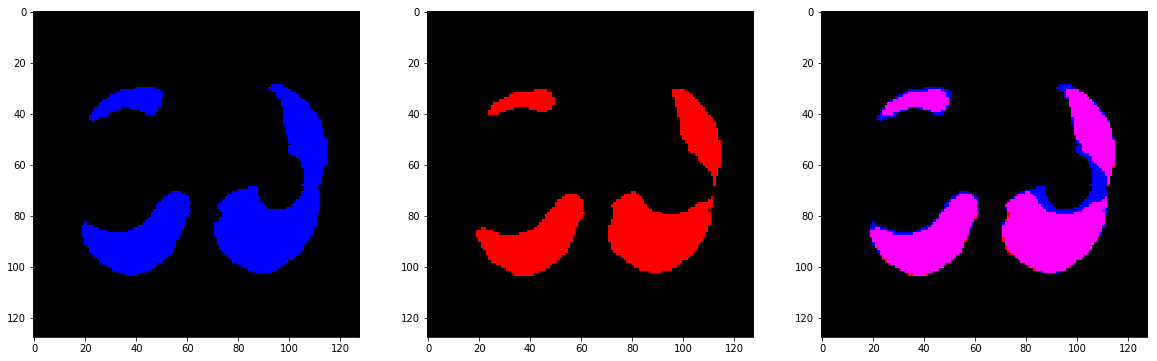

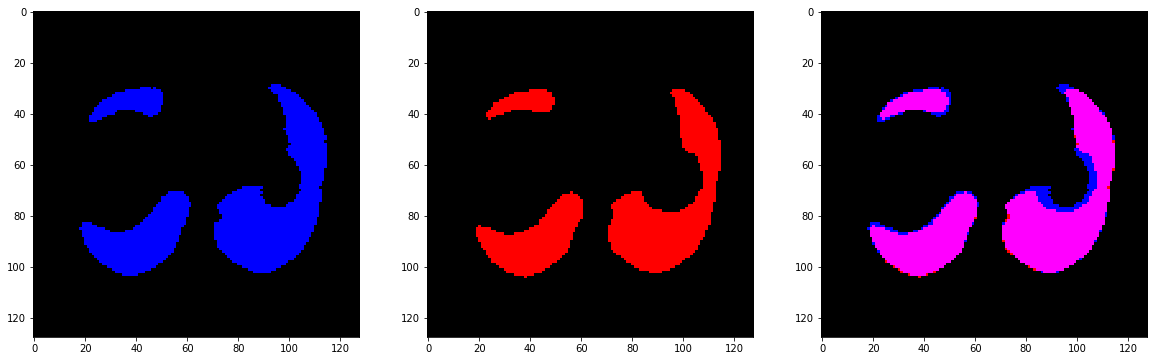

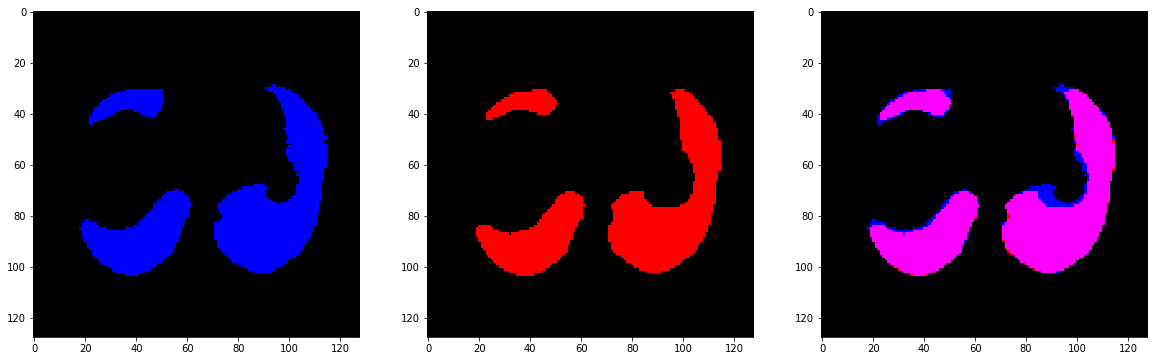

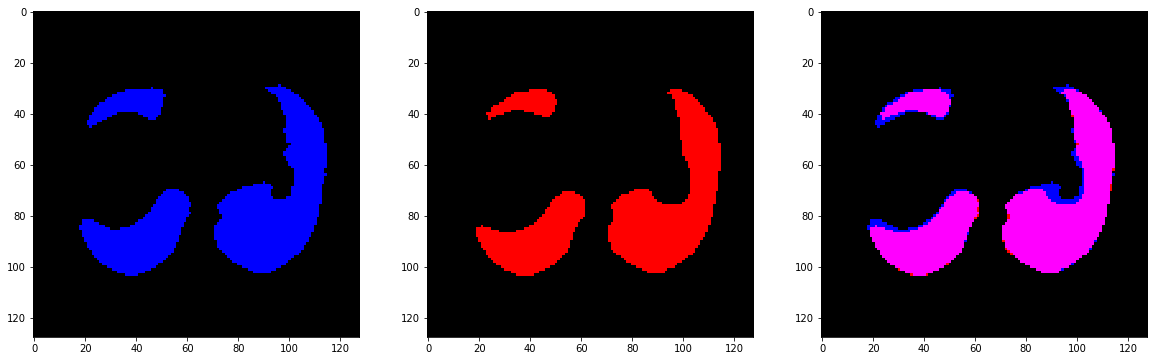

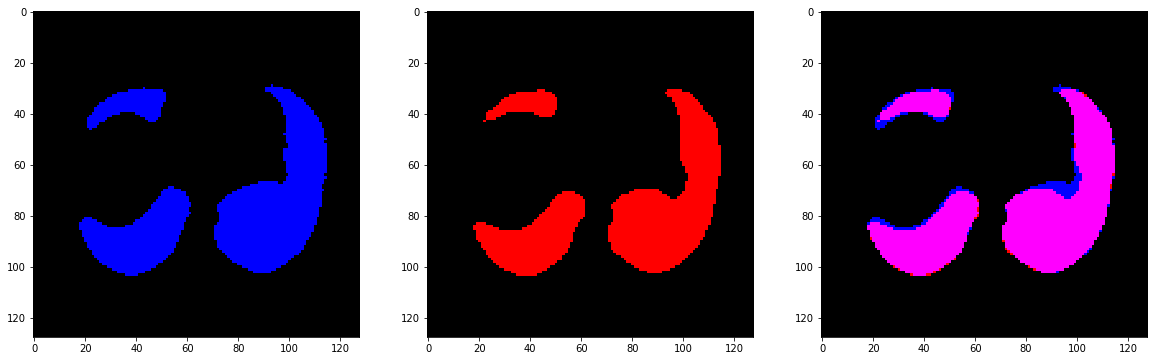

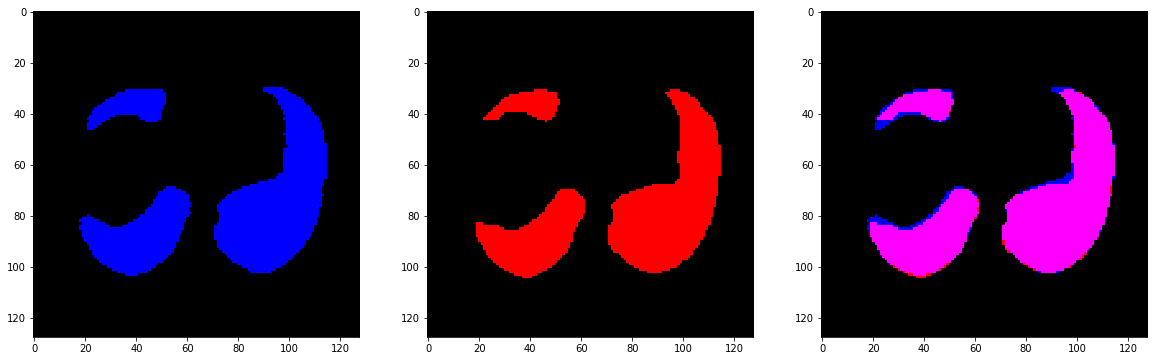

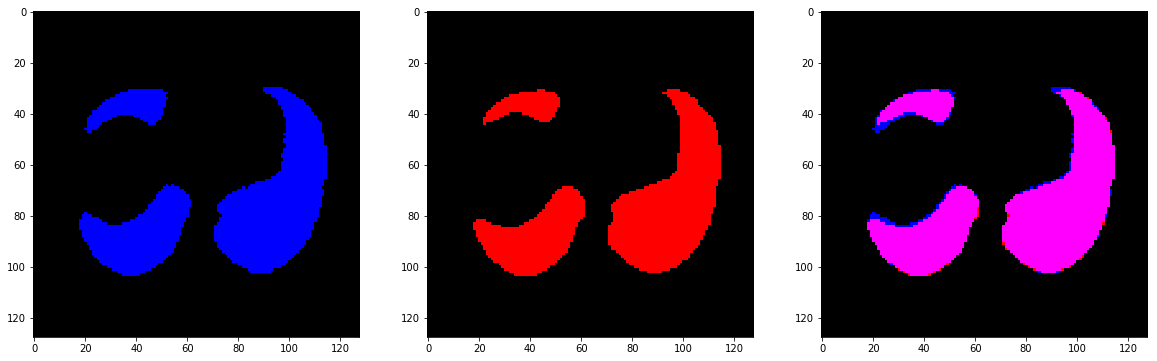

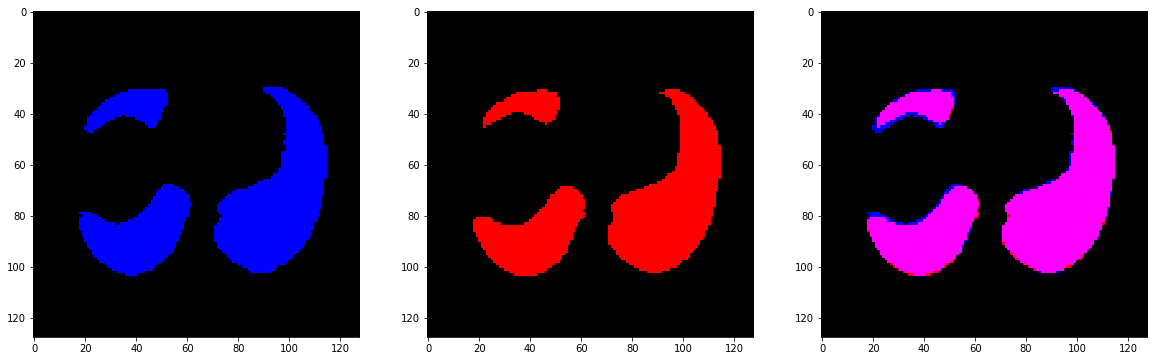

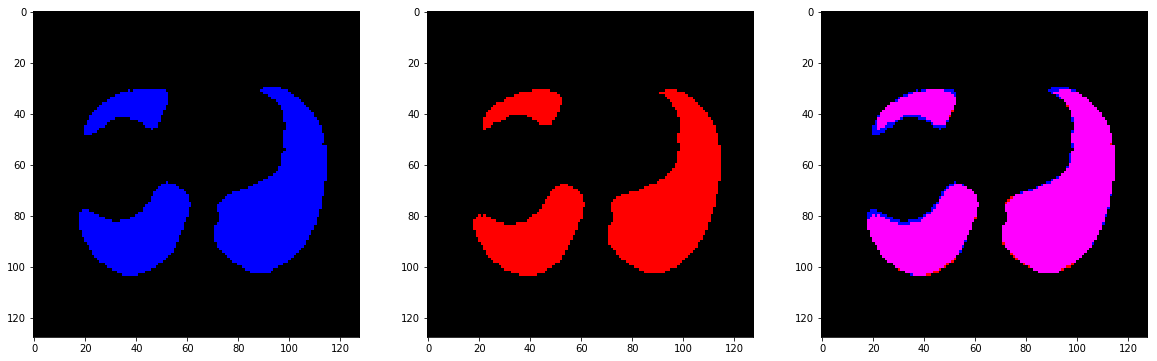

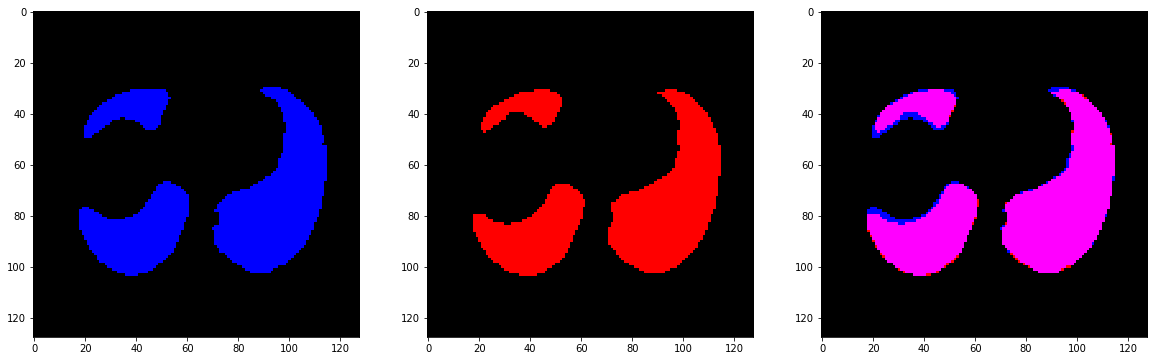

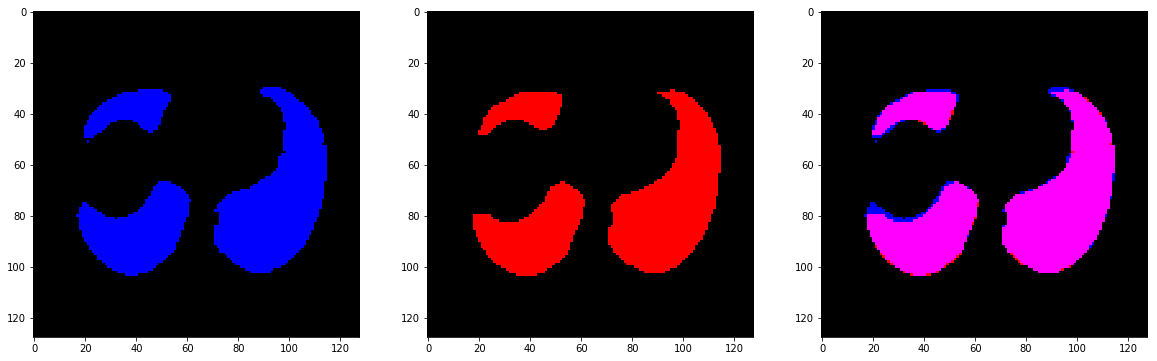

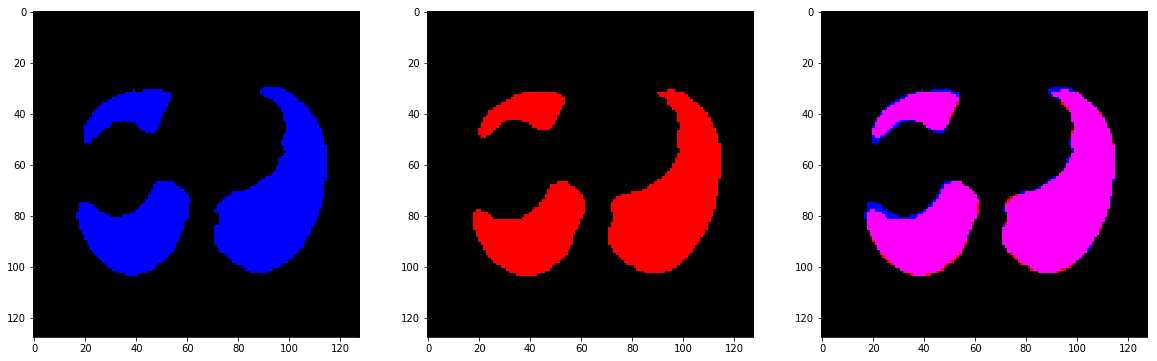

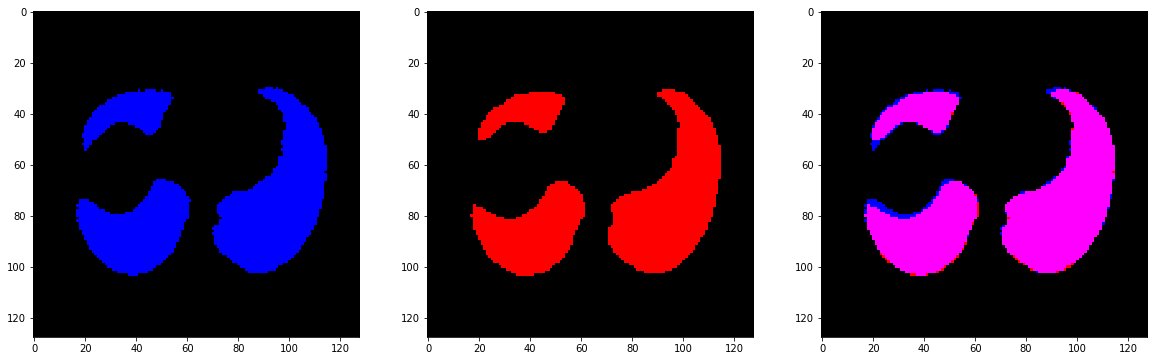

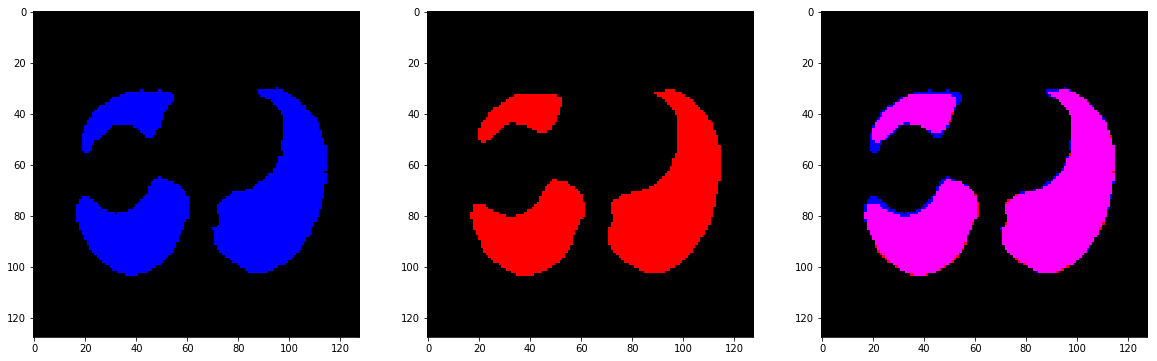

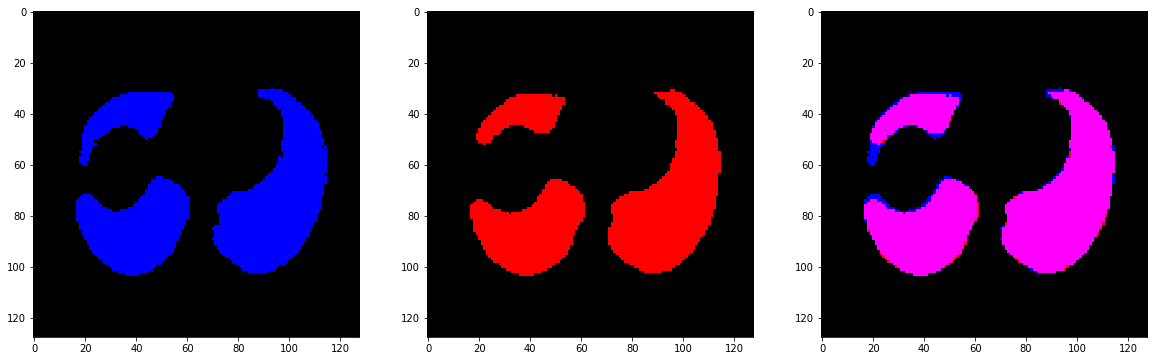

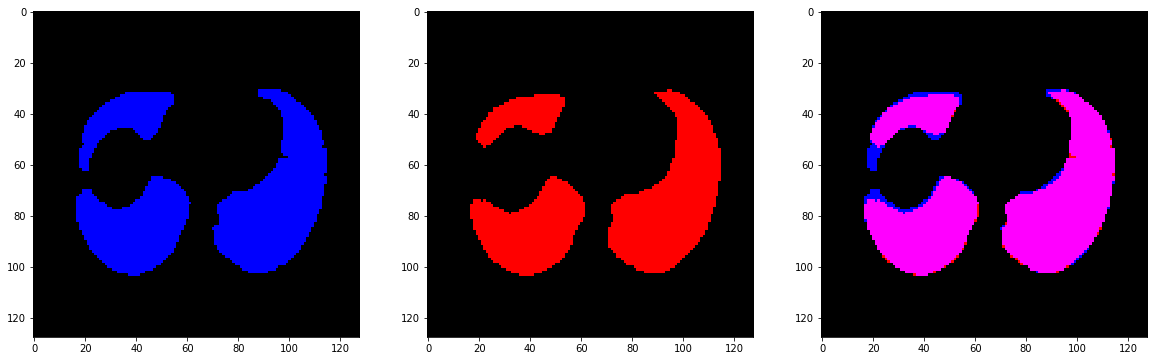

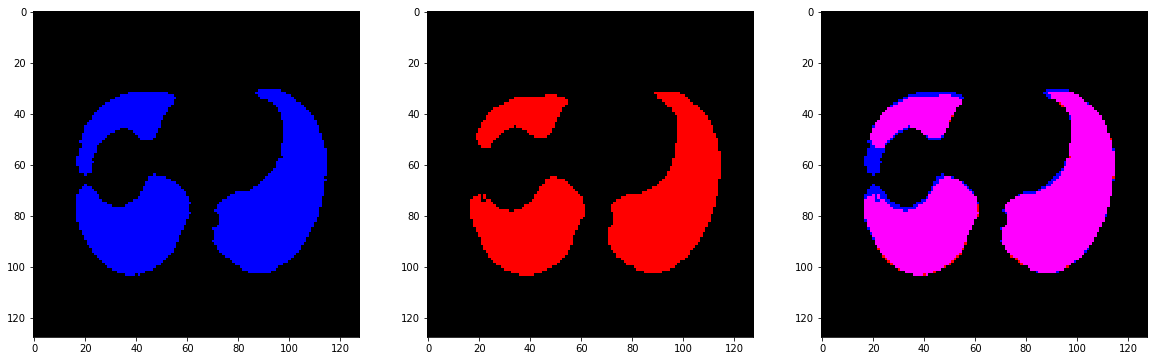

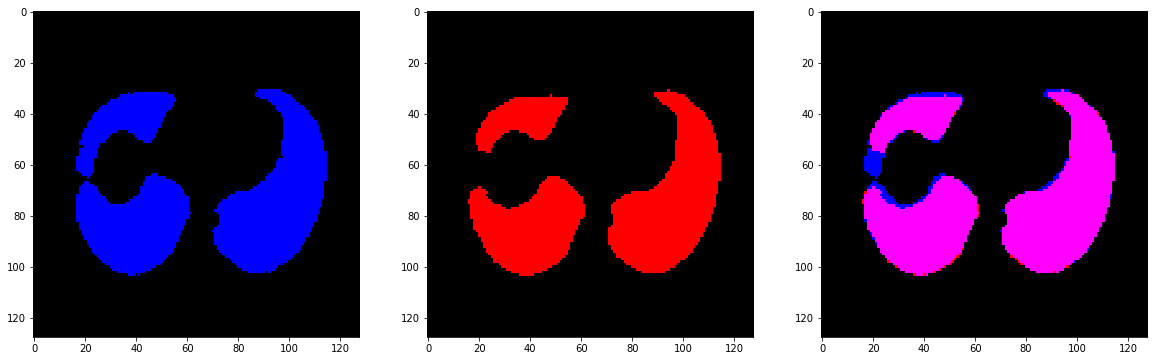

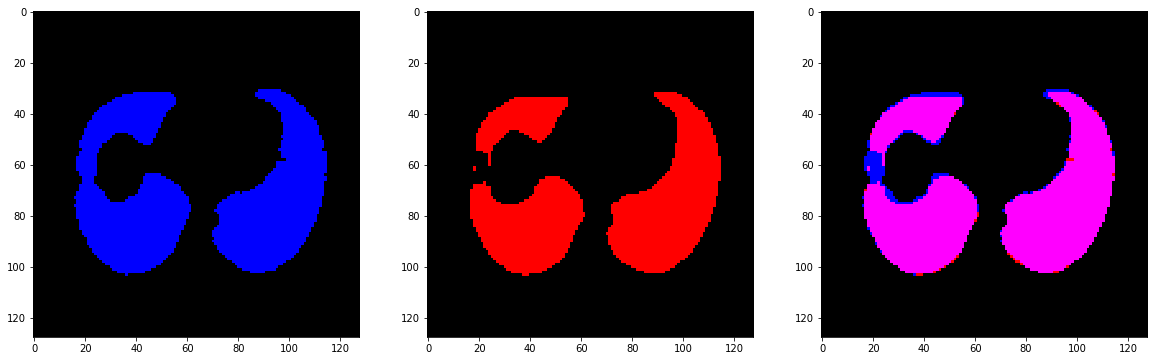

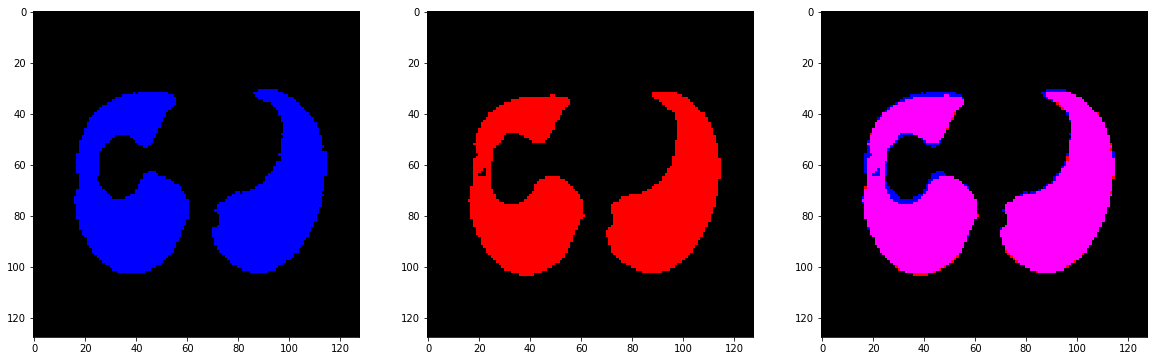

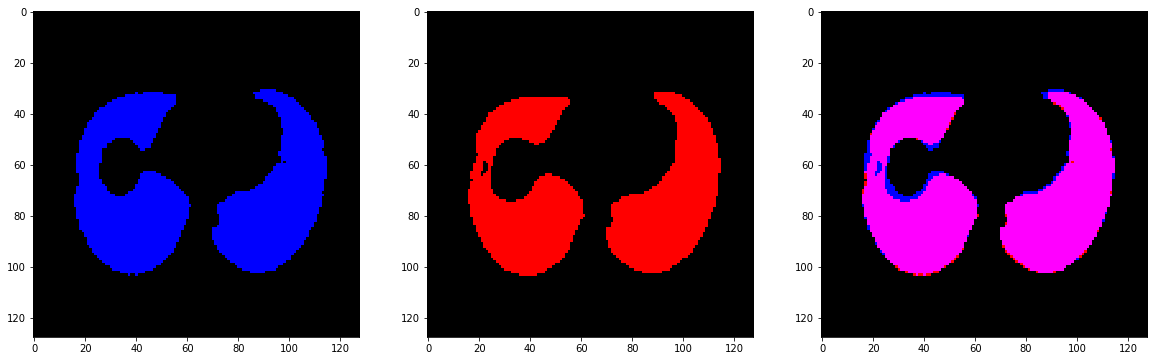

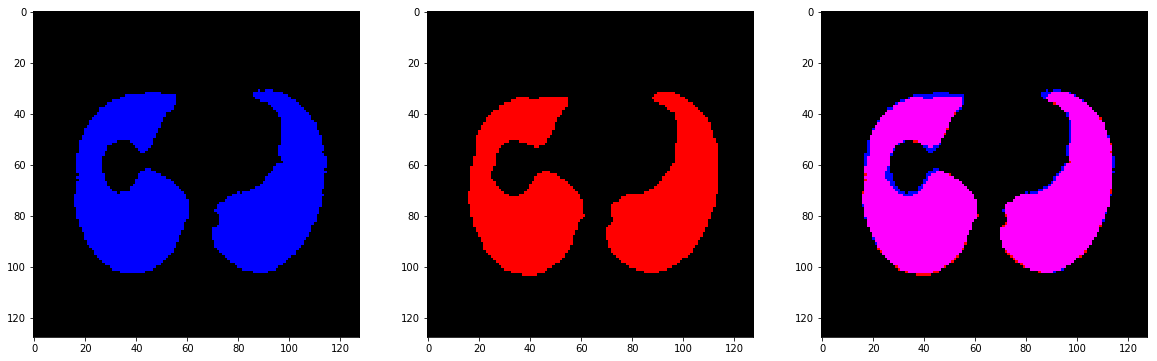

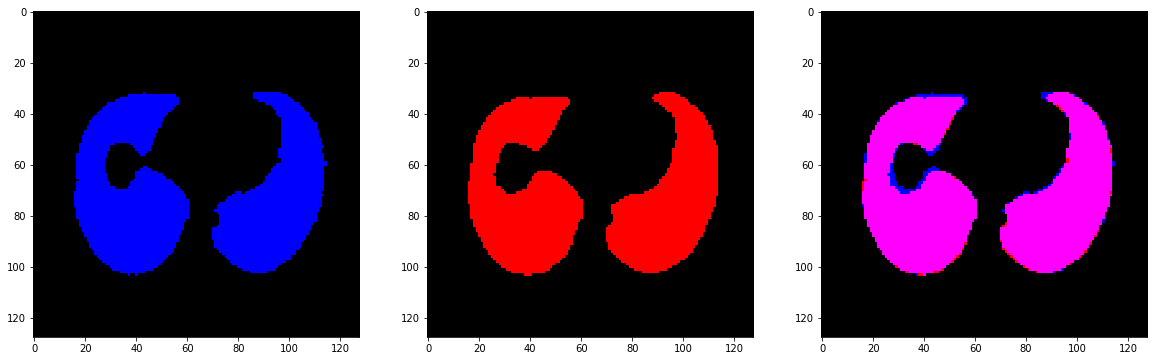

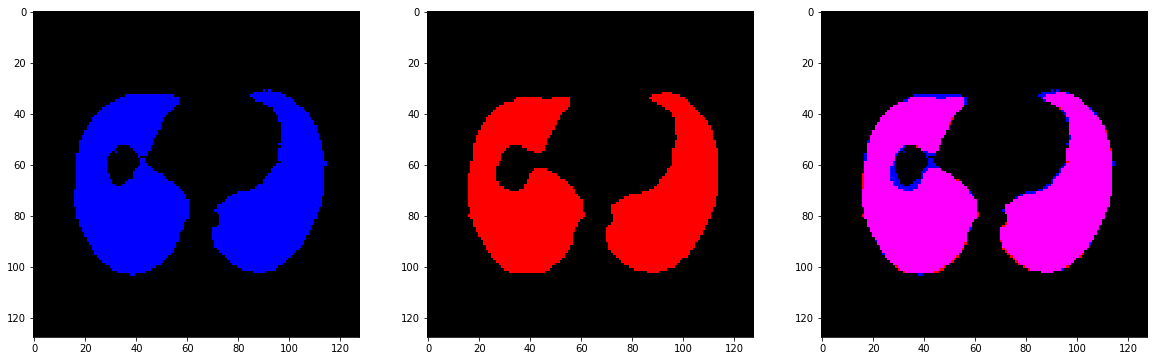

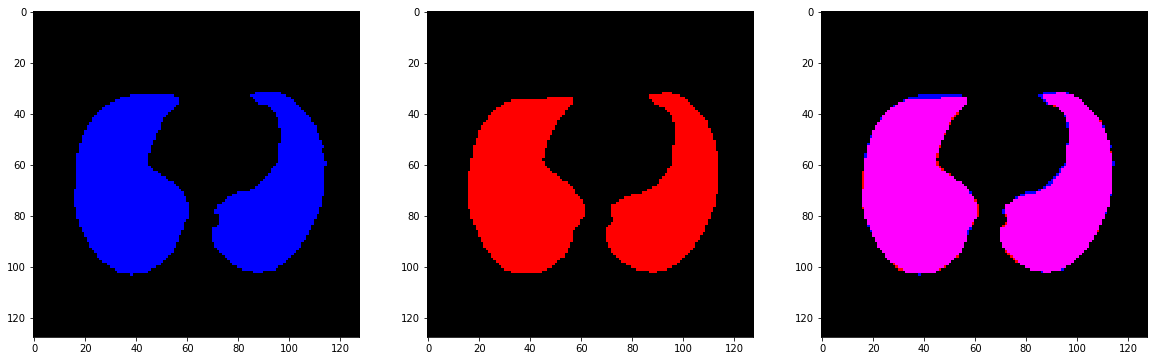

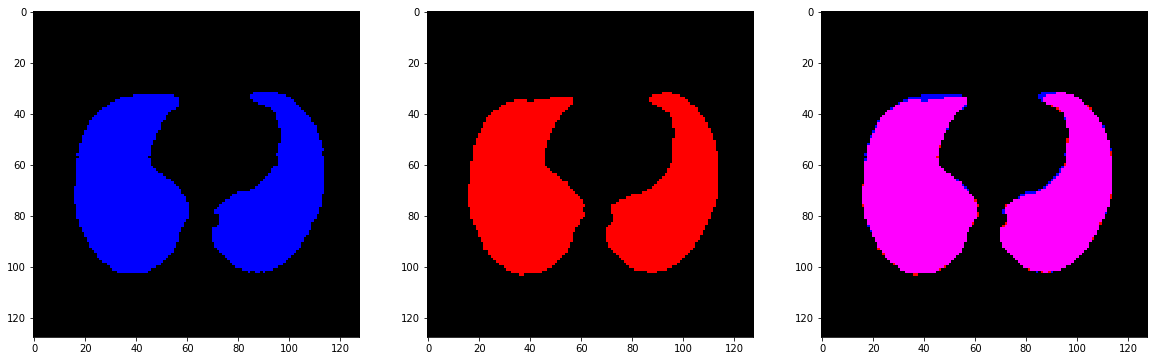

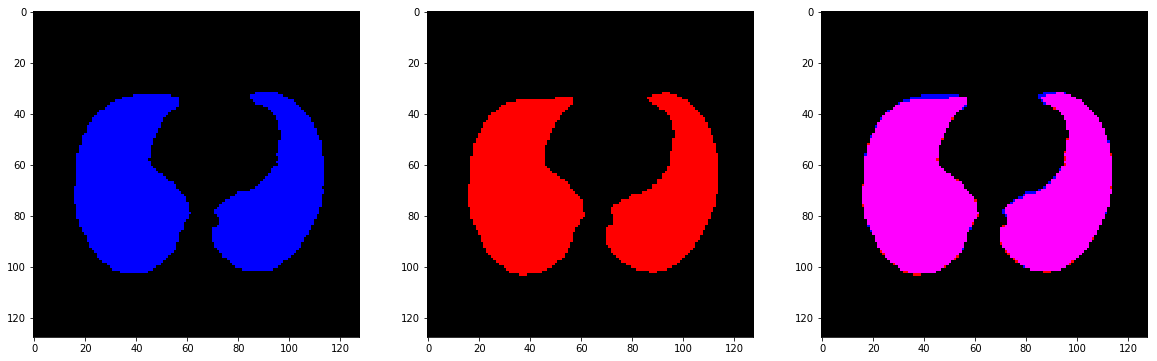

In [17]:
for i in range(100):   
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(q[i])
    plt.subplot(1, 3, 2)
    plt.imshow(a[i])
    plt.subplot(1, 3, 3)
    plt.imshow(a[i]+q[i])

In [18]:
imgs = io.imread('C://lumic_grandchell_dataset//train//030_train_pre_contrast_17mm.mhd', plugin='simpleitk')
a_imgs = io.imread('C://lumic_grandchell_dataset//train//010_train_pre_contrast_2mm.mhd', plugin='simpleitk')
b_imgs = io.imread('C://lumic_grandchell_dataset//train//train_post_contrast.mhd', plugin='simpleitk')

x_train1 = [cv2.resize(img,dsize=(128,128),interpolation=cv2.INTER_LANCZOS4) for img in imgs]
x_train2 = [cv2.resize(a_img,dsize=(128,128),interpolation=cv2.INTER_LANCZOS4) for a_img in a_imgs]
x_train3 = [cv2.resize(b_img,dsize=(128,128),interpolation=cv2.INTER_LANCZOS4) for b_img in b_imgs]


x_train1 = np.array(x_train1)
x_train2 = np.array(x_train2)
x_train3=  np.array(x_train3)


In [19]:
x_train1 = x_train1.astype('float32')
x_train2 =x_train2.astype('float32')
x_train3=x_train3.astype('float32')


center = -400
width = 1500

low = center - width / 2
high = center + width / 2


x_train1 = (x_train1-low) / (high-low)
x_train1[x_train1 < 0.] = 0.
x_train1[x_train1 > 1.] = 1.

x_train2 = (x_train2-low) / (high-low)
x_train2[x_train2 < 0.] = 0.
x_train2[x_train2 > 1.] = 1.

x_train3 = (x_train3-low) / (high-low)
x_train3[x_train3 < 0.] = 0.
x_train3[x_train3 > 1.] = 1.


train1_std = np.std(x_train1)
train1_mean = np.mean(x_train1)
train2_std = np.std(x_train2)
train2_mean = np.mean(x_train2)
train3_std = np.std(x_train3)
train3_mean = np.mean(x_train3)
print(train1_mean,train1_std,train2_std,train2_mean,train3_std ,train3_mean)

x_train1 -= train1_mean
x_train1 /= train1_std
x_train2 -= train2_mean
x_train2 /= train2_std
x_train3 -= train3_mean
x_train3 /= train3_std



0.4706225 0.32372954 0.32669517 0.47383678 0.3331719 0.4799573


In [20]:
x_train1 = x_train1.reshape(-1,128,128,1)
x_train2 = x_train2.reshape(-1,128,128,1)
x_train3 = x_train3.reshape(-1,128,128,1)



result1 = model.predict(x_train1 )
result2 = model.predict(x_train2 )
result3 = model.predict(x_train3 )

result1[result1 < 0.5] = 0.
result1[result1 >= 0.5] = 1.

result2[result2 < 0.5] = 0.
result2[result2 >= 0.5] = 1.

result3[result3 < 0.5] = 0.
result3[result3 >= 0.5] = 1.

C:\Users\juhee\AppData\Local\conda\conda\envs\venv\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


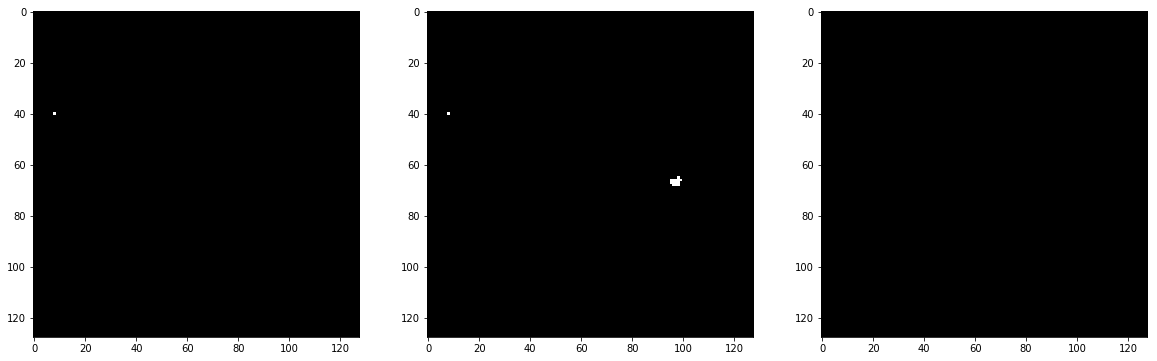

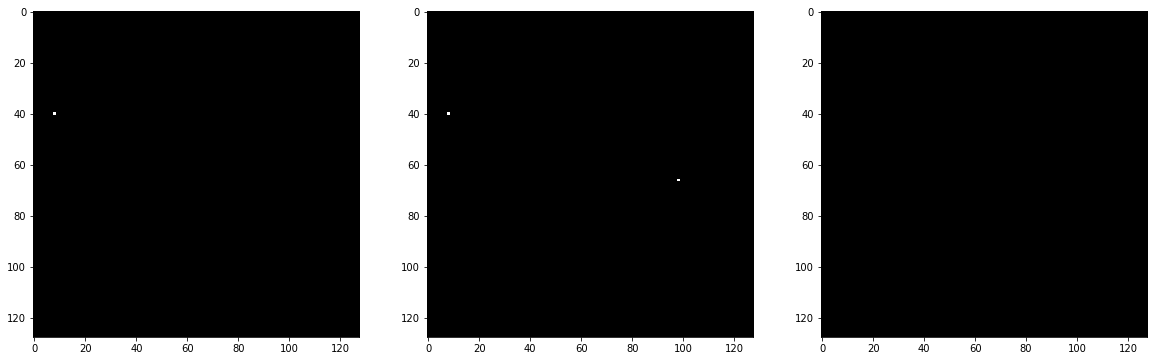

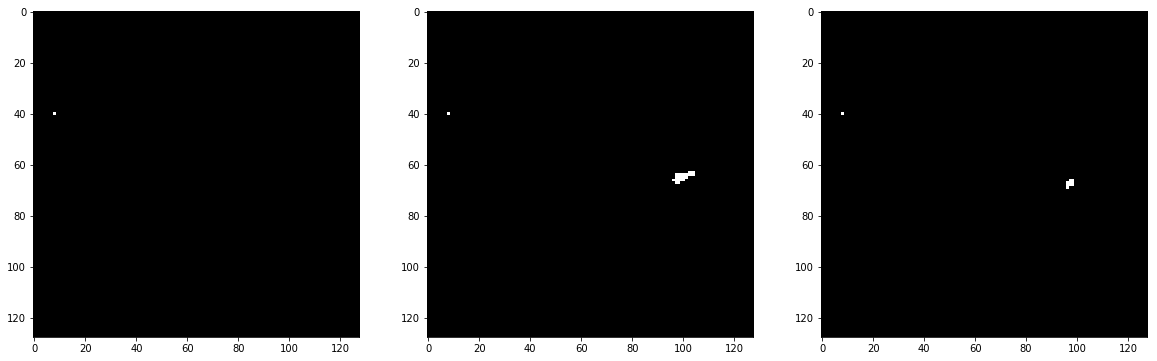

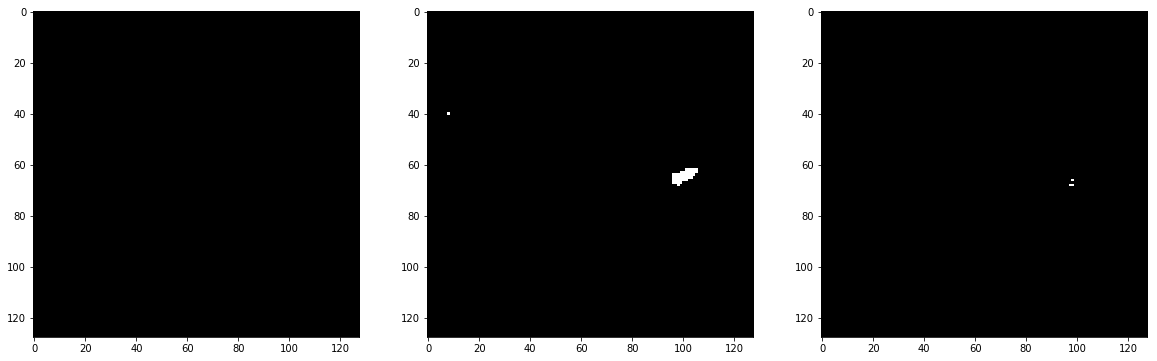

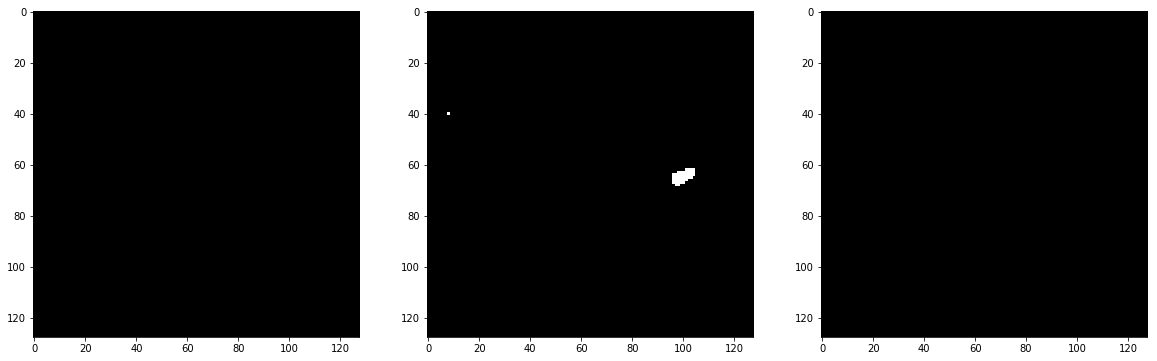

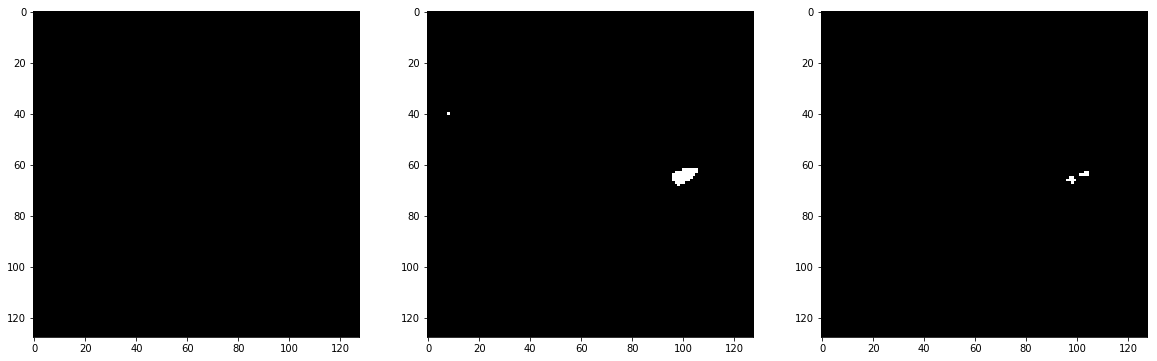

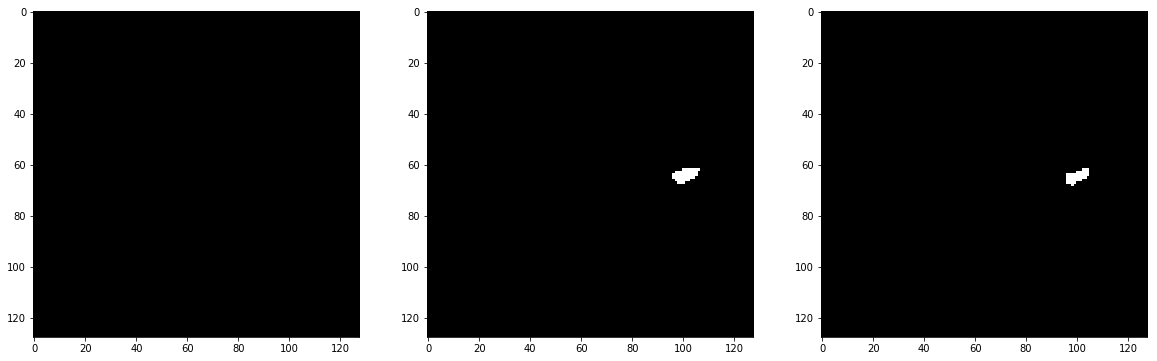

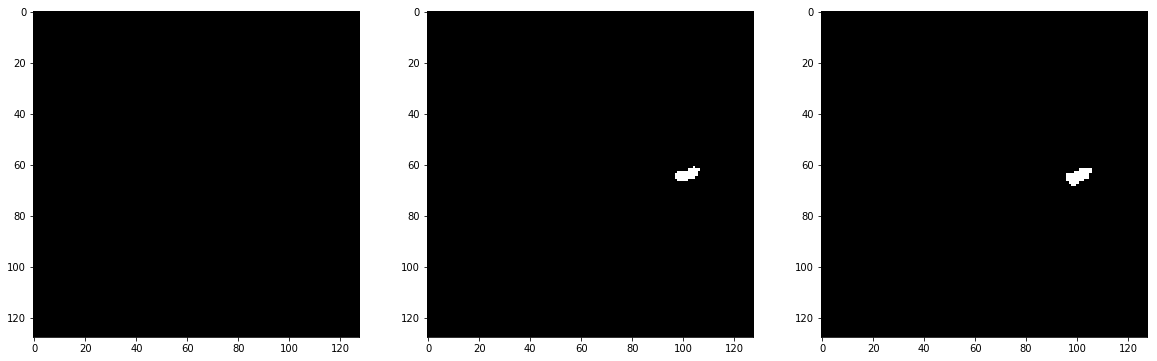

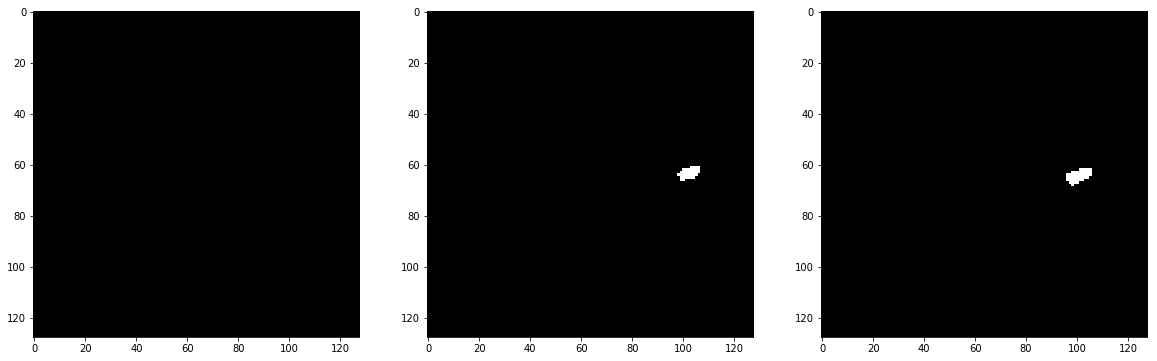

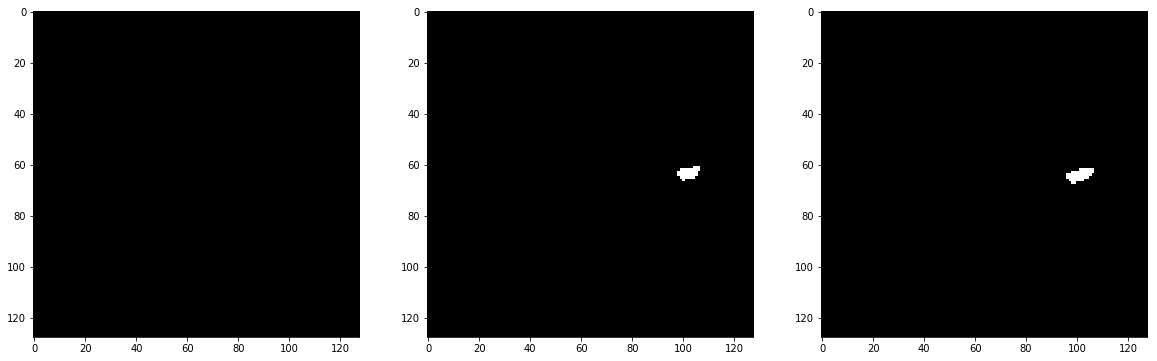

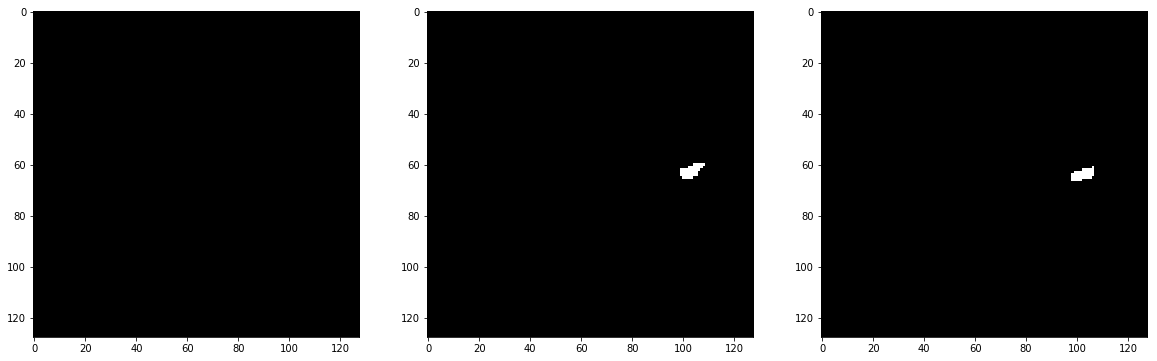

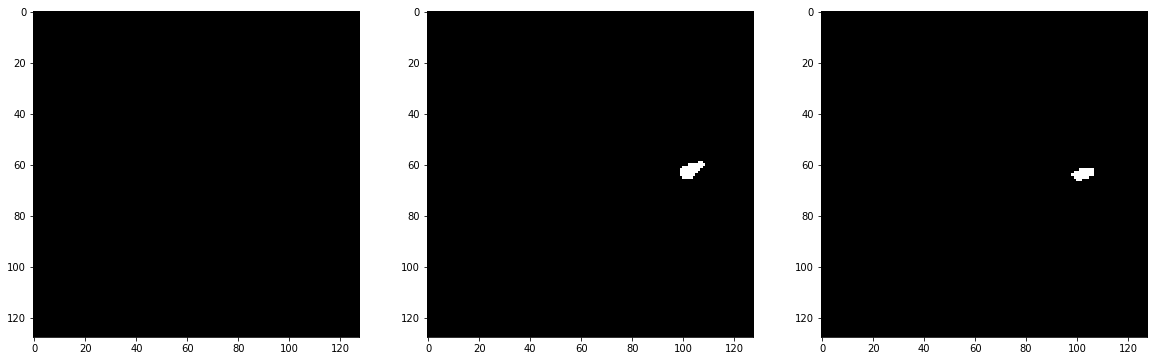

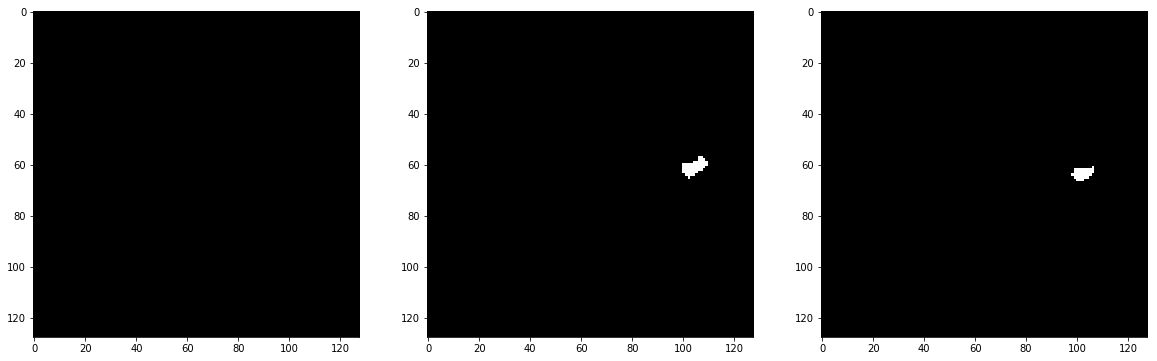

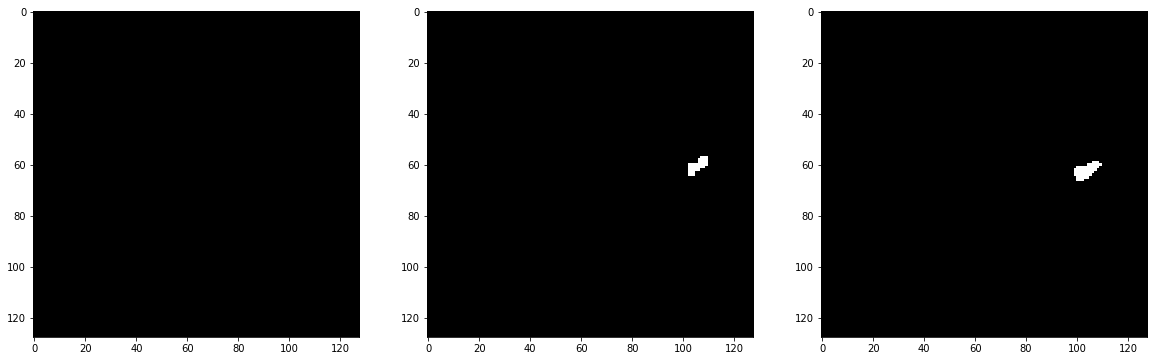

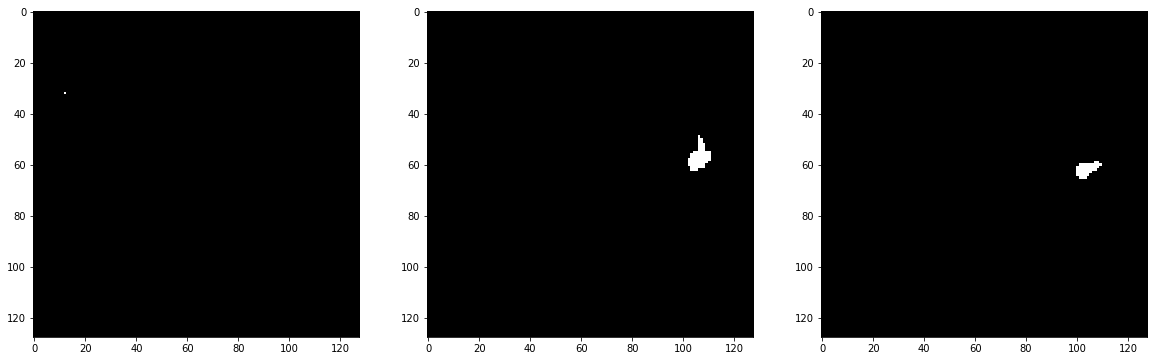

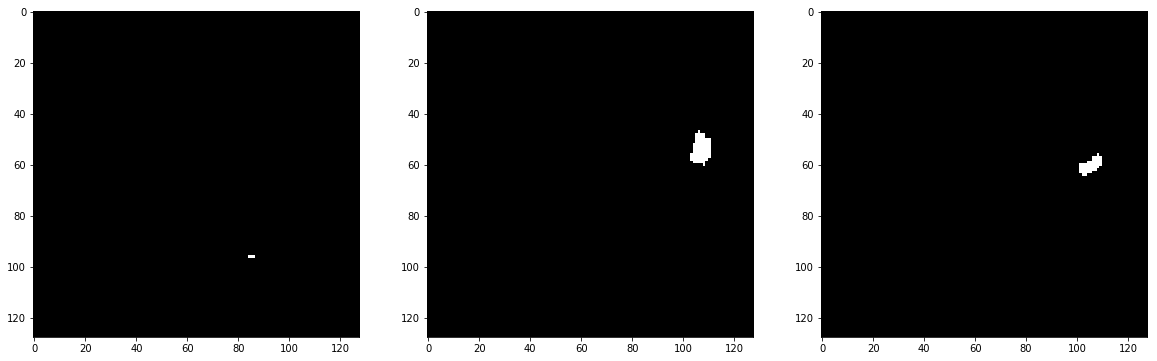

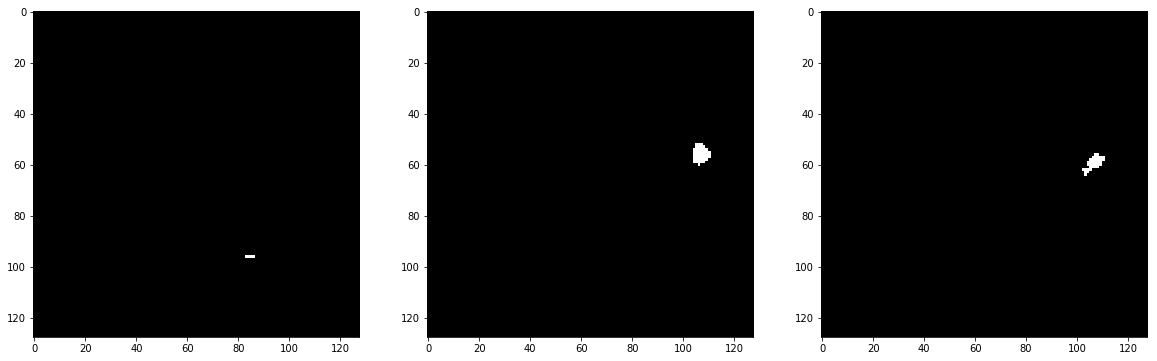

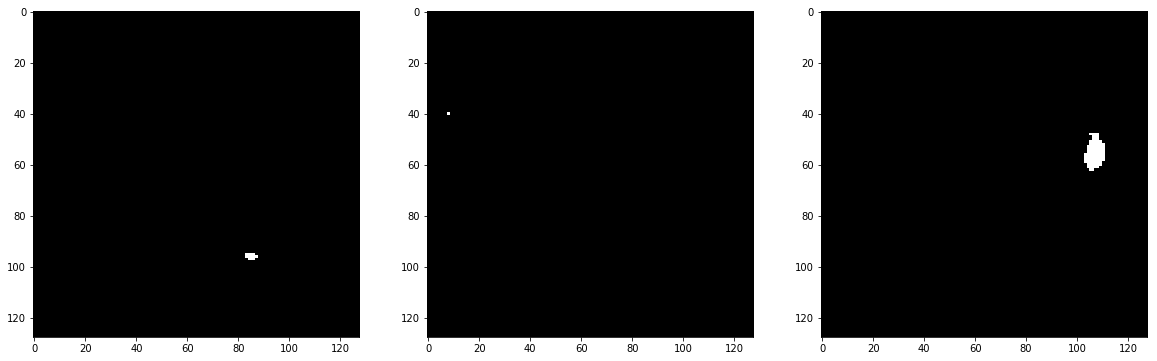

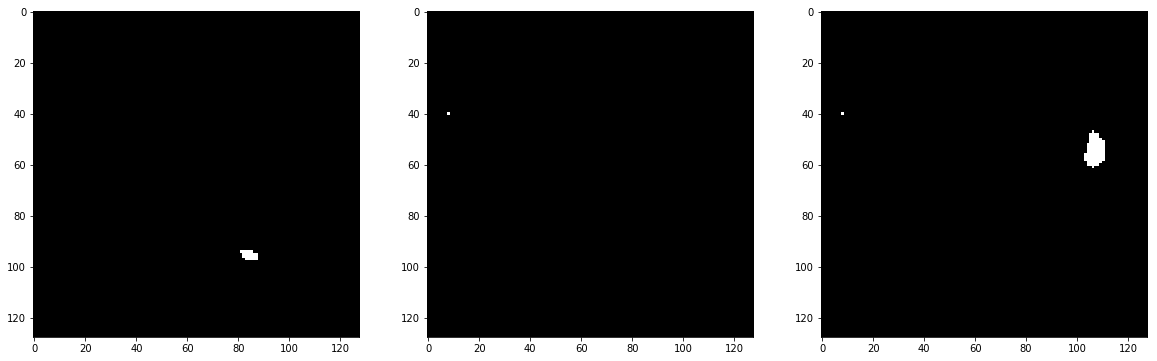

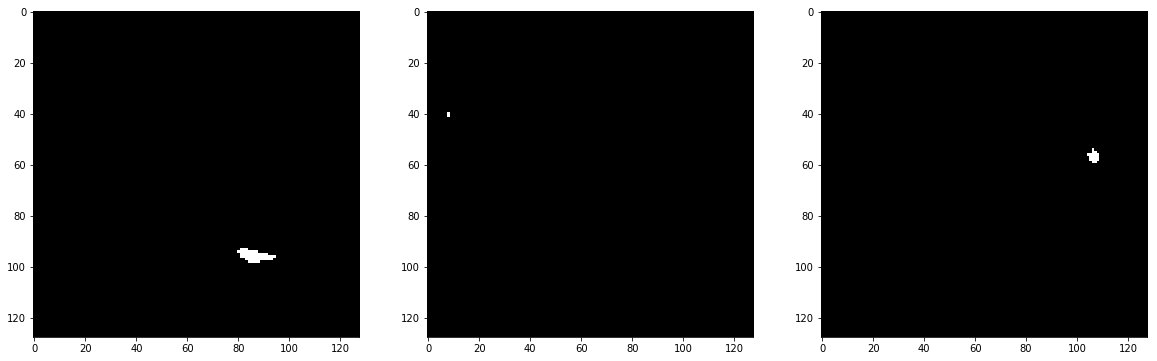

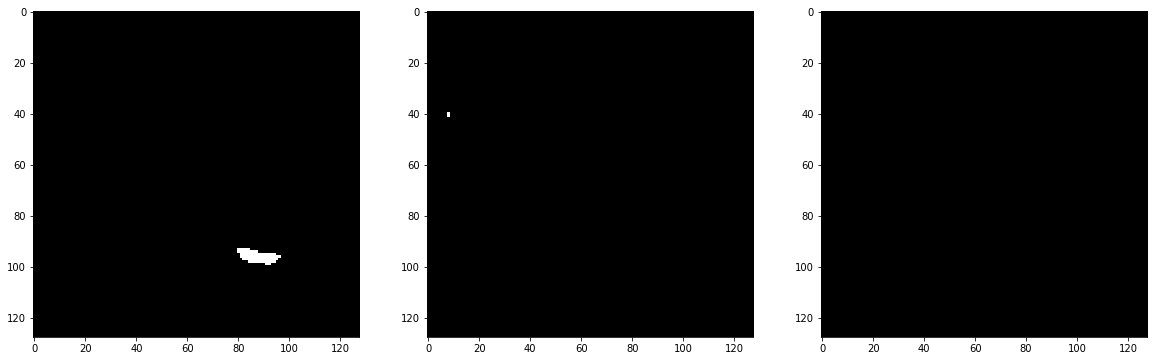

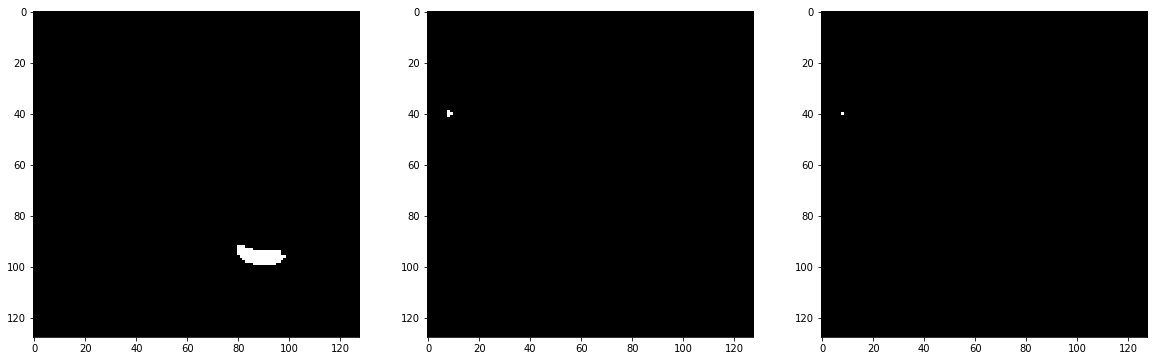

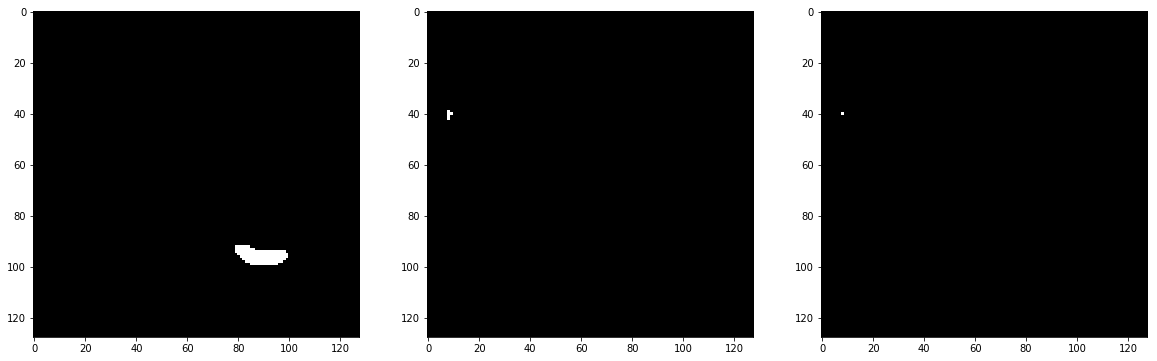

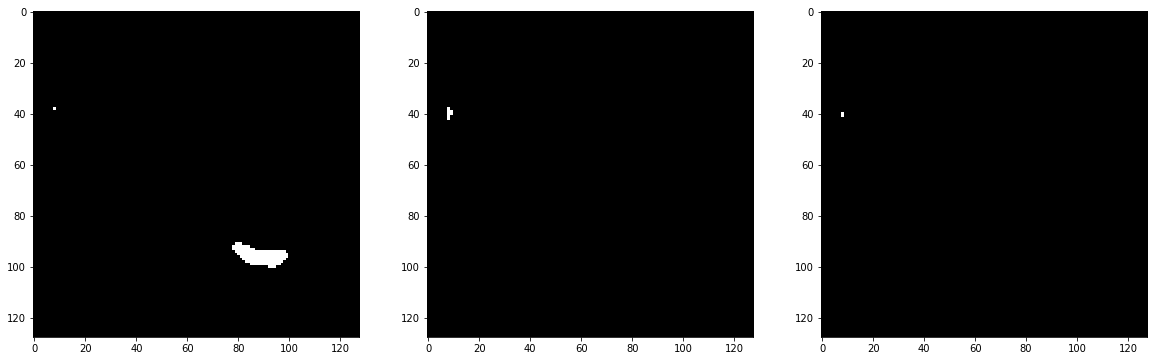

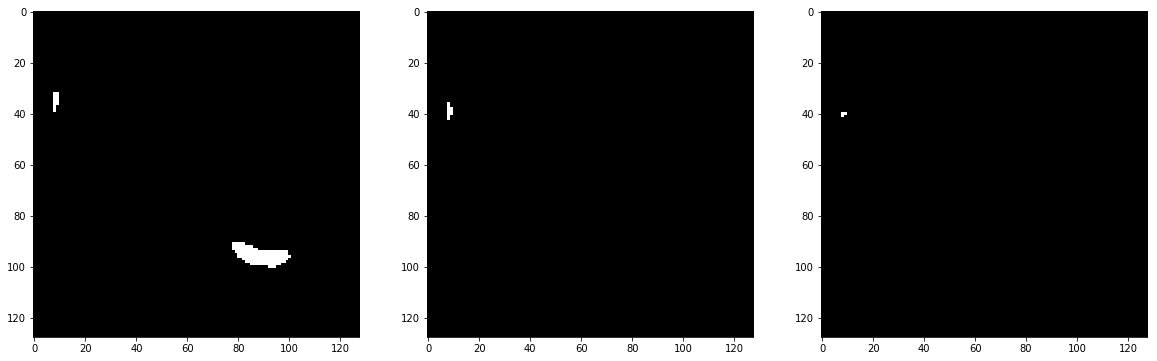

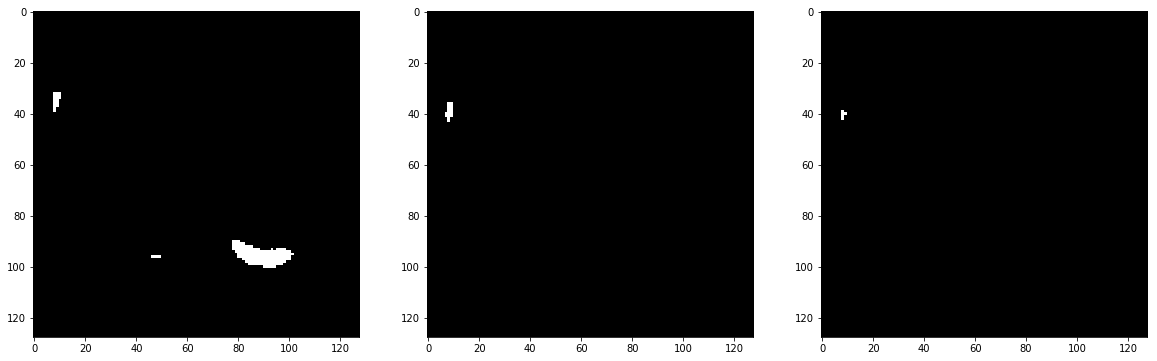

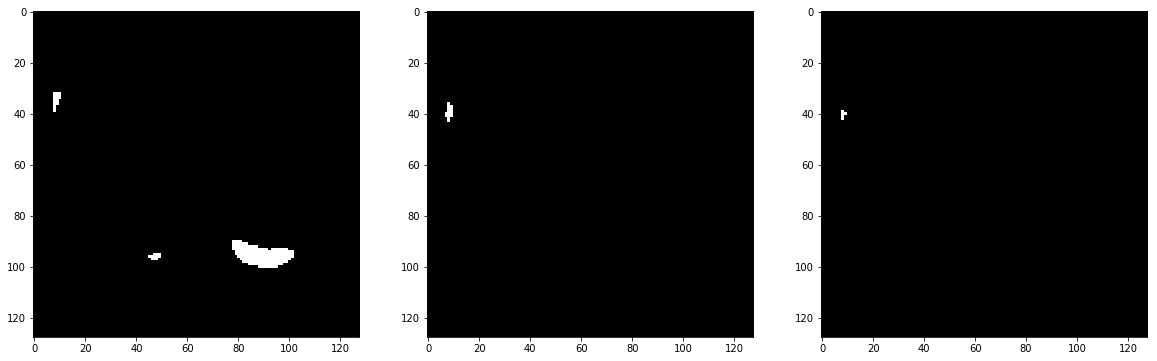

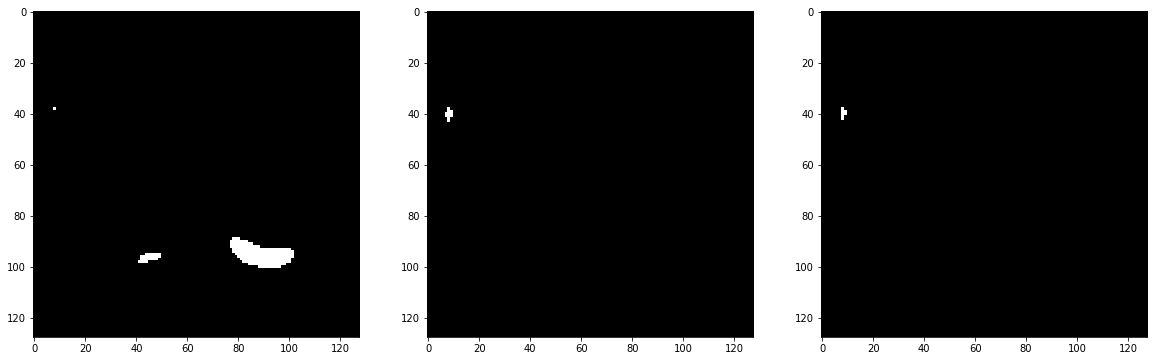

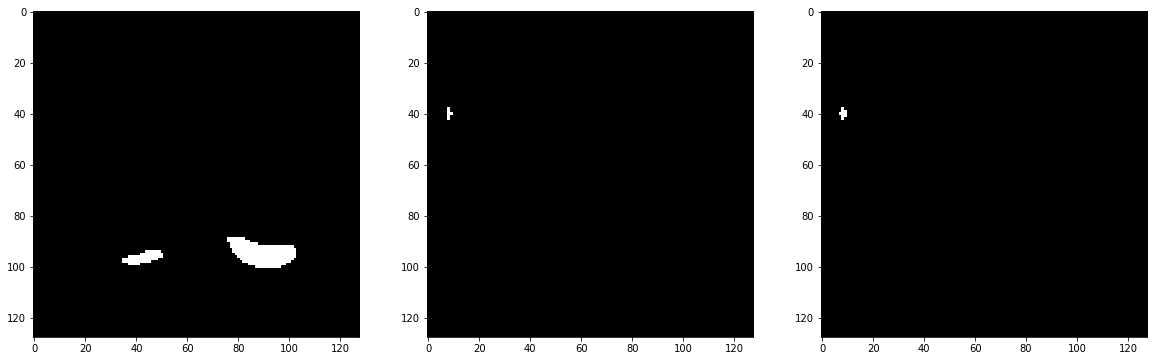

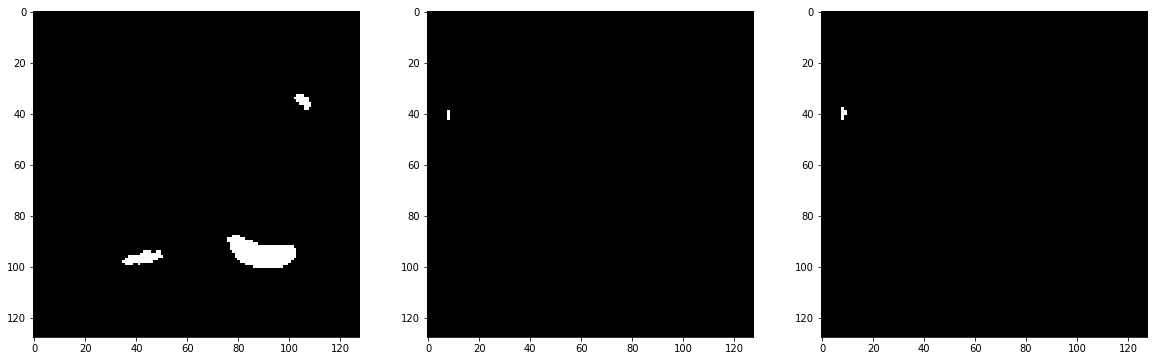

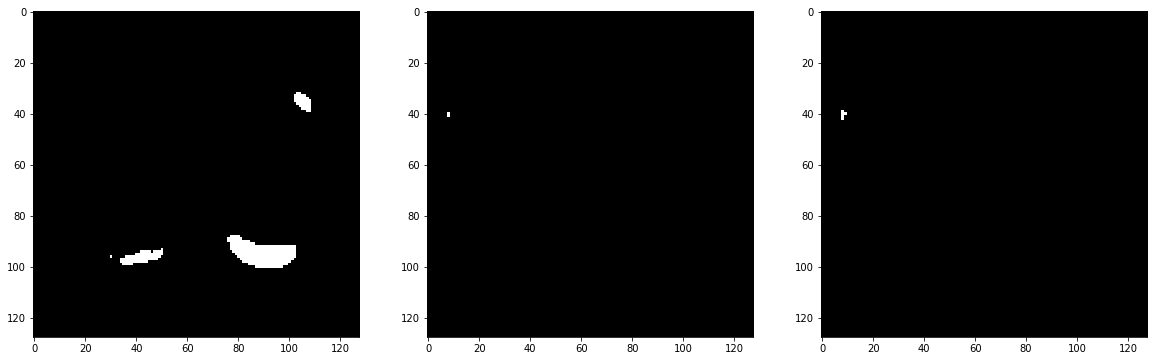

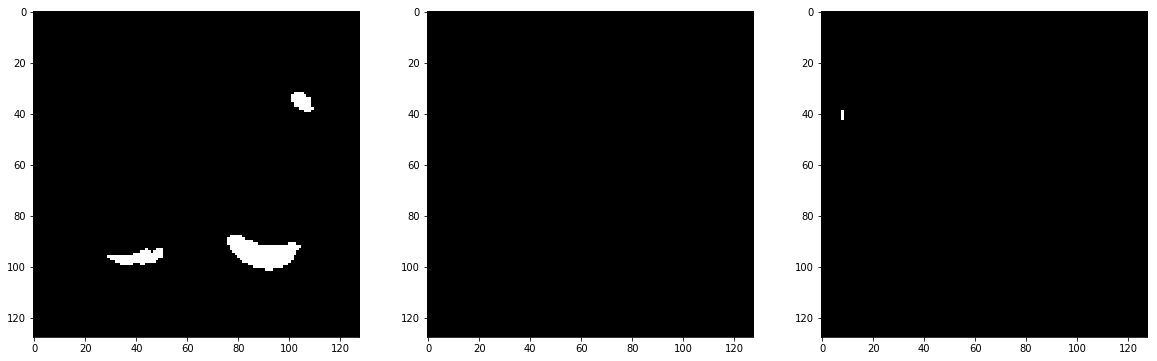

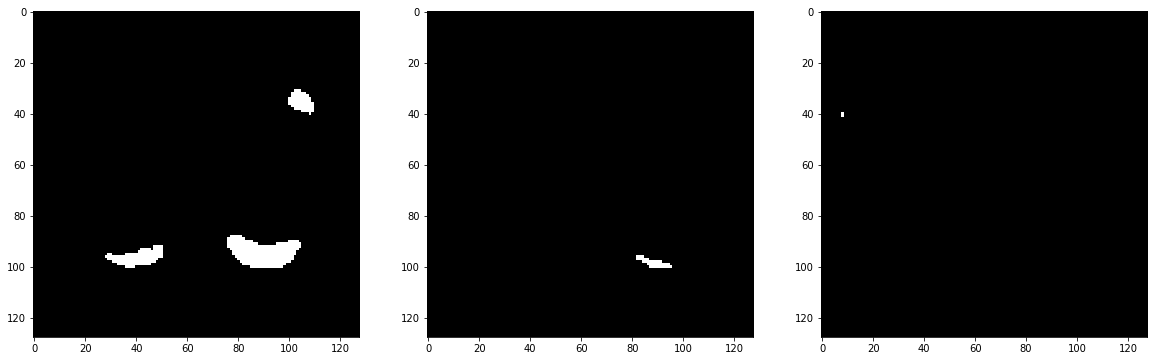

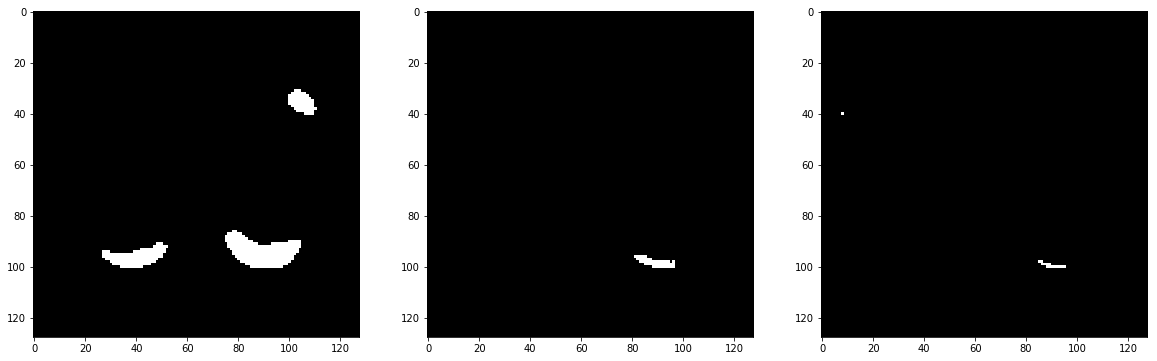

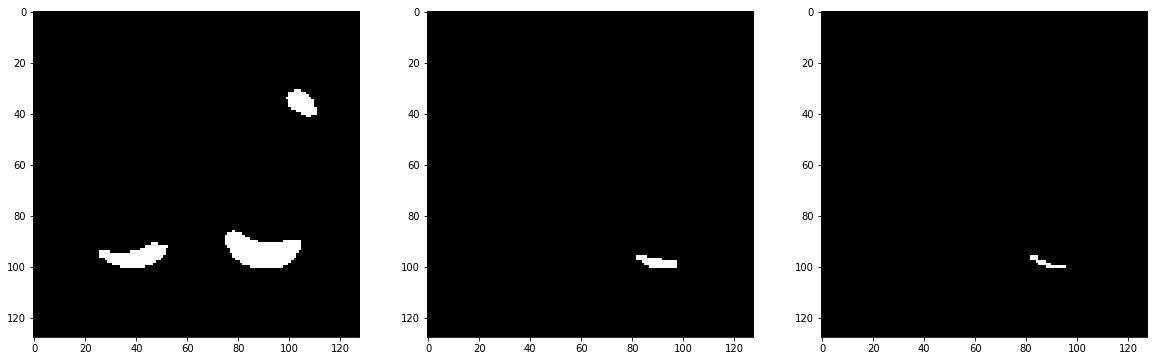

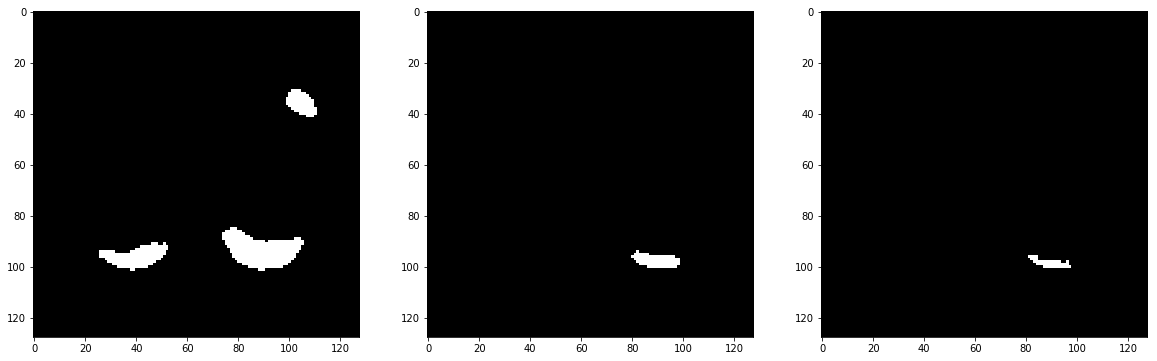

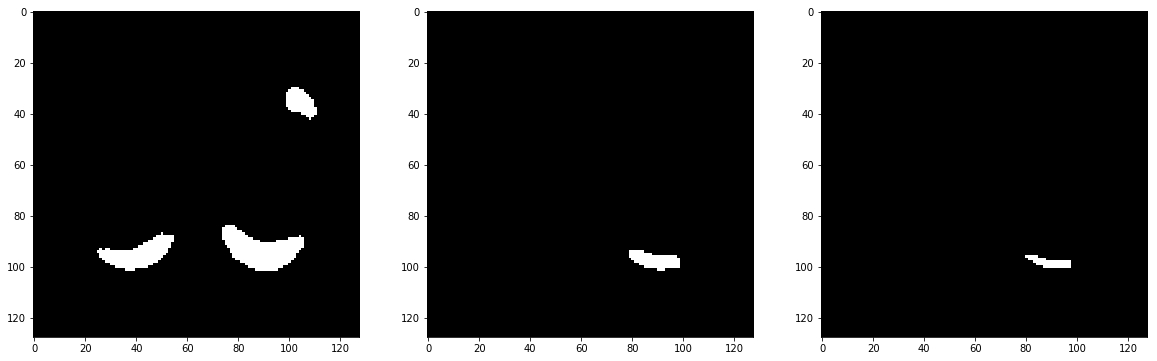

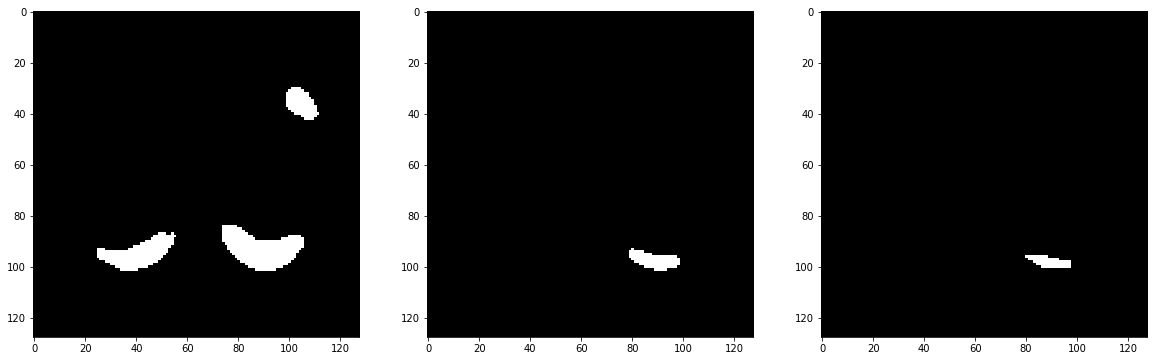

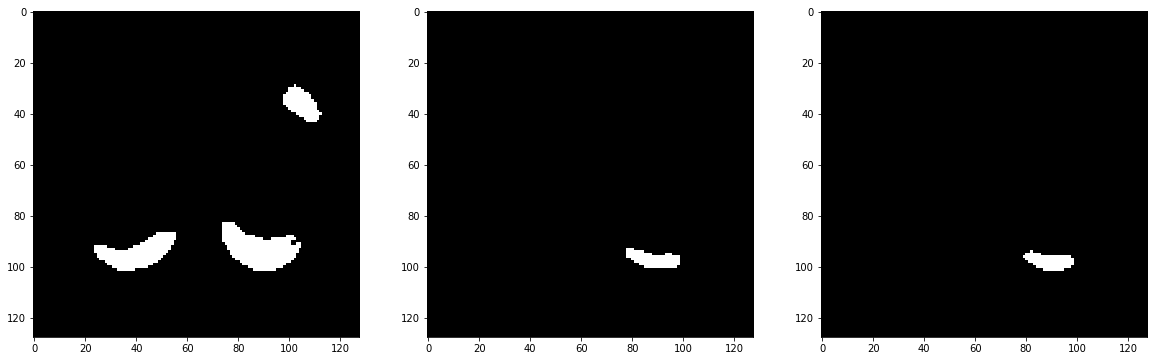

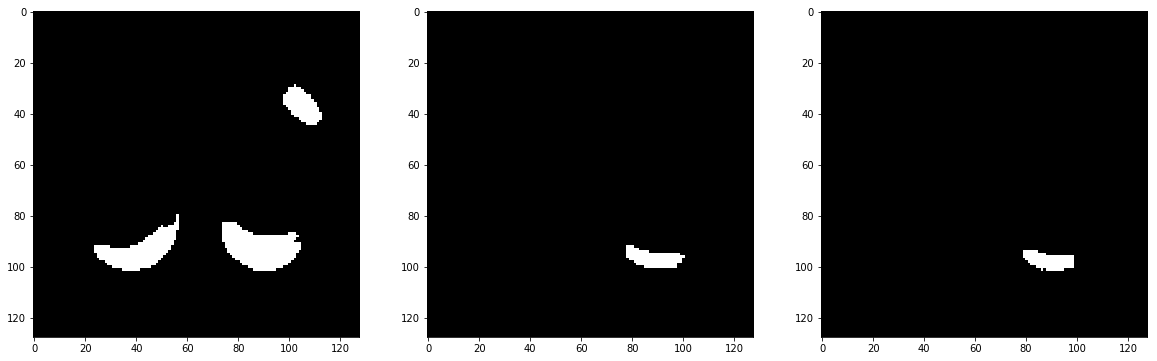

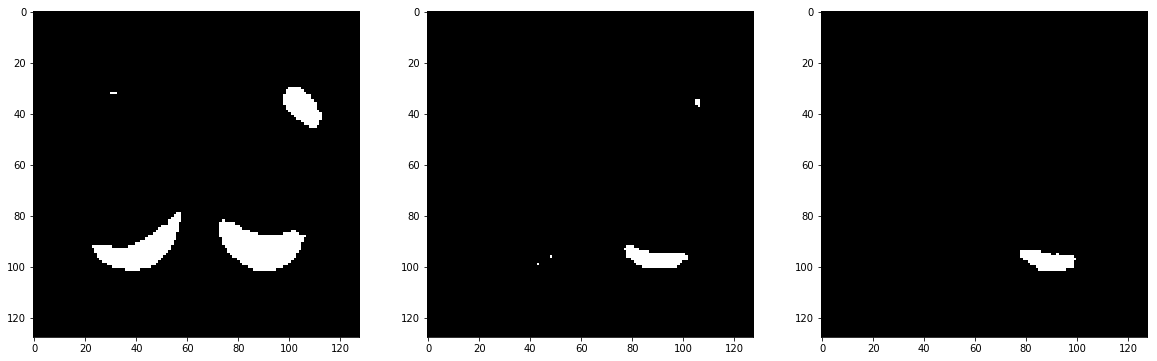

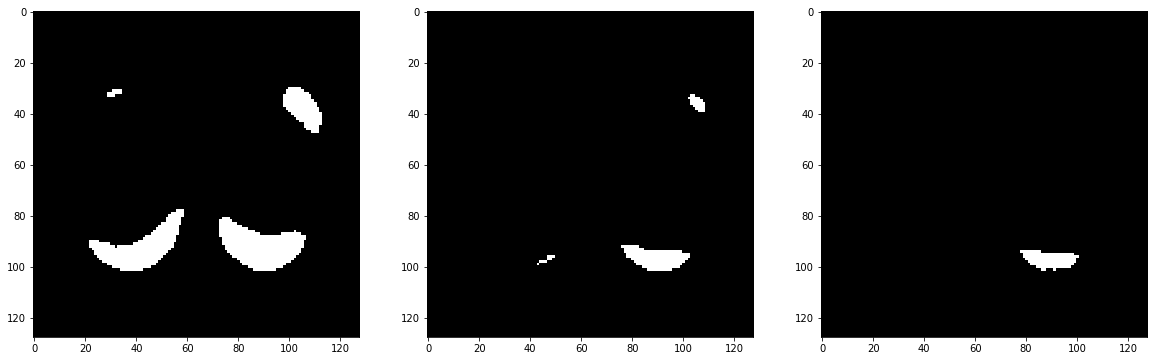

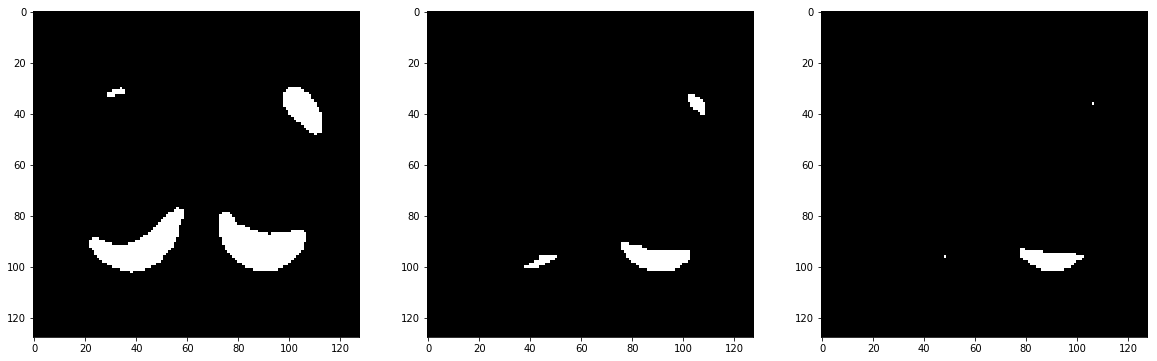

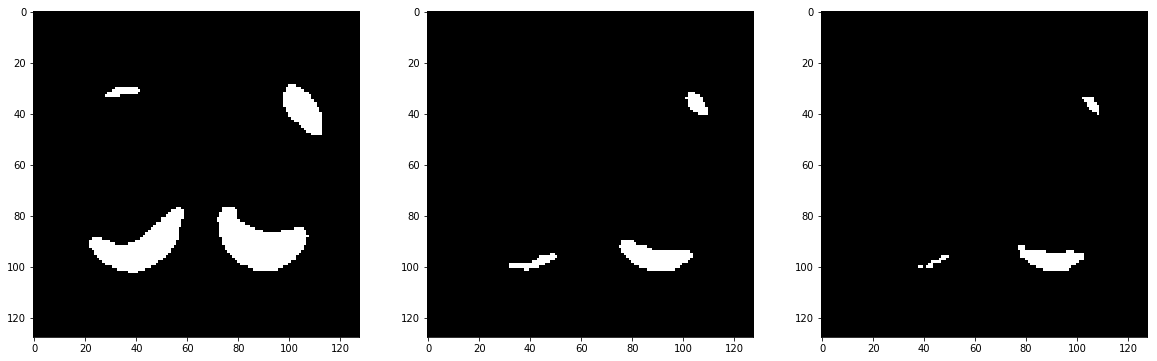

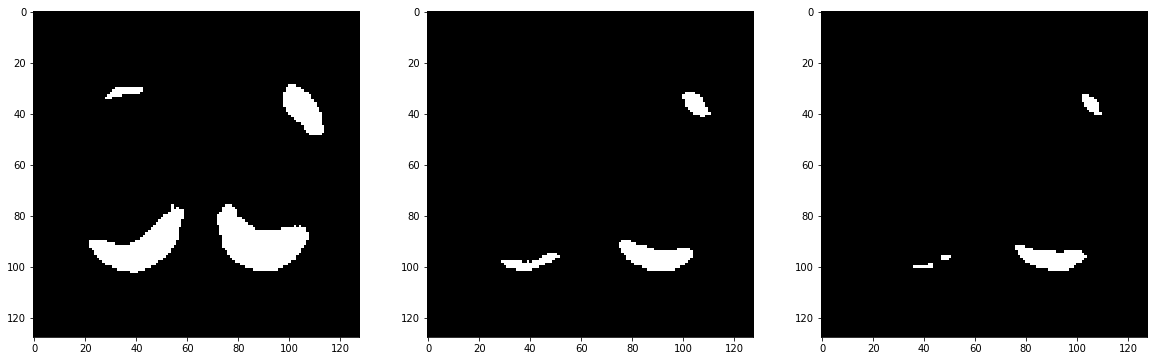

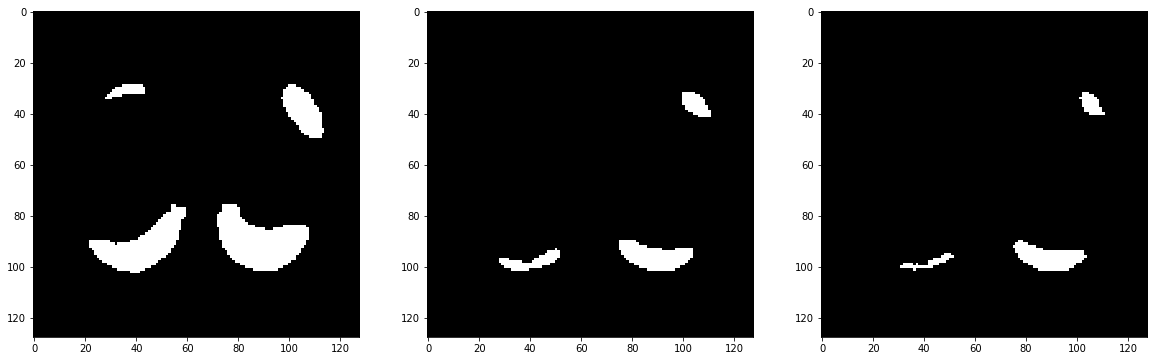

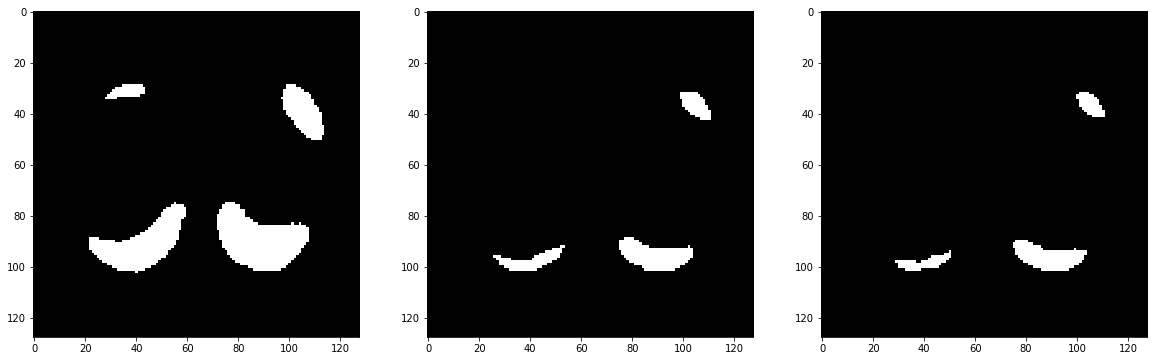

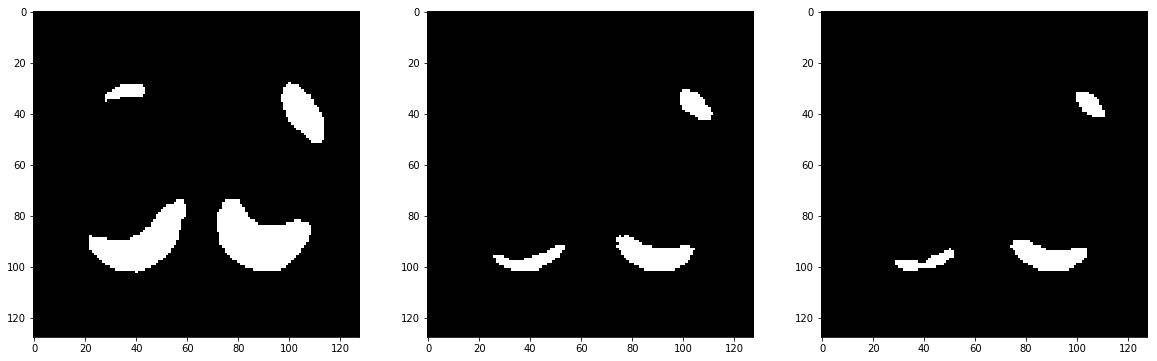

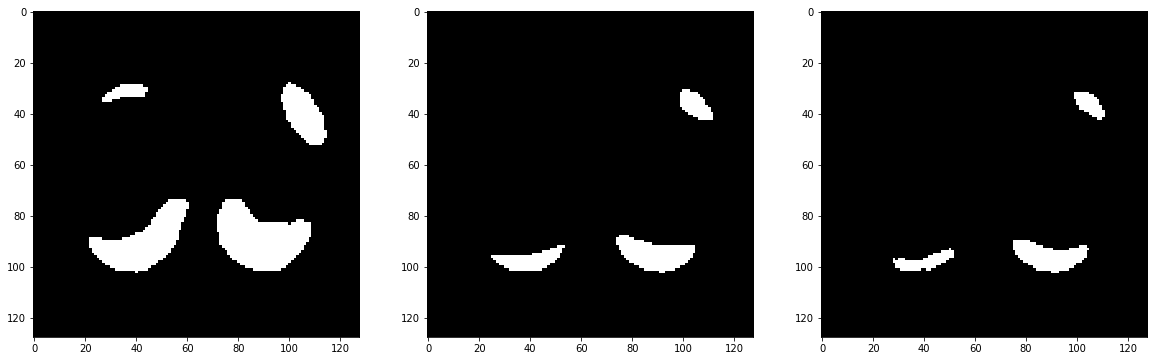

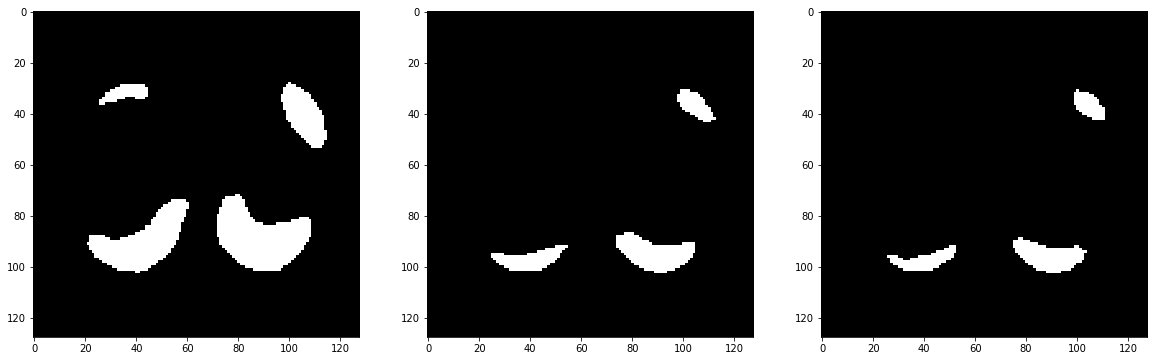

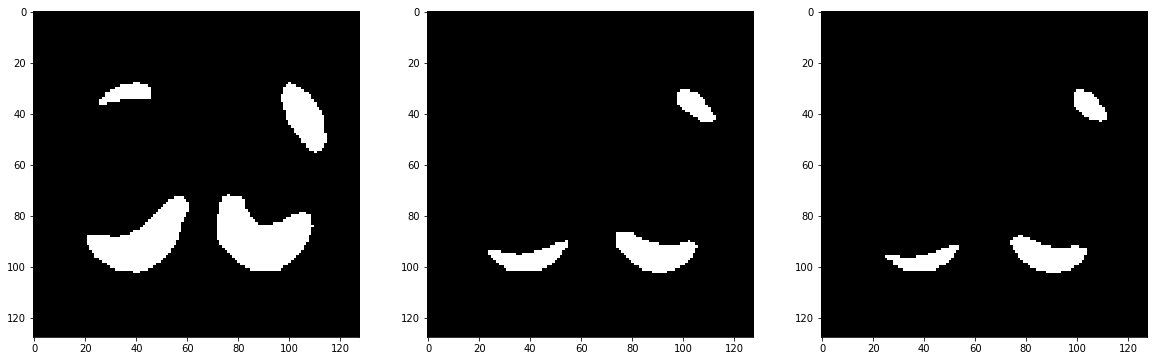

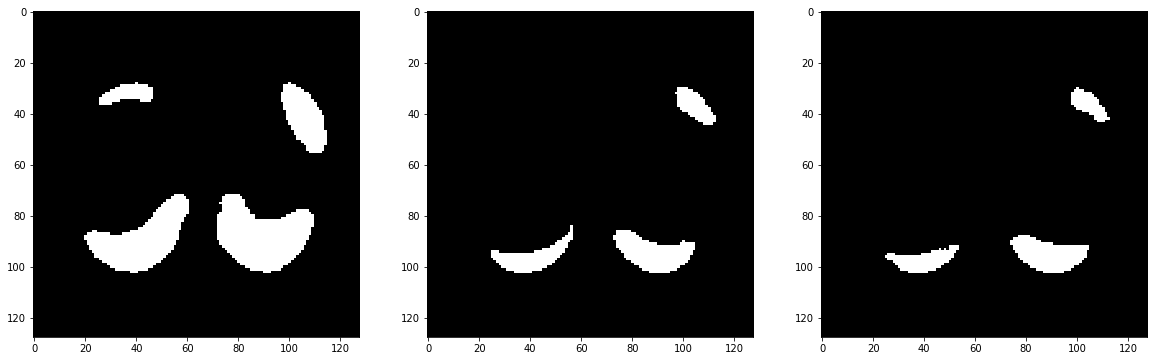

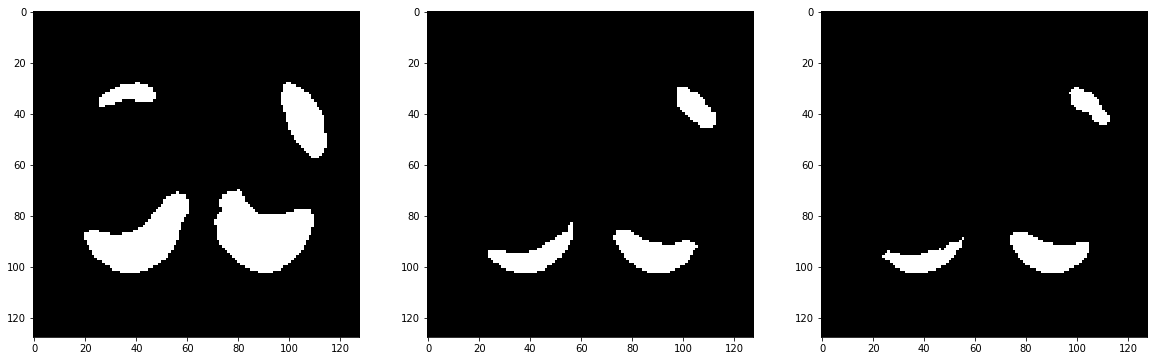

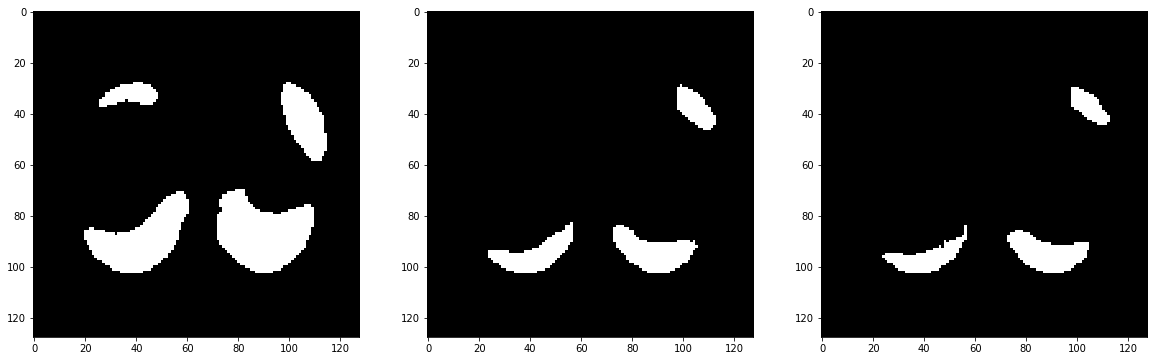

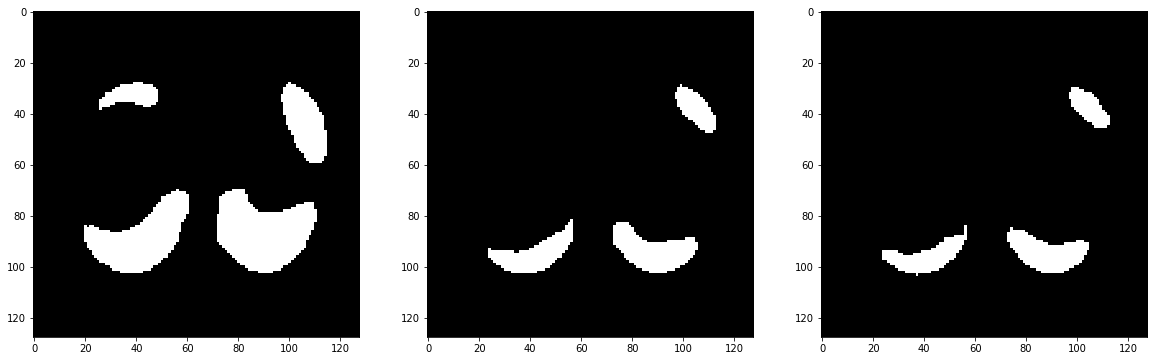

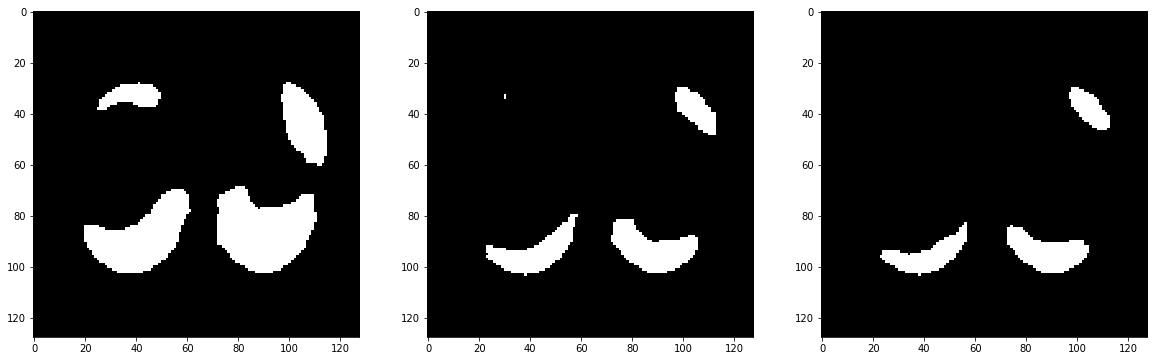

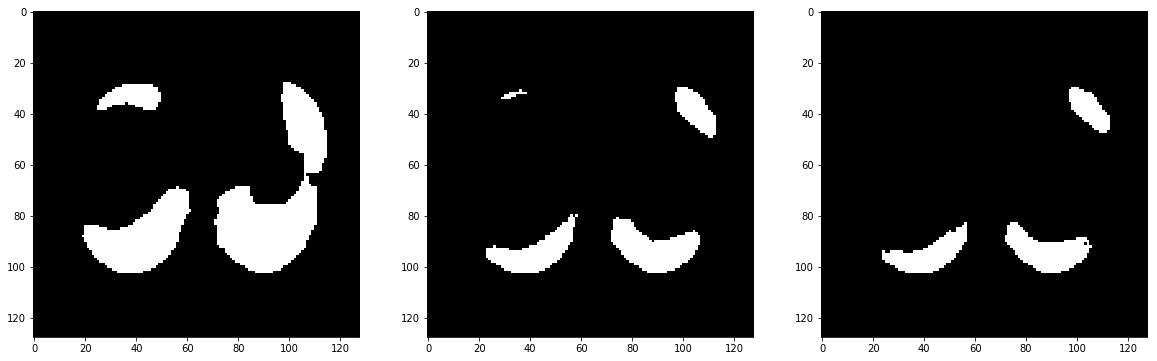

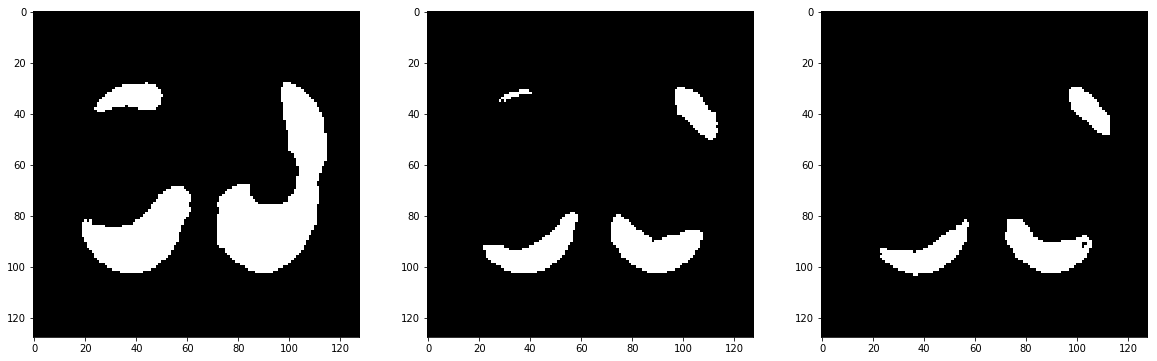

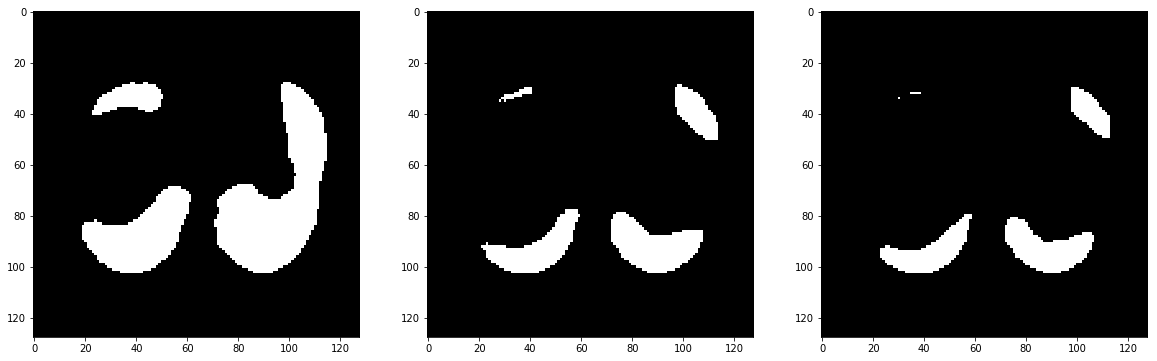

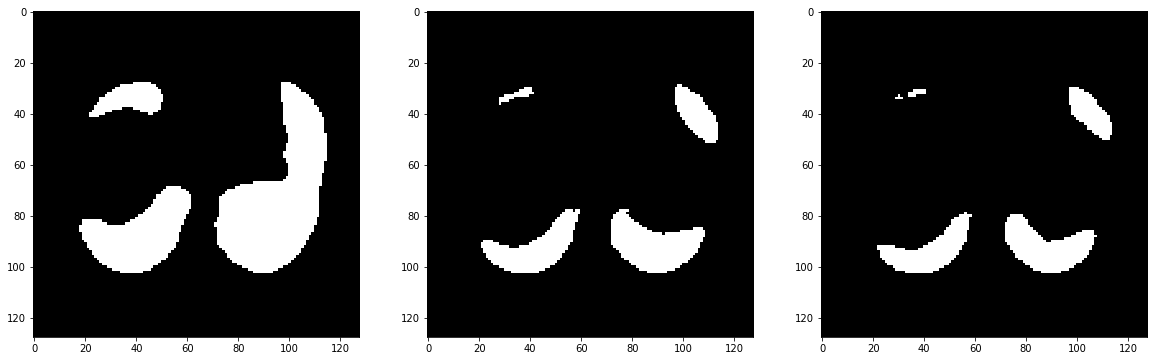

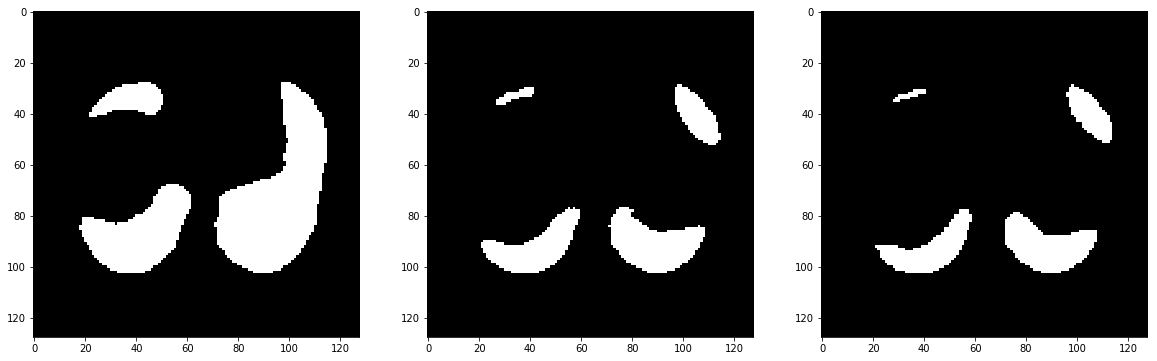

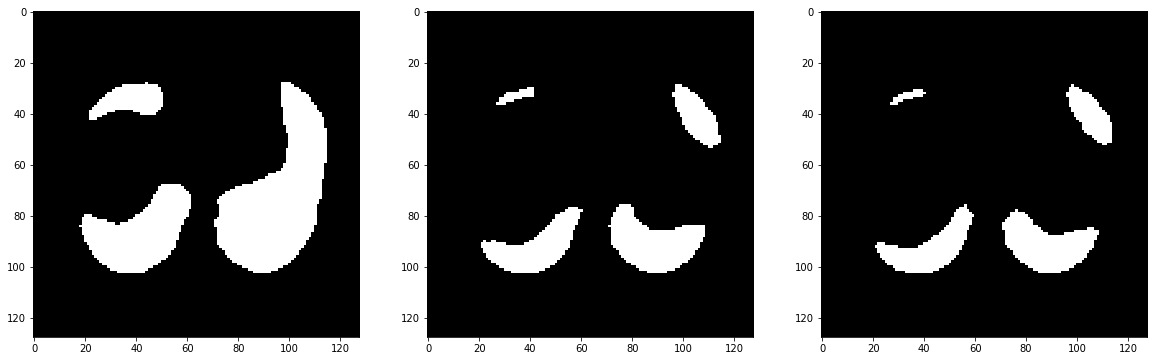

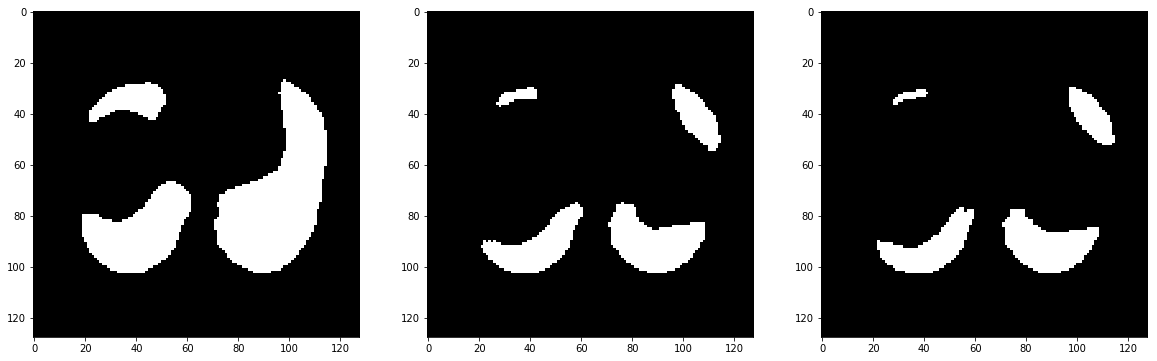

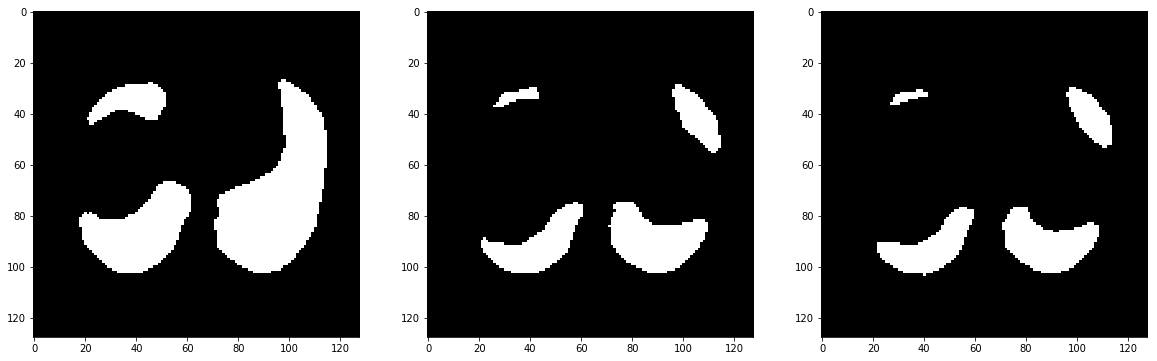

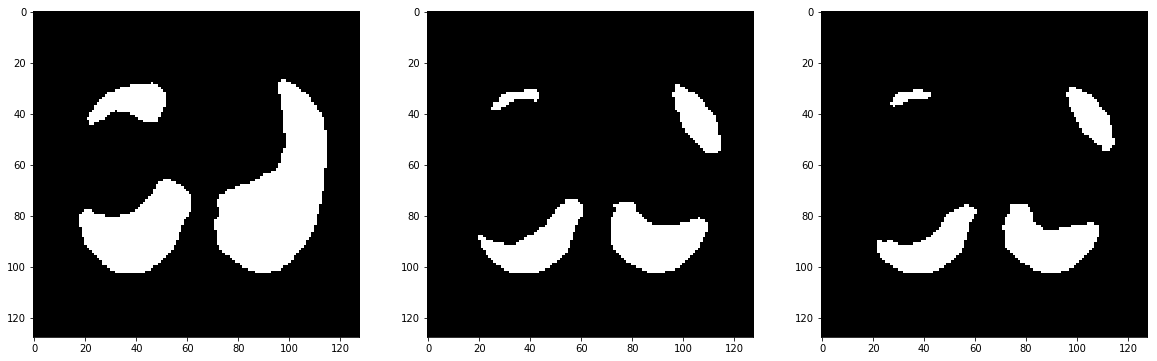

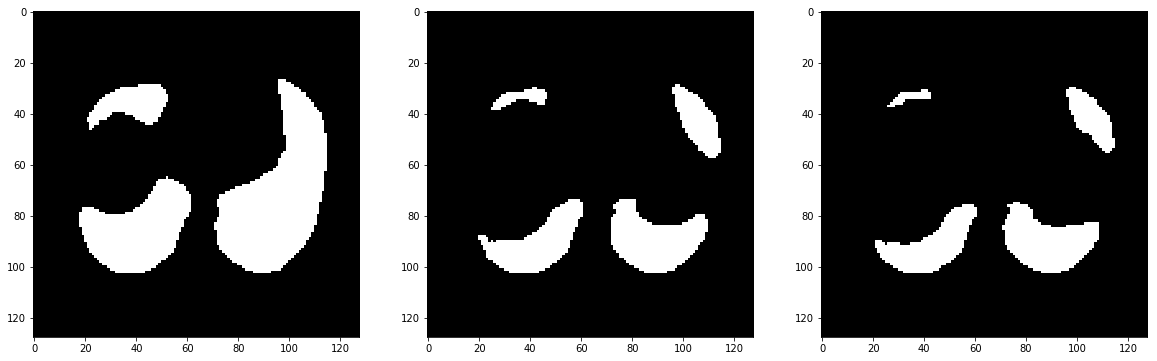

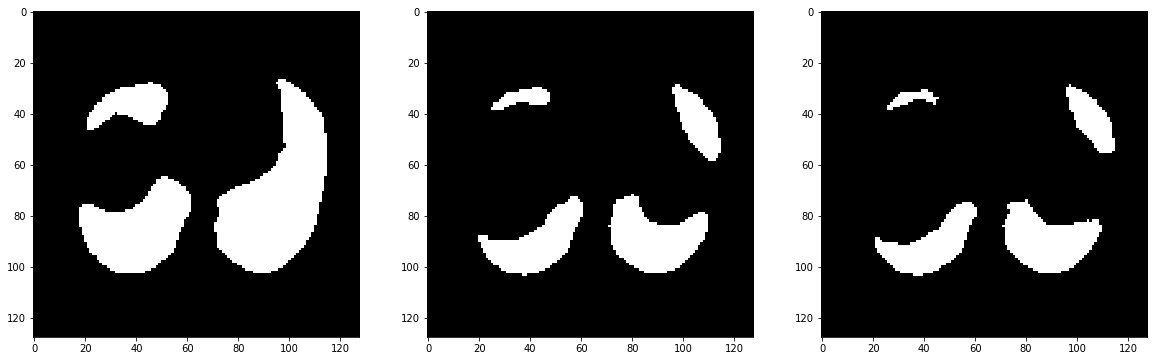

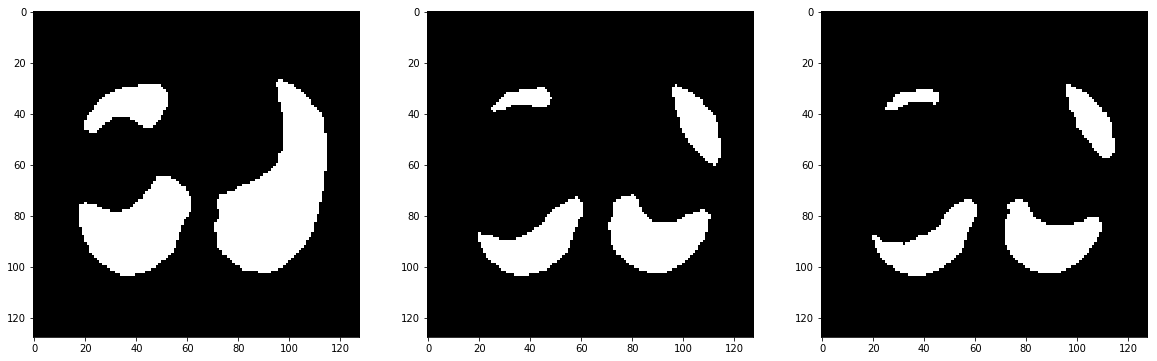

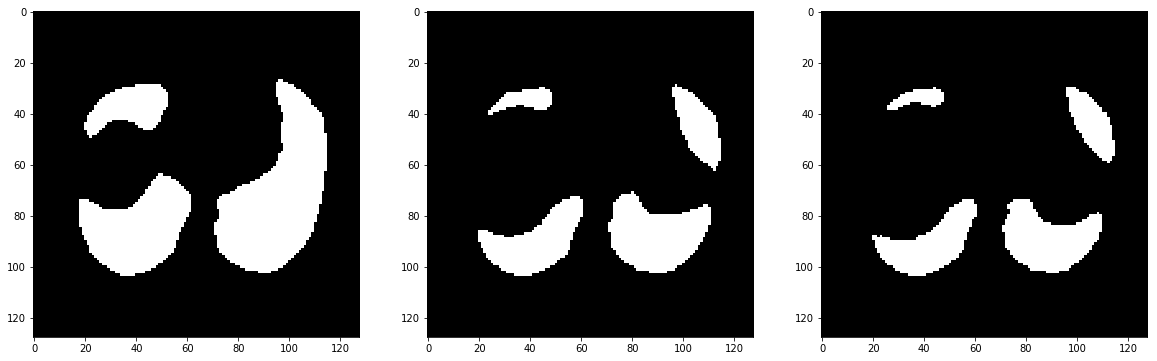

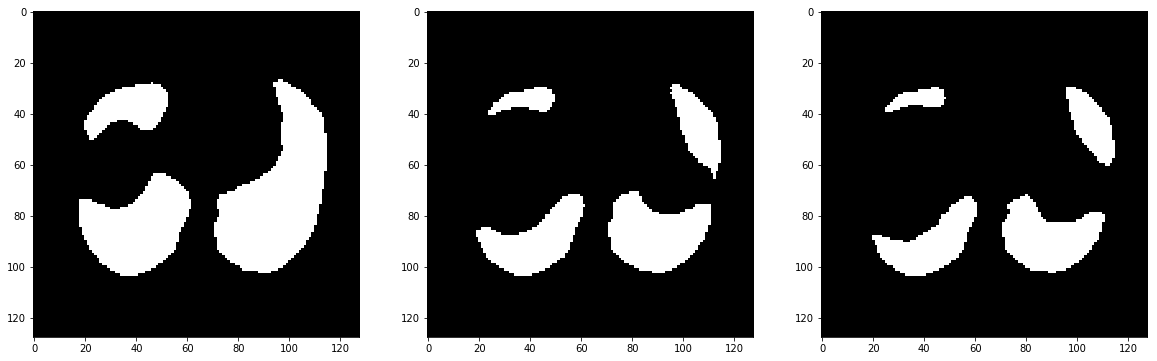

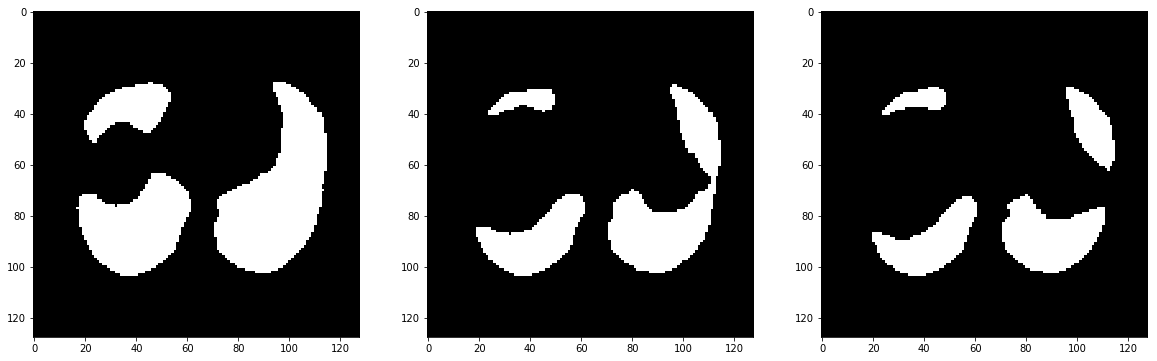

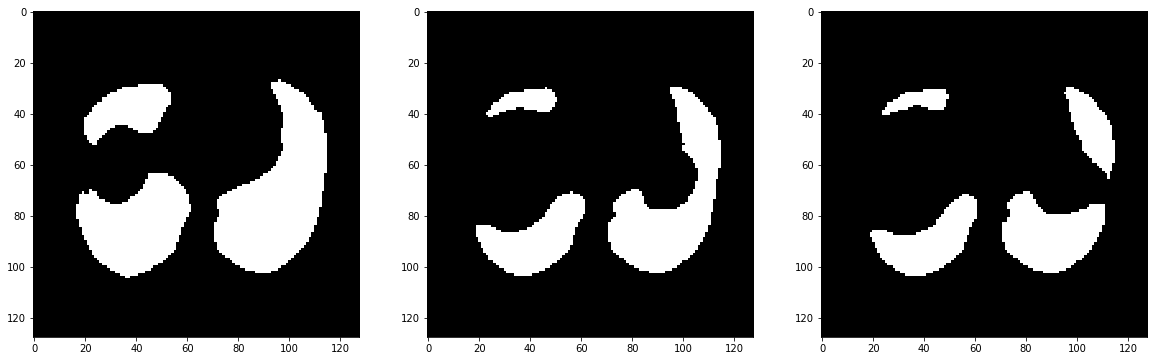

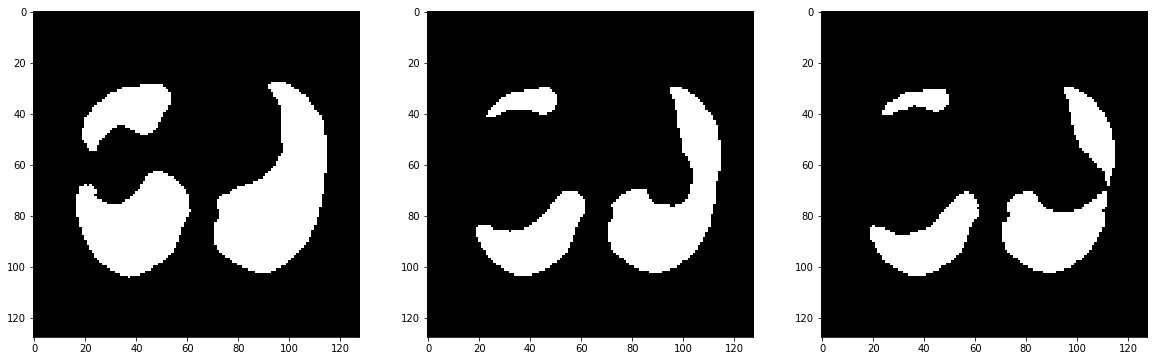

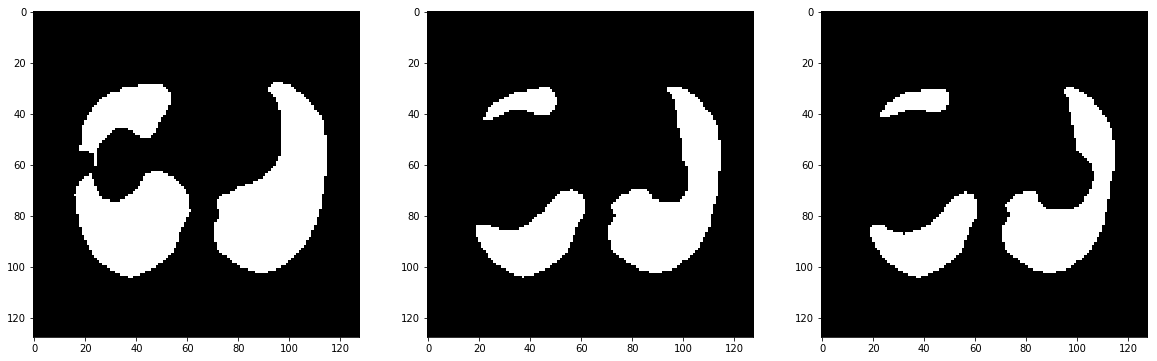

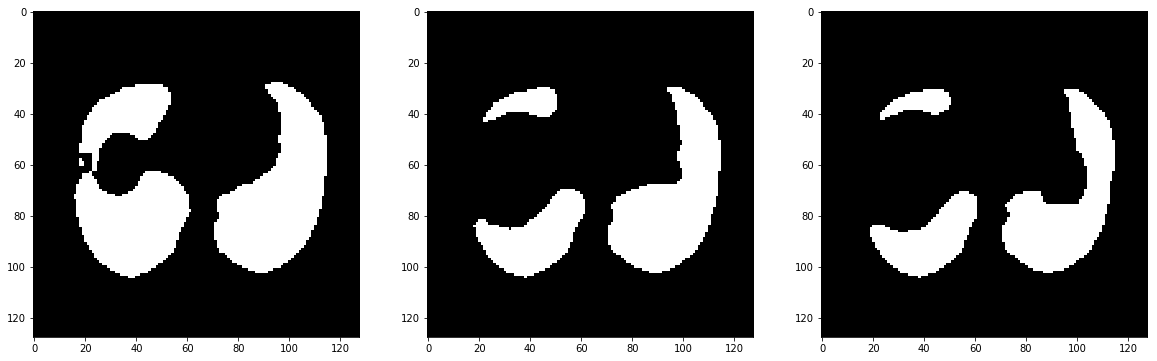

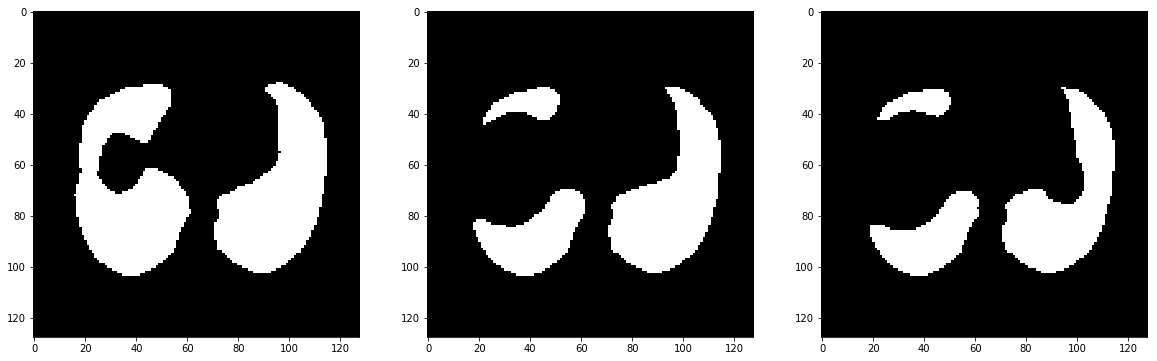

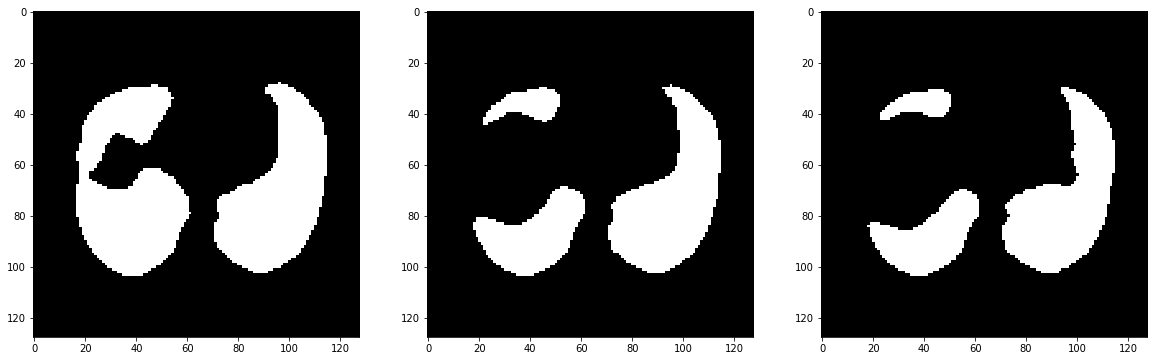

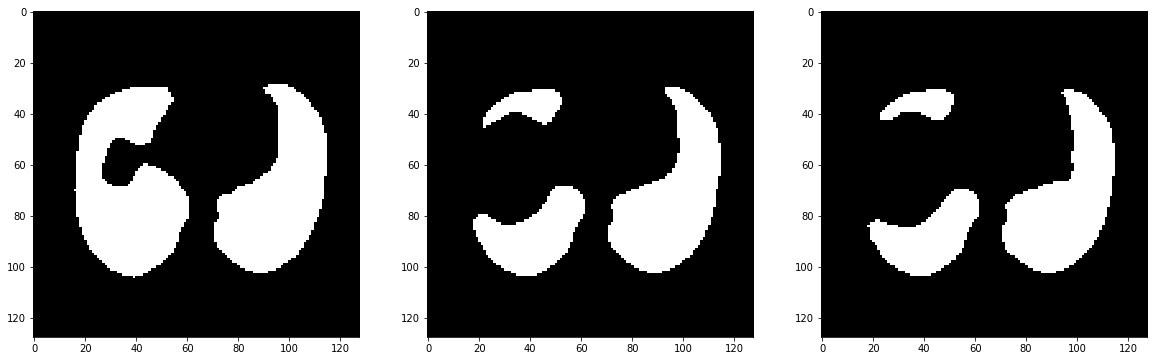

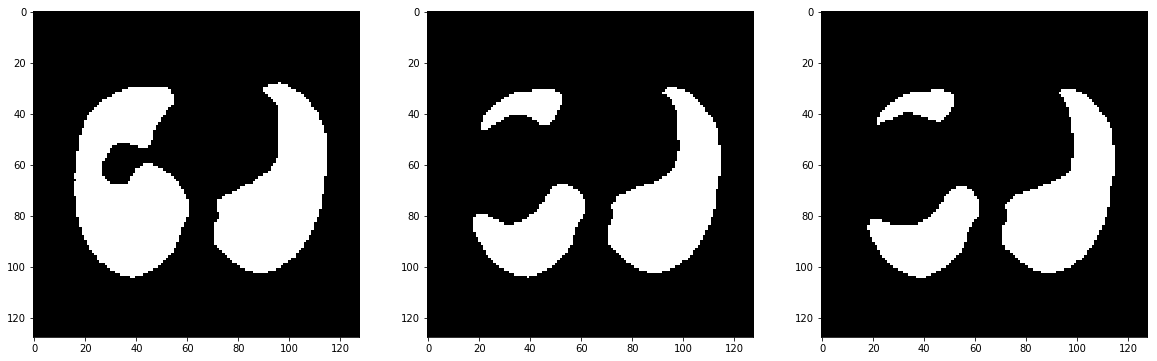

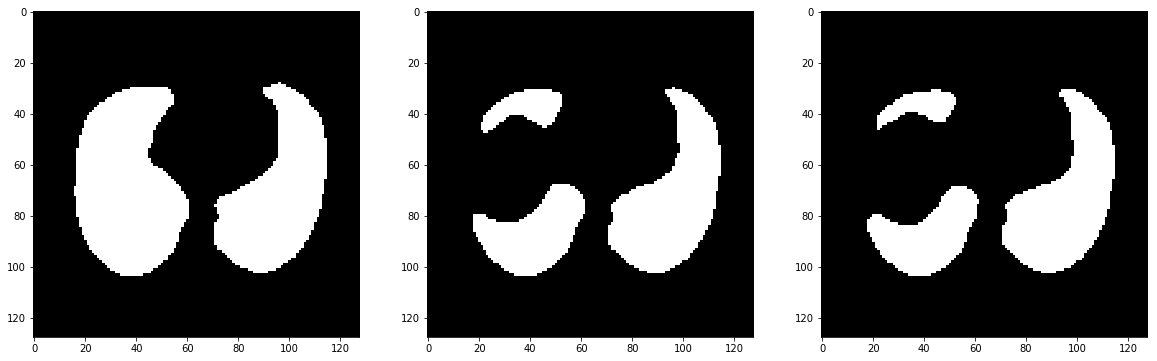

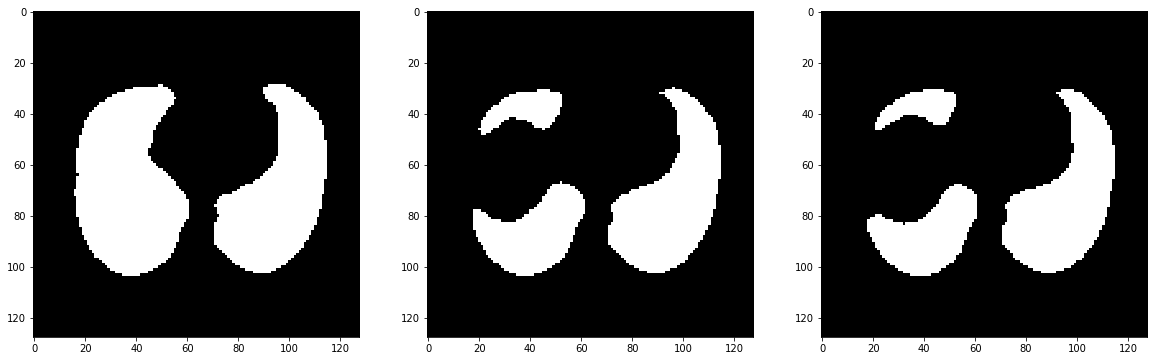

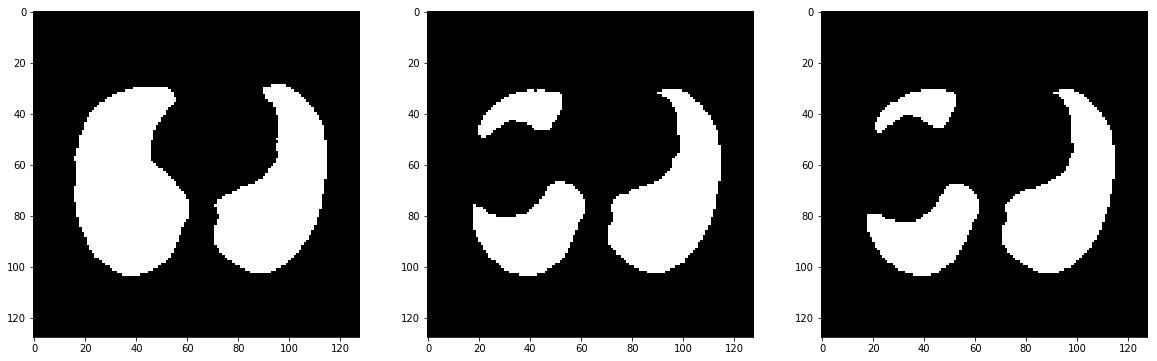

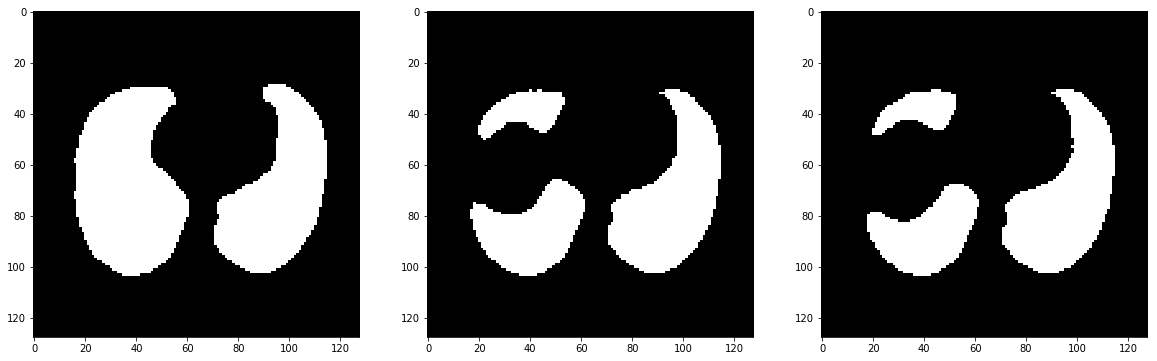

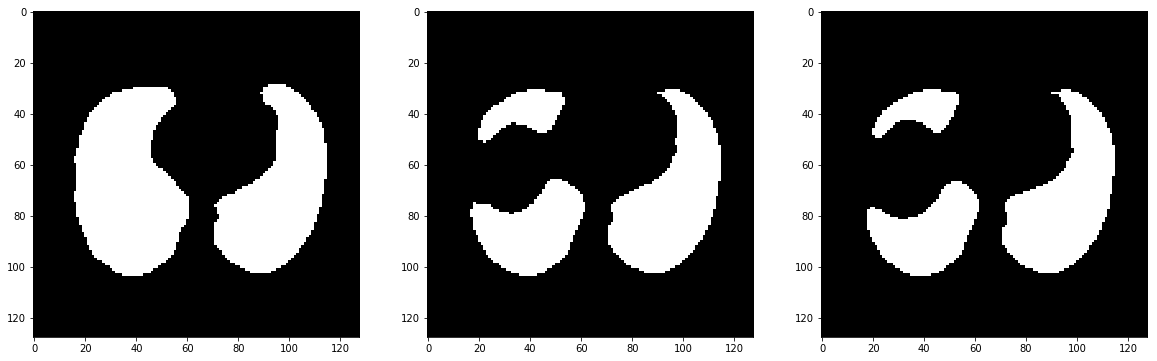

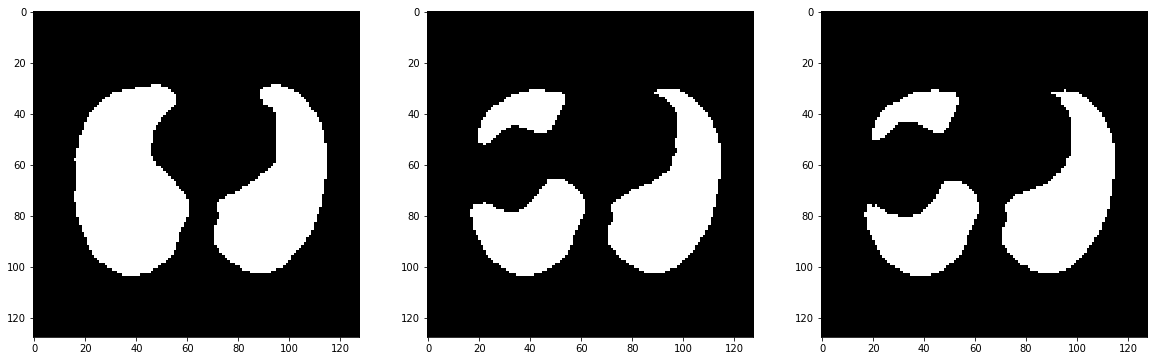

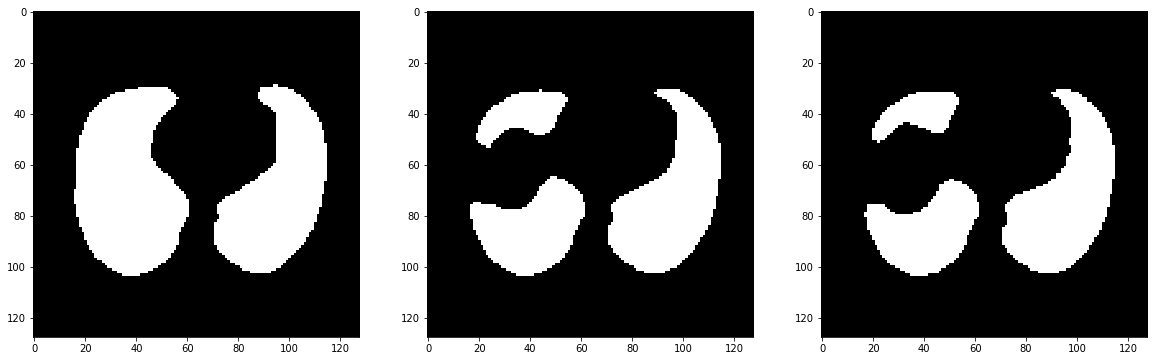

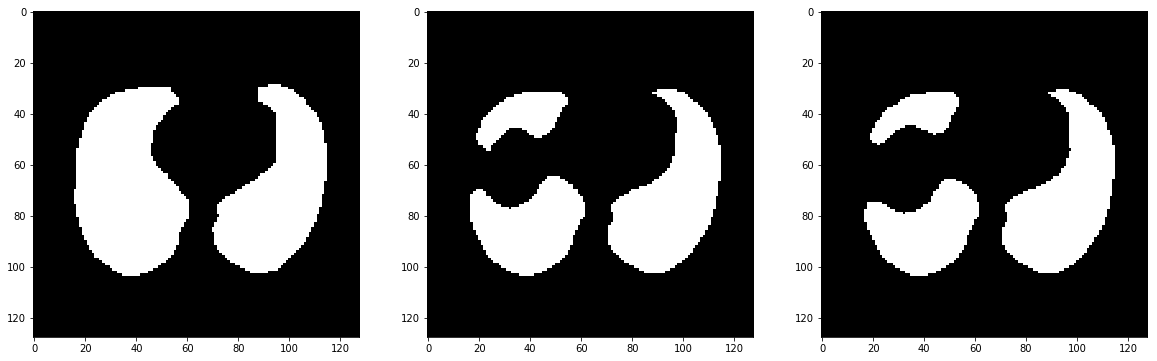

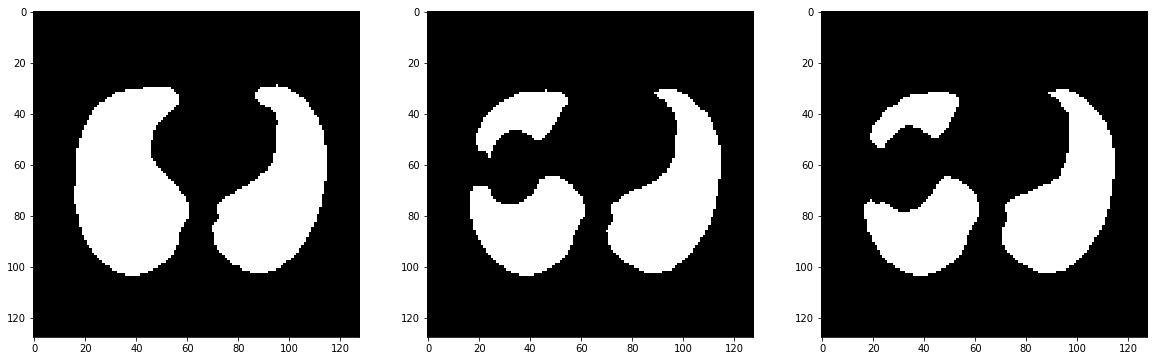

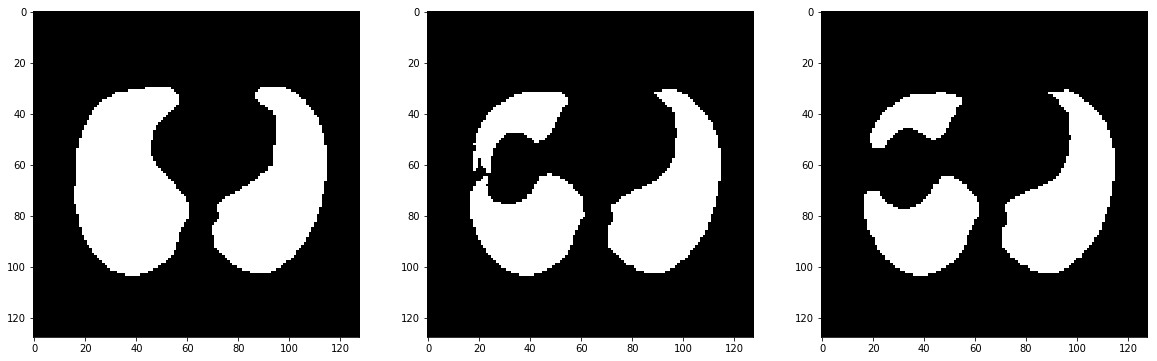

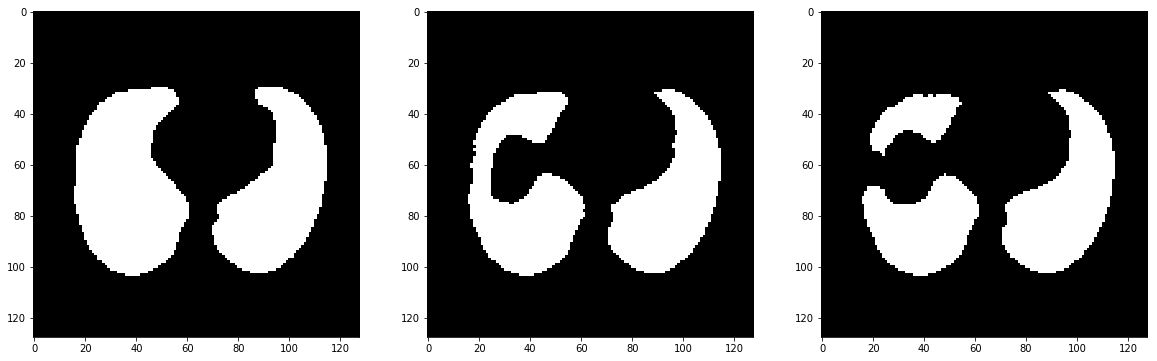

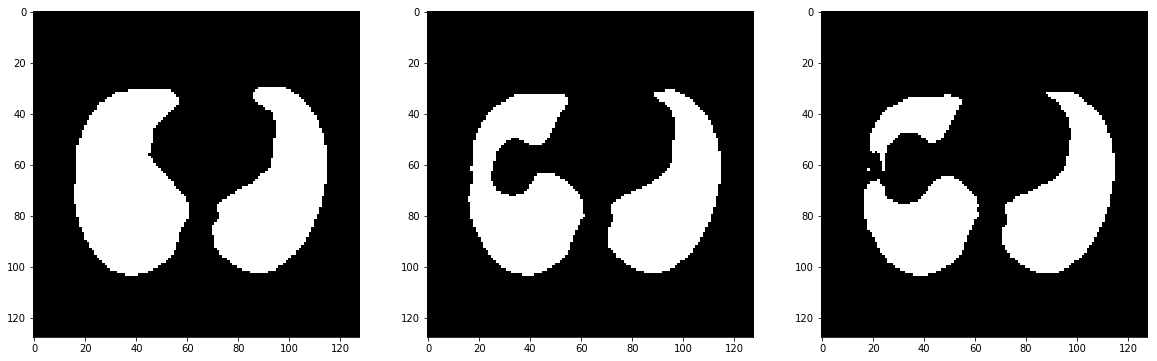

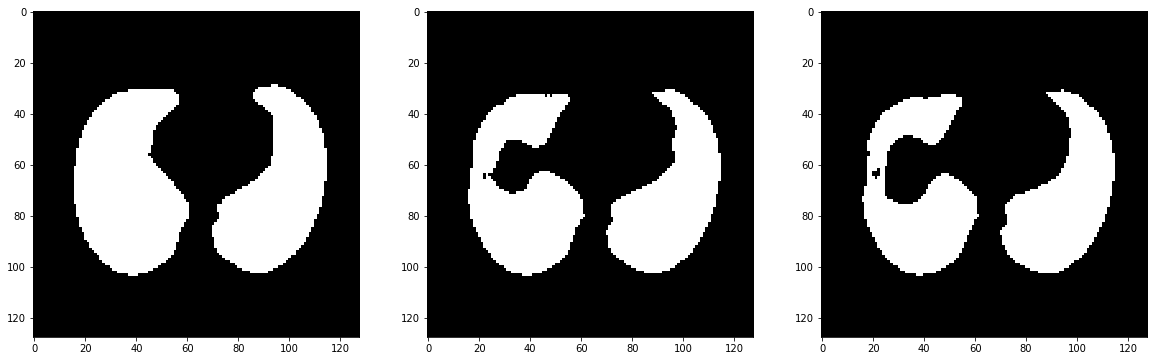

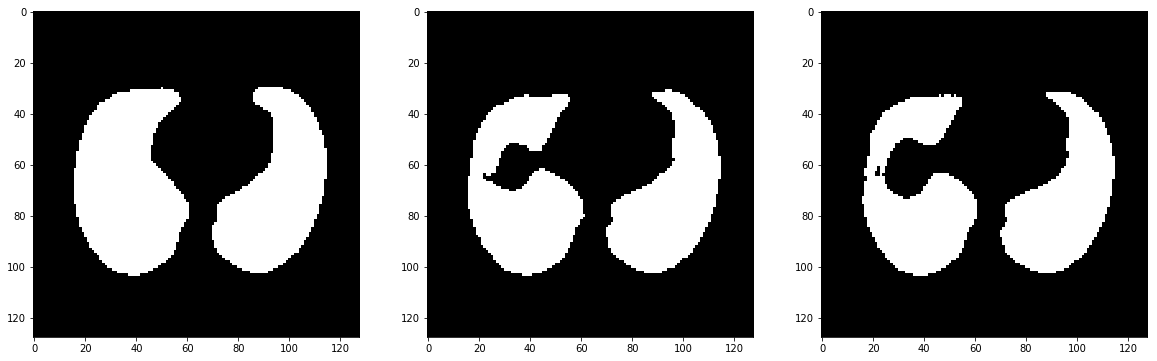

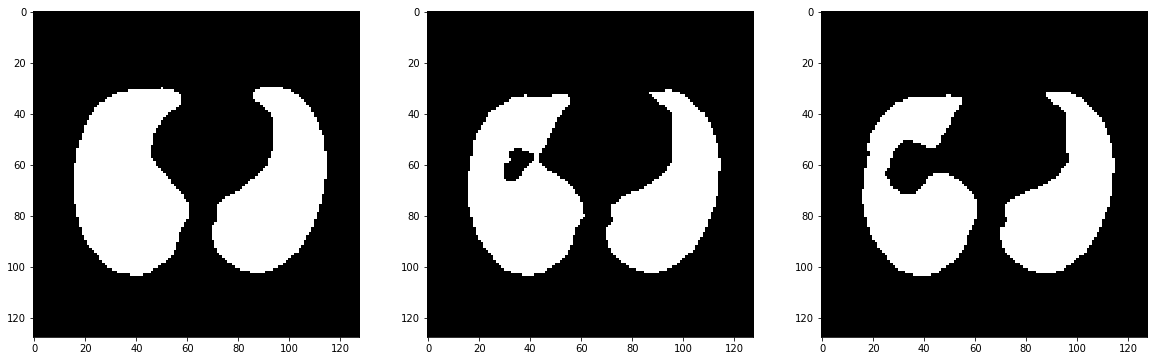

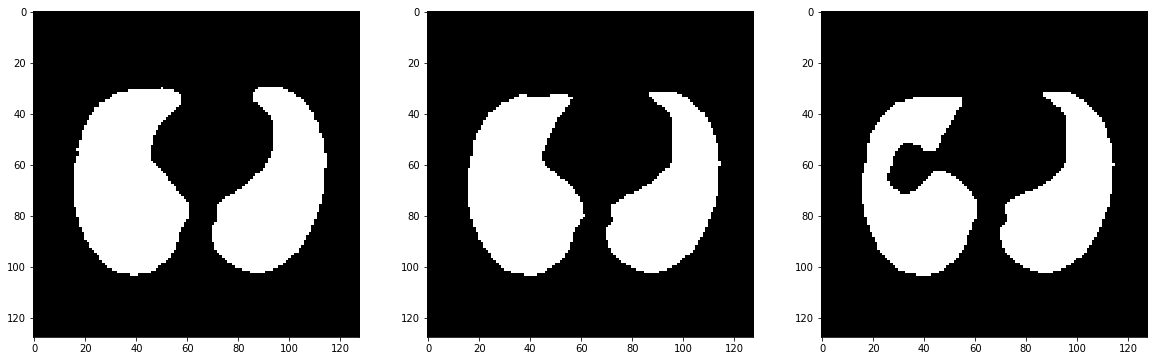

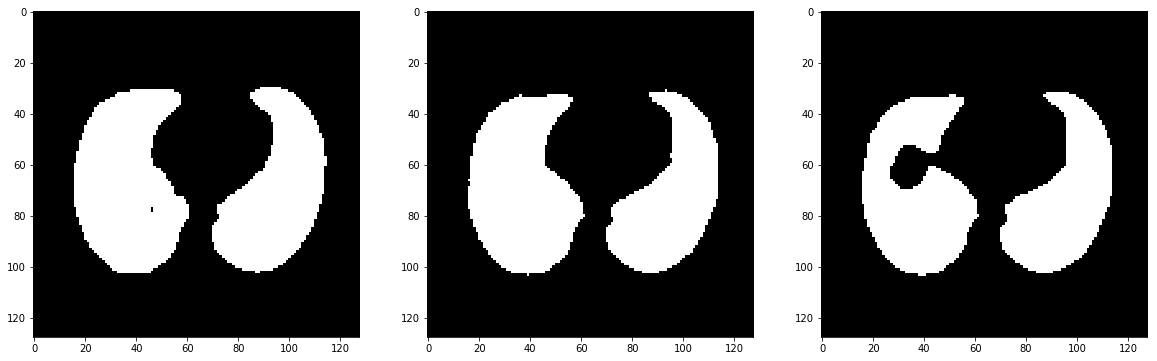

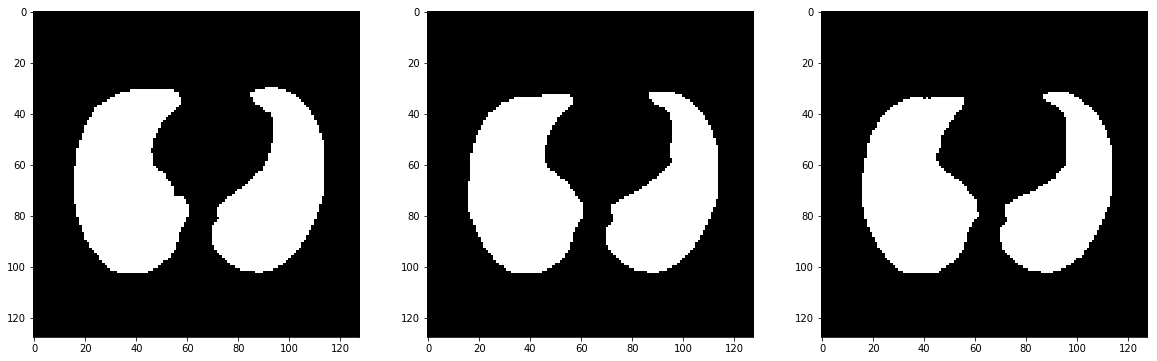

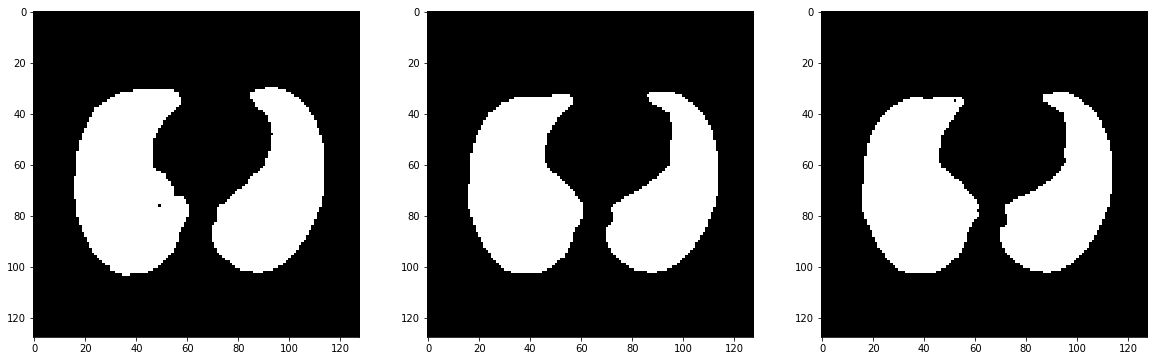

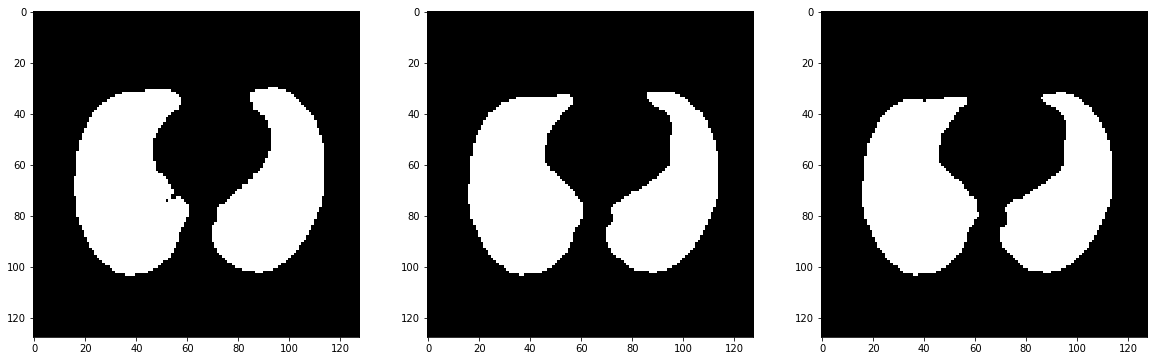

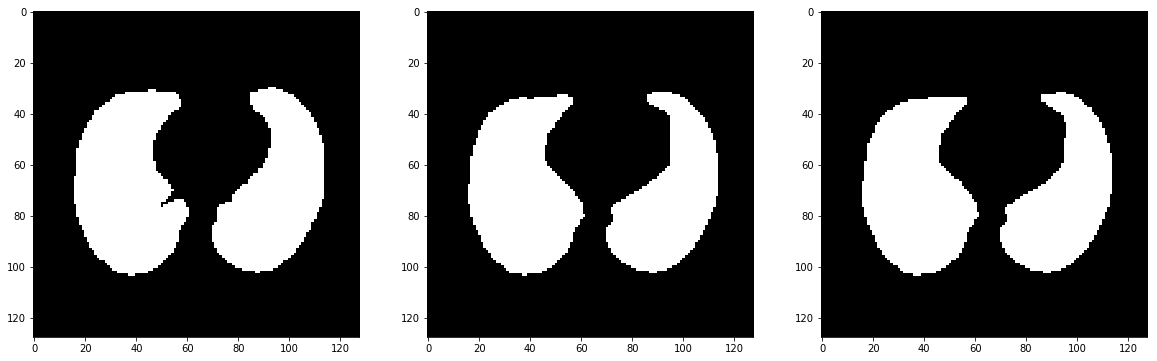

In [24]:
for i in range(100):   
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1),
    plt.imshow(result1[i,:,:,0],'gray')
    plt.subplot(1, 3, 2)
    plt.imshow(result2[i,:,:,0],'gray')
    plt.subplot(1, 3, 3)
    plt.imshow(result3[i,:,:,0],'gray')

(286, 128, 128, 1) (286, 128, 128, 1) (286, 128, 128, 1)
